In [1]:
# importing the necessary libraries:
import warnings
warnings.filterwarnings("ignore")
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scrublet as scr
import leidenalg
import seaborn as sns
import gseapy as gp
plt.rcParams.update(plt.rcParamsDefault)

**Creating a new categorical column, *broad_neutro_type*, in the obs attribute of wound_neutro.**
**Step1**: Classify based on UMAP Dimension
**Step2**: Map Boolean Values to Descriptive Labels
**Step2**: Convert to Categorical Data

In [2]:
plt.rcdefaults()
wound_neutro = sc.read('wound_neutro_filtered.h5ad')
# step 1
wound_neutro.obs["broad_neutro_type"] = wound_neutro.obsm["X_umap"][:, 1] > 8
# step 2
wound_neutro.obs["broad_neutro_type"] = wound_neutro.obs["broad_neutro_type"].map({False: "Blood-like", True: "Tissue-like"})
# step 3
wound_neutro.obs["broad_neutro_type"] = pd.Categorical(wound_neutro.obs["broad_neutro_type"])
wound_neutro.obs

time_point  n_genes_by_counts  log1p_n_genes_by_counts  \
Wound_56_1             24hr                874                 6.774224   
Wound_65_1             24hr               1520                 7.327123   
Wound_67_1             24hr                750                 6.621406   
Wound_413_1            24hr                831                 6.723832   
Wound_420_1            24hr               1170                 7.065613   
...                     ...                ...                      ...   
Wound_56526610_2      Blood               1230                 7.115582   
Wound_56538996_2      Blood               1090                 6.994850   
Wound_56550234_2      Blood               1447                 7.277939   
Wound_56576762_2      Blood               1326                 7.190676   
Wound_56604727_2      Blood               1473                 7.295735   

                  total_counts  log1p_total_counts  \
Wound_56_1                4393            8.387995   
Wound_65_1                4938            8.504918   
Wound_67_1                2283            7.733684   
Wound_413_1               2228            7.709308   
Wound_420_1               5006            8.518592   
...                        ...                 ...   
Wound_56526610_2          2737            7.914983   
Wound_56538996_2          2962            7.993958   
Wound_56550234_2          3266            8.091627   
Wound_56576762_2          2947            7.988882   
Wound_56604727_2          4036            8.303257   

                  pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
Wound_56_1                         50.899158                    62.212611   
Wound_65_1                         27.521264                    36.978534   
Wound_67_1                         36.224266                    49.102059   
Wound_413_1                        33.662478                    45.960503   
Wound_420_1                        36.675989                    49.660408   
...                                      ...                          ...   
Wound_56526610_2                   30.836682                    40.189989   
Wound_56538996_2                   37.035787                    46.792708   
Wound_56550234_2                   23.698714                    33.251684   
Wound_56576762_2                   24.635222                    34.747201   
Wound_56604727_2                   31.714569                    41.303271   

                  pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  \
Wound_56_1                          74.527658                    91.486456   
Wound_65_1                          50.324018                    72.235723   
Wound_67_1                          65.440210                    89.049496   
Wound_413_1                         61.445242                    85.143627   
Wound_420_1                         63.503795                    83.120256   
...                                       ...                          ...   
Wound_56526610_2                    52.685422                    73.328462   
Wound_56538996_2                    58.980419                    80.081026   
Wound_56550234_2                    45.529700                    67.452541   
Wound_56576762_2                    47.879199                    70.376654   
Wound_56604727_2                    53.295342                    72.770069   

                  total_counts_mt  ...  total_counts_hb  \
Wound_56_1                     98  ...                0   
Wound_65_1                     28  ...                0   
Wound_67_1                      3  ...                1   
Wound_413_1                    20  ...                0   
Wound_420_1                    48  ...                0   
...                           ...  ...              ...   
Wound_56526610_2                3  ...                0   
Wound_56538996_2               12  ...                0   
Wound_56550234_2                8  ...                0   
Wound_56576762_

In [3]:
wound_neutro.write("wound_neutro_with_broad_type.h5ad")

UMAP colored by time_point & broad_neutro_type


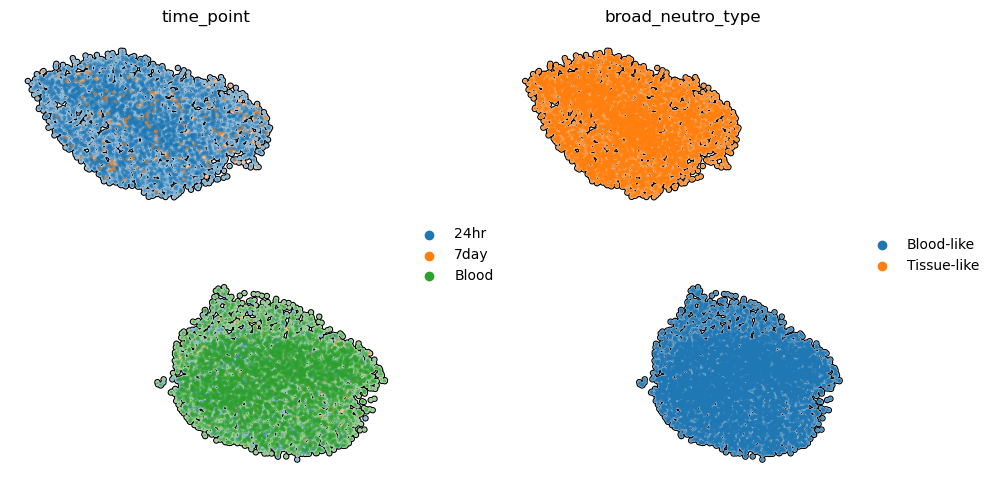

In [4]:
# creating a side-by-side comparison of the UMAP based on "time_point" and "broad_neutro_type"
print ("UMAP colored by time_point & broad_neutro_type")
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

for ax, colorby in zip(axs, ["time_point", "broad_neutro_type"]):
    ax.set(title=colorby) 
    ax.set_axis_off()  
    sc.pl.umap(
        wound_neutro,
        color=colorby,
        ax=ax,
        add_outline=True,
        s=30,
        alpha=0.5 + 0.3 * (colorby == "broad_neutro_type"),
        show=False 
    )
ax.set_aspect(1.0)
fig.tight_layout()
plt.show()

In [5]:
print(wound_neutro.uns["time_point_colors"])
wound_neutro.obs.groupby(['broad_neutro_type']).size()

['#1f77b4' '#ff7f0e' '#2ca02c']


broad_neutro_type
Blood-like     6328
Tissue-like    4660
dtype: int64

In [6]:
import pandas as pd

# Extract relevant data
df = wound_neutro.obs[['broad_neutro_type', 'time_point']]

# Count cells for each (Type, Time) combination
counts = df.groupby(['broad_neutro_type', 'time_point']).size().unstack(fill_value=0)

# Display raw counts
print(counts)


time_point         24hr  7day  Blood
broad_neutro_type                   
Blood-like          817   105   5406
Tissue-like        4507   153      0


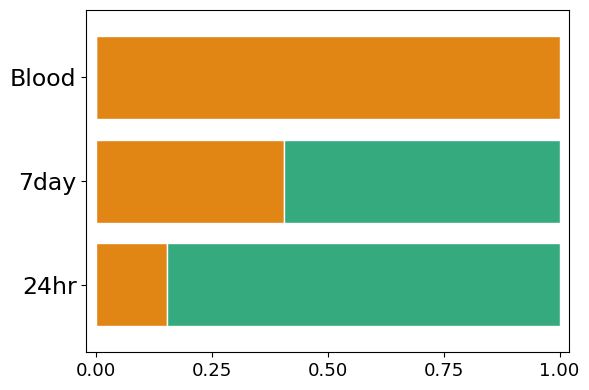

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Define the raw data
data = {
    "Blood-like": {"Blood": 5406, "24hr": 817, "7day": 105},
    "Tissue-like": {"Blood": 0, "24hr": 4507, "7day": 153},
}

# Step 2: Create the DataFrame and reorder rows (index)
df = pd.DataFrame(data)
df = df.loc[["24hr", "7day", "Blood"]]  # enforce desired order top-to-bottom

# Step 3: Convert to proportions (row-wise)
fractions = df.div(df.sum(axis=1), axis=0)

# Step 4: Plot
ax = fractions.plot(
    kind='barh',
    stacked=True,
    figsize=(6, 4),
    width=0.8,
    edgecolor='white',
    color=["#E18514", "#36AA7F"],  # Blood-like, Tissue-like
)

# Step 5: Style
ax.set_xlim(0, 1)
ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
ax.set_xticklabels(['0.00', '0.25', '0.50', '0.75', '1.00'])
ax.set_xlim(-0.02, 1.02)
ax.set_yticklabels(['24hr', '7day', 'Blood'], fontsize=17)
ax.tick_params(axis='x', labelsize=13)

# Clean layout
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
ax.legend().remove()

plt.tight_layout()
plt.show()

# DEGs between the 2 cluster of neutrophils in wound (blood-like and tissue-like)

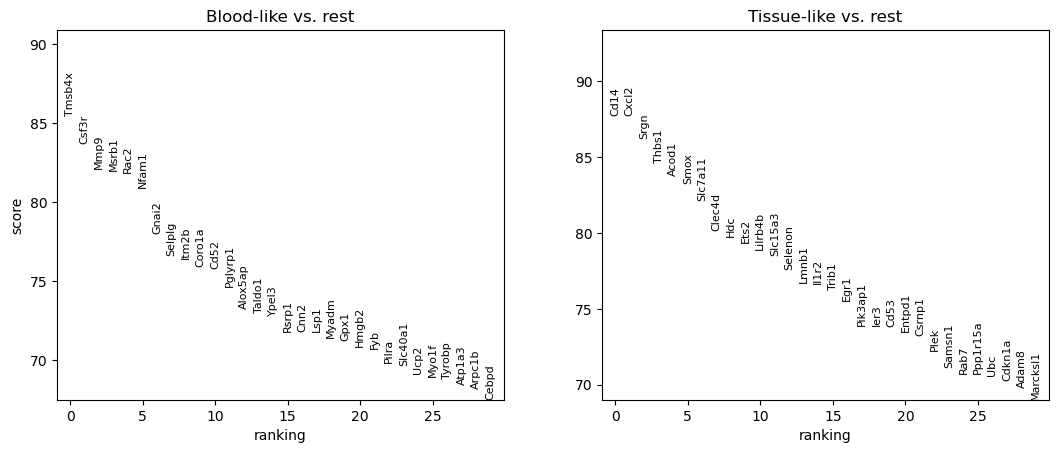

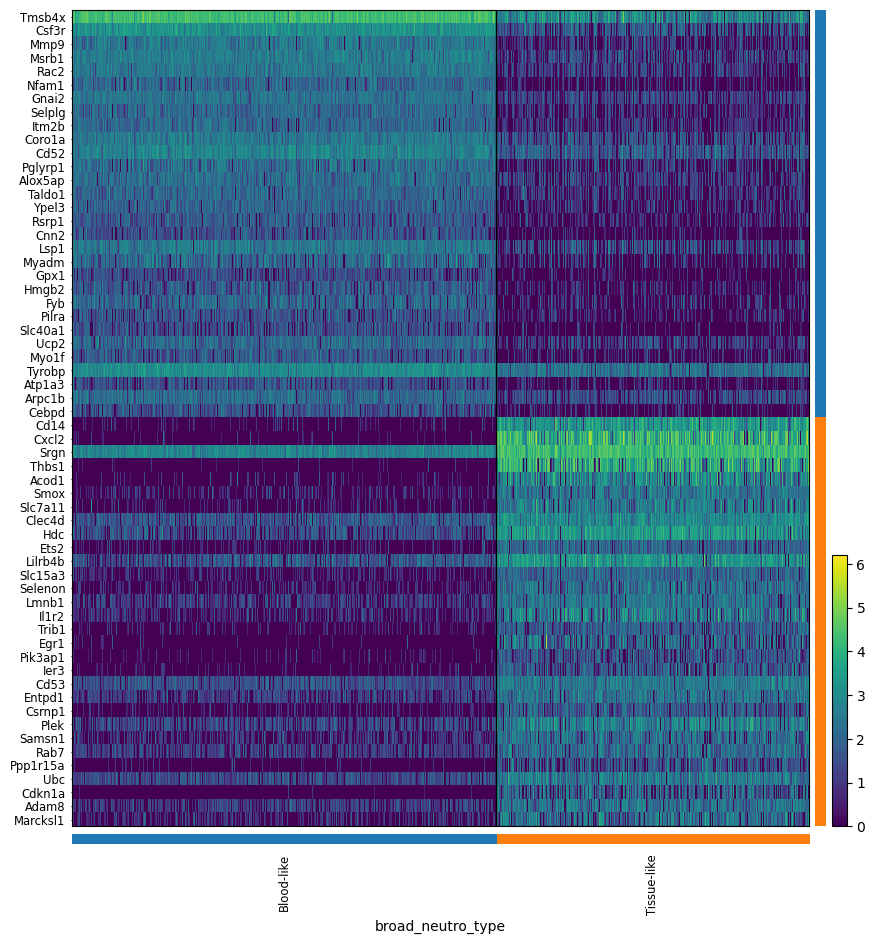

Cd14 is supposed to be "up": Blood-like 0.1489020586013794, Tissue-like 3.128326892852783
  (Up means up in Tissue-like)


In [8]:
# Perform differential gene expression analysis
sc.tl.rank_genes_groups(wound_neutro, groupby='broad_neutro_type', method='wilcoxon')

# View the top-ranked genes
sc.pl.rank_genes_groups(wound_neutro, n_genes=30, sharey=False)

sc.pl.rank_genes_groups_heatmap(wound_neutro, n_genes=30, groupby='broad_neutro_type', swap_axes=True, min_logfoldchange=0.25, dendrogram=False, show_gene_labels=True)

# Extract results
tmp = wound_neutro.uns['rank_genes_groups']

# Create a DataFrame with gene names, log2 fold change, p-values, and adjusted p-values
upreg = pd.DataFrame(
    index=[x[1] for x in tmp["names"]],  
    data={
        "score": [x[1] for x in tmp["scores"]],
        "pval": [x[1] for x in tmp["pvals"]],
        "pval_adj": [x[1] for x in tmp["pvals_adj"]],
        "logFC": [x[1] for x in tmp["logfoldchanges"]],
    },
)
# Top-ranked gene for tissue-specific neutrophils
top_up = upreg.index[0] 

# calculate the mean expression of this gene in "blood-like" and "tissue-specific" groups:
xbl = wound_neutro[
    wound_neutro.obs["broad_neutro_type"] == "Blood-like", top_up
].X.mean()
xts = wound_neutro[
    wound_neutro.obs["broad_neutro_type"] != "Blood-like", top_up
].X.mean()

print(f'{top_up} is supposed to be "up": Blood-like {xbl}, Tissue-like {xts}')
print("  (Up means up in Tissue-like)")

# Sort the DataFrame by adjusted p-value (ascending order)
#upreg = upreg.sort_values('pval_adj')

# View the top DEGs and save it as a scv file
#print(upreg.head())

#upreg.to_csv("blood-like vs tissue-specific.csv", index=False)

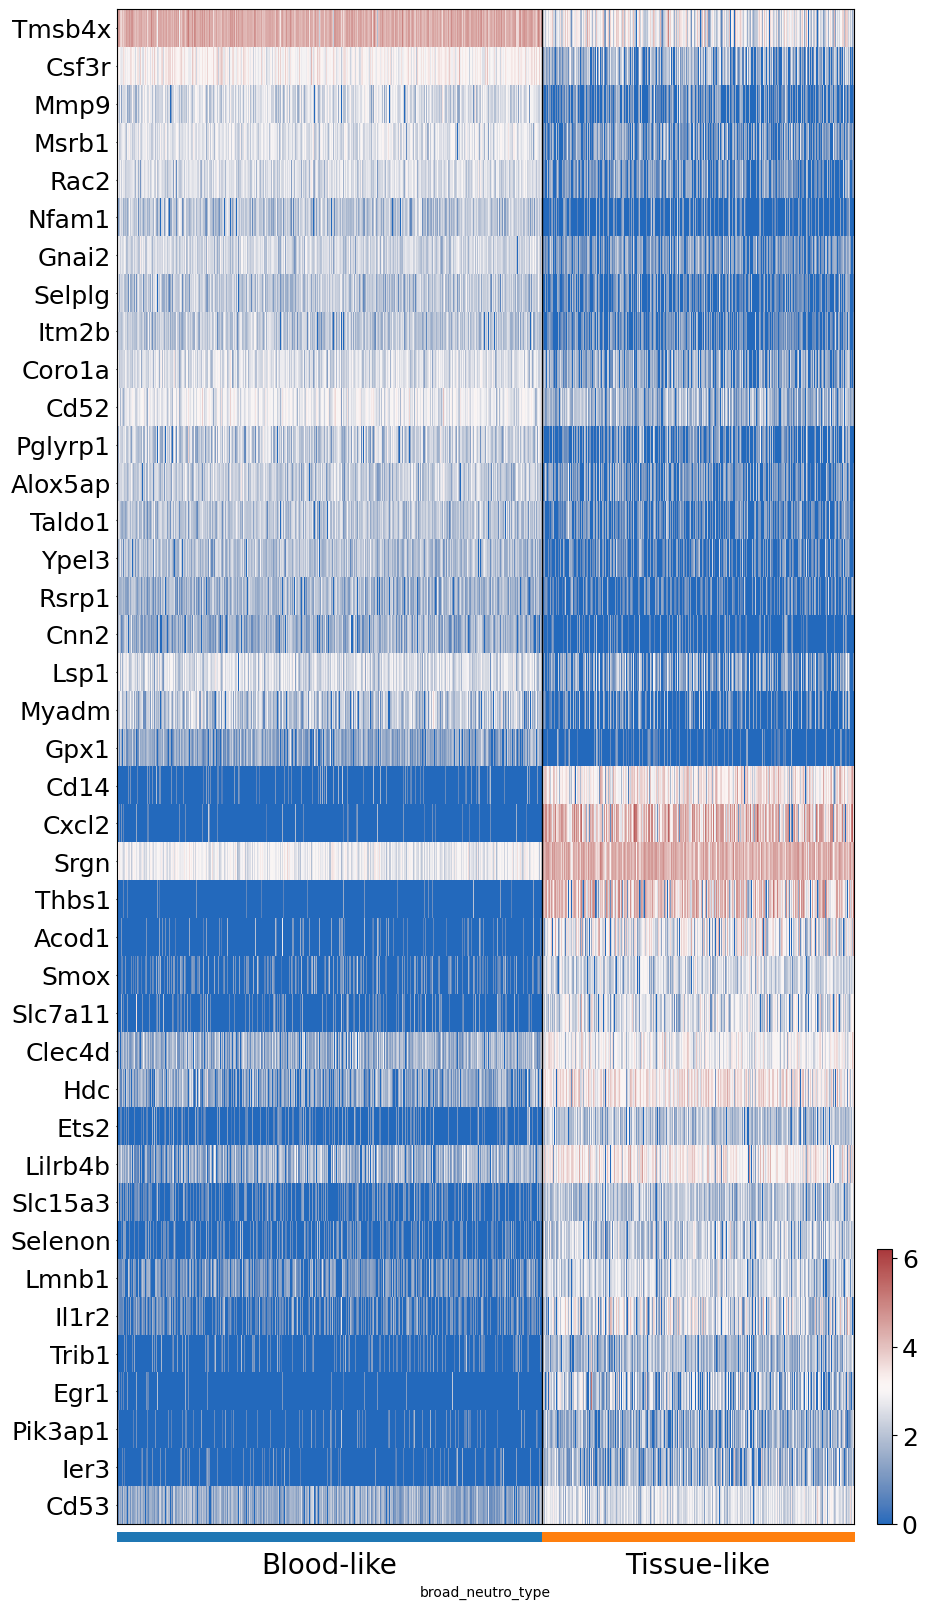

In [9]:
import matplotlib.pyplot as plt

# Step 1: Plot the heatmap without showing immediately
sc.pl.rank_genes_groups_heatmap(
    wound_neutro,
    n_genes=20,
    groupby='broad_neutro_type',
    swap_axes=True,
    min_logfoldchange=0.25,
    cmap='vlag',
    dendrogram=False,
    show_gene_labels=True,
    show=False,         # modify before displaying
    figsize=(10, 20)
)

# Step 2: Access the figure
fig = plt.gcf()

# Step 3: Remove colorbars (heuristic: narrow, tall axes)
for ax in fig.axes:
    bbox = ax.get_position()
    if bbox.width < 0.02 and bbox.height > 0.3:
        fig.delaxes(ax)

# Step 4: Adjust group labels and gene labels
for ax in fig.axes:
    # Set x-axis group labels (blood-like, tissue-specific) to horizontal
    if ax.get_xlabel() == 'broad_neutro_type':
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=20)

    # Set y-axis gene name font size larger
    if ax.get_ylabel() == '':
        ax.tick_params(axis='y', labelsize=18)  # increase font size here

# Final layout and show
plt.tight_layout()
plt.show()


In [10]:
sc.tl.rank_genes_groups(wound_neutro, groupby='broad_neutro_type', method='wilcoxon')
top_genes = sc.get.rank_genes_groups_df(
    wound_neutro,
    group=None,              # get all groups
    log2fc_min=0.25,         # optional filtering
    pval_cutoff=0.05         # optional filtering
)

# Get top 20 genes per group, remove duplicates
top_20 = top_genes.groupby("group").head(20)["names"].unique().tolist()

In [11]:
print(top_20)

['Tmsb4x', 'Csf3r', 'Mmp9', 'Msrb1', 'Rac2', 'Nfam1', 'Gnai2', 'Selplg', 'Itm2b', 'Coro1a', 'Cd52', 'Pglyrp1', 'Alox5ap', 'Taldo1', 'Ypel3', 'Rsrp1', 'Cnn2', 'Lsp1', 'Myadm', 'Gpx1', 'Cd14', 'Cxcl2', 'Srgn', 'Thbs1', 'Acod1', 'Smox', 'Slc7a11', 'Clec4d', 'Hdc', 'Ets2', 'Lilrb4b', 'Slc15a3', 'Selenon', 'Lmnb1', 'Il1r2', 'Trib1', 'Egr1', 'Pik3ap1', 'Ier3', 'Cd53']


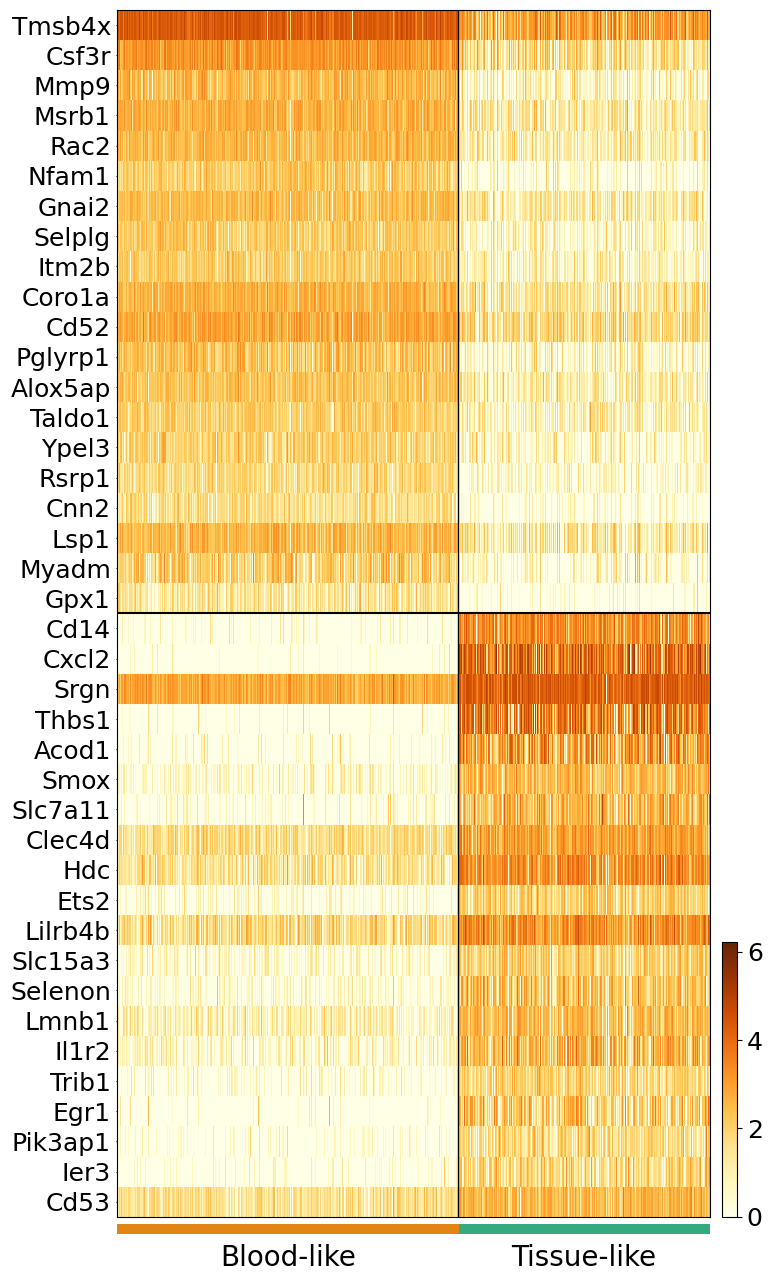

In [12]:
wound_neutro.uns['broad_neutro_type_colors'] = ['#E18514', '#36AA7F']
sc.pl.heatmap(
    wound_neutro,
    var_names=top_20,
    groupby="broad_neutro_type",
    standard_scale=None,  # optional: scale expression per gene
    swap_axes=True,
    cmap="YlOrBr",
    show_gene_labels=True,
    dendrogram=False,
     figsize=(8, 16),
    show=False
)


fig = plt.gcf()
for ax in fig.axes:
    if ax.get_xticklabels():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=20)
    if ax.get_ylabel() == '':
        ax.tick_params(axis='y', labelsize=18)
    if ax.get_xlabel() == "broad_neutro_type":
        ax.set_xlabel("")
axes = fig.get_axes()
axes[0].axhline(19.5, color="black")
#axes[0].axvline(6350.5, color="black", linewidth=0.7)
plt.tight_layout()
plt.show()

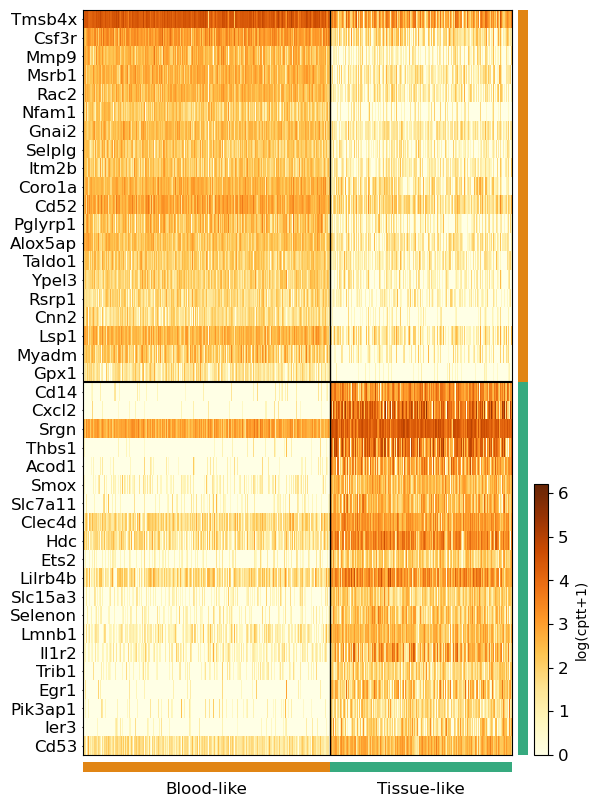

In [13]:
sc.pl.rank_genes_groups_heatmap(
    wound_neutro,
    n_genes=20,
    groupby='broad_neutro_type',
    swap_axes=True,
    min_logfoldchange=0.25,
    dendrogram=False,
    show_gene_labels=True,
    figsize=(6, 10),
    show=False,
    cmap="YlOrBr",
)

fig = plt.gcf()
for ax in fig.axes:
    if ax.get_xticklabels():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=12)
    if ax.get_ylabel() == '':
        ax.tick_params(axis='y', labelsize=12)
    if ax.get_xlabel() == "broad_neutro_type":
        ax.set_xlabel("")
axes = fig.get_axes()
axes[0].axhline(19.5, color="black")
#axes[0].axvline(6350.5, color="black")
axes[-1].set_ylabel("log(cptt+1)")

plt.tight_layout()
plt.show()

another try for pathway enrichment analysis

In [14]:
palette = {"up in blood-like": "#E18514", "up in tissue-like": "#36AA7F"}

print("Pathway analysis")
print(" Downregulated in Tissue-like (i.e., up in blood-like)")
enr_dwn = gp.enrichr(
    gene_list=list(upreg.index[::-1][:150]),
    gene_sets=["KEGG_2019_Mouse", "GO_Biological_Process_2023"],
    organism="mouse",
    outdir=None,
)

print(" Upregulated in Tissue-like")
enr_up = gp.enrichr(
    gene_list=list(upreg.index[:150]),
    gene_sets=["KEGG_2019_Mouse", "GO_Biological_Process_2023"],
    organism="mouse",
    outdir=None,
)


Pathway analysis
 Downregulated in Tissue-like (i.e., up in blood-like)
 Upregulated in Tissue-like


In [24]:
def extract_pathways(enr_result, gene_set_name, label, top_n=50):
    df = enr_result.results.copy()
    df = df[df["Gene_set"] == gene_set_name]
    df["-log10(FDR)"] = -np.log10(df["Adjusted P-value"])
    df = df.nsmallest(top_n, "Adjusted P-value")
    df["Condition"] = label
    return df

In [25]:
# KEGG
kegg_up = extract_pathways(enr_up, "KEGG_2019_Mouse", "up in tissue-like")
kegg_dwn = extract_pathways(enr_dwn, "KEGG_2019_Mouse", "up in blood-like")

# Sort KEGG results by significance for consistent plotting
kegg_up = kegg_up.sort_values("-log10(FDR)", ascending=False)
kegg_dwn = kegg_dwn.sort_values("-log10(FDR)", ascending=False)

In [39]:
# GO-BP
go_up = extract_pathways(enr_up, "GO_Biological_Process_2023", "up in tissue-like")
go_up["Term"] = go_up["Term"].str.replace(r"\s*\(GO:\d+\)", "", regex=True)
go_dwn = extract_pathways(enr_dwn, "GO_Biological_Process_2023", "up in blood-like")
go_dwn["Term"] = go_dwn["Term"].str.replace(r"\s*\(GO:\d+\)", "", regex=True)

# Sort GO-BP results by significance for consistent plotting
go_up = go_up.sort_values("-log10(FDR)", ascending=False)
go_dwn = go_dwn.sort_values("-log10(FDR)", ascending=False)


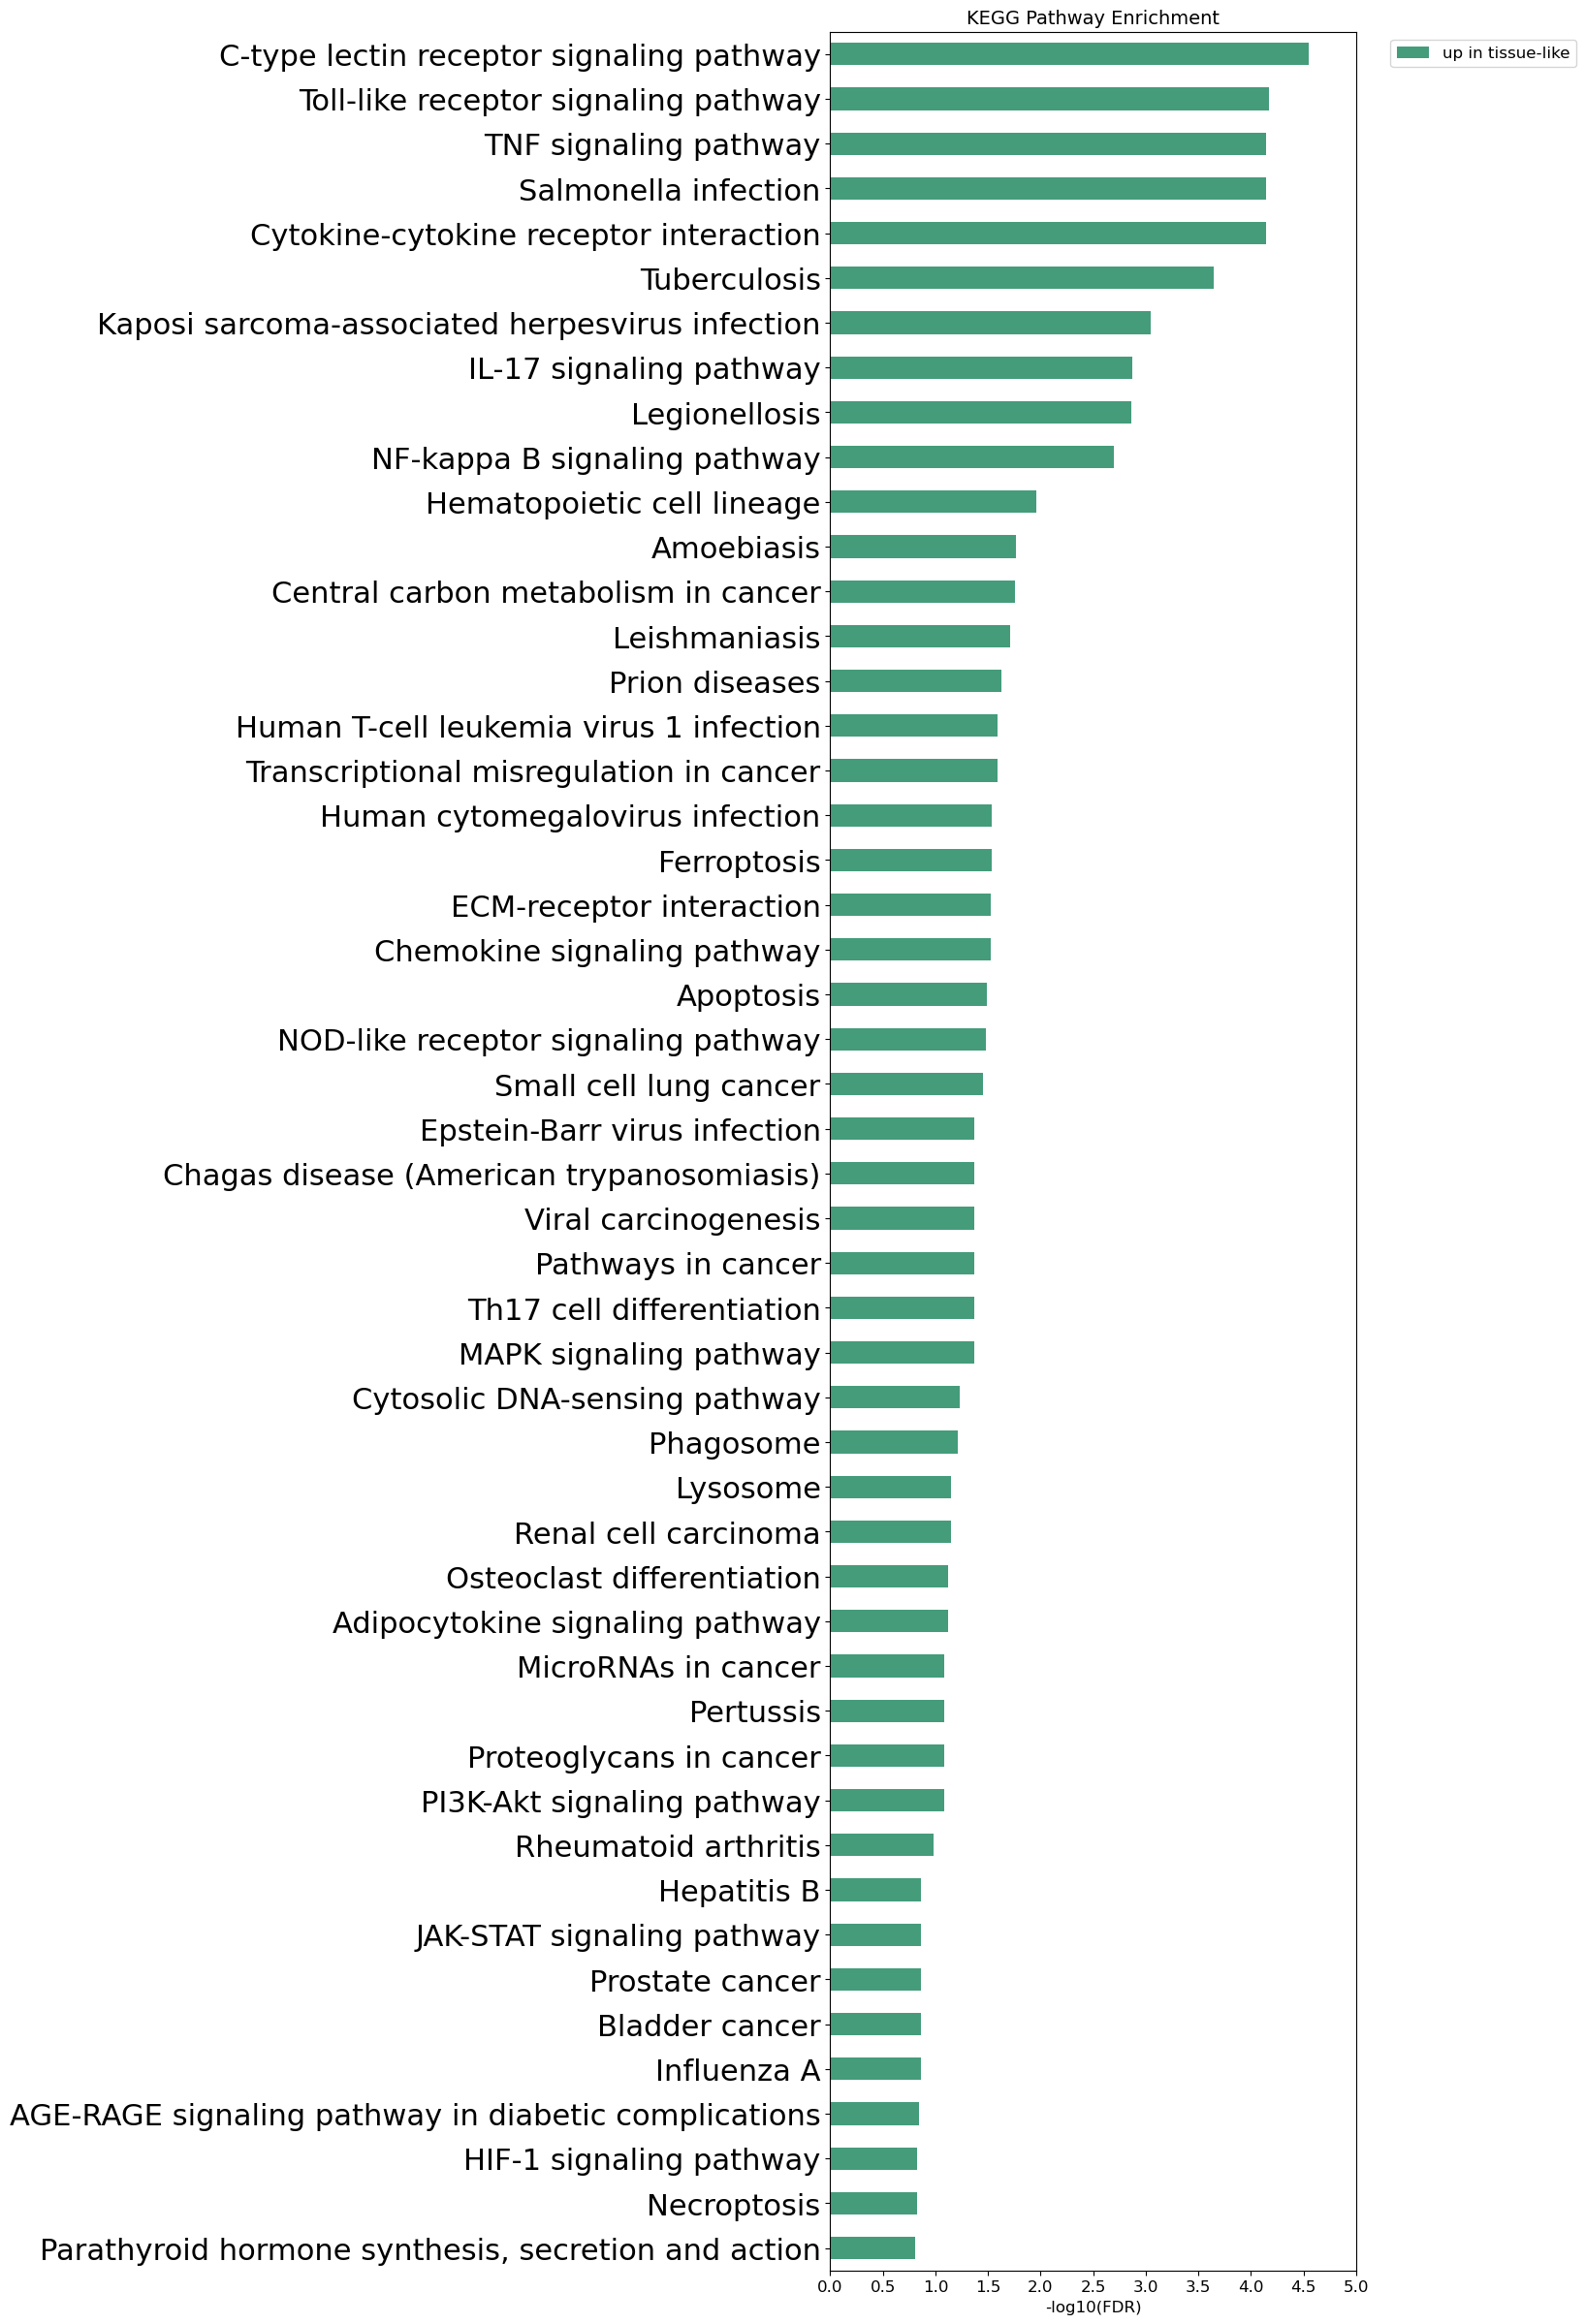

In [94]:
plt.figure(figsize=(7, 30))
ax = sns.barplot(
    data=kegg_up,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    palette=palette
)

# --- make bars thinner but keep them centred on the tick labels ---
new_h = 0.5  # bar thickness you want
for bar in ax.patches:
    old_y = bar.get_y()
    old_h = bar.get_height()
    center = old_y + old_h / 2.0      # current centre of the bar
    bar.set_height(new_h)             # new height
    bar.set_y(center - new_h / 2.0)   # move so centre stays the same
# ------------------------------------------------------------------

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.title("KEGG Pathway Enrichment", fontsize=14)
plt.xlabel("-log10(FDR)", fontsize=12)
plt.ylabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=22)

xmax = ax.get_xlim()[1]
plt.xticks(ticks=np.arange(0, int(np.ceil(xmax)) + 0.1, 0.5), fontsize=12)

plt.show()


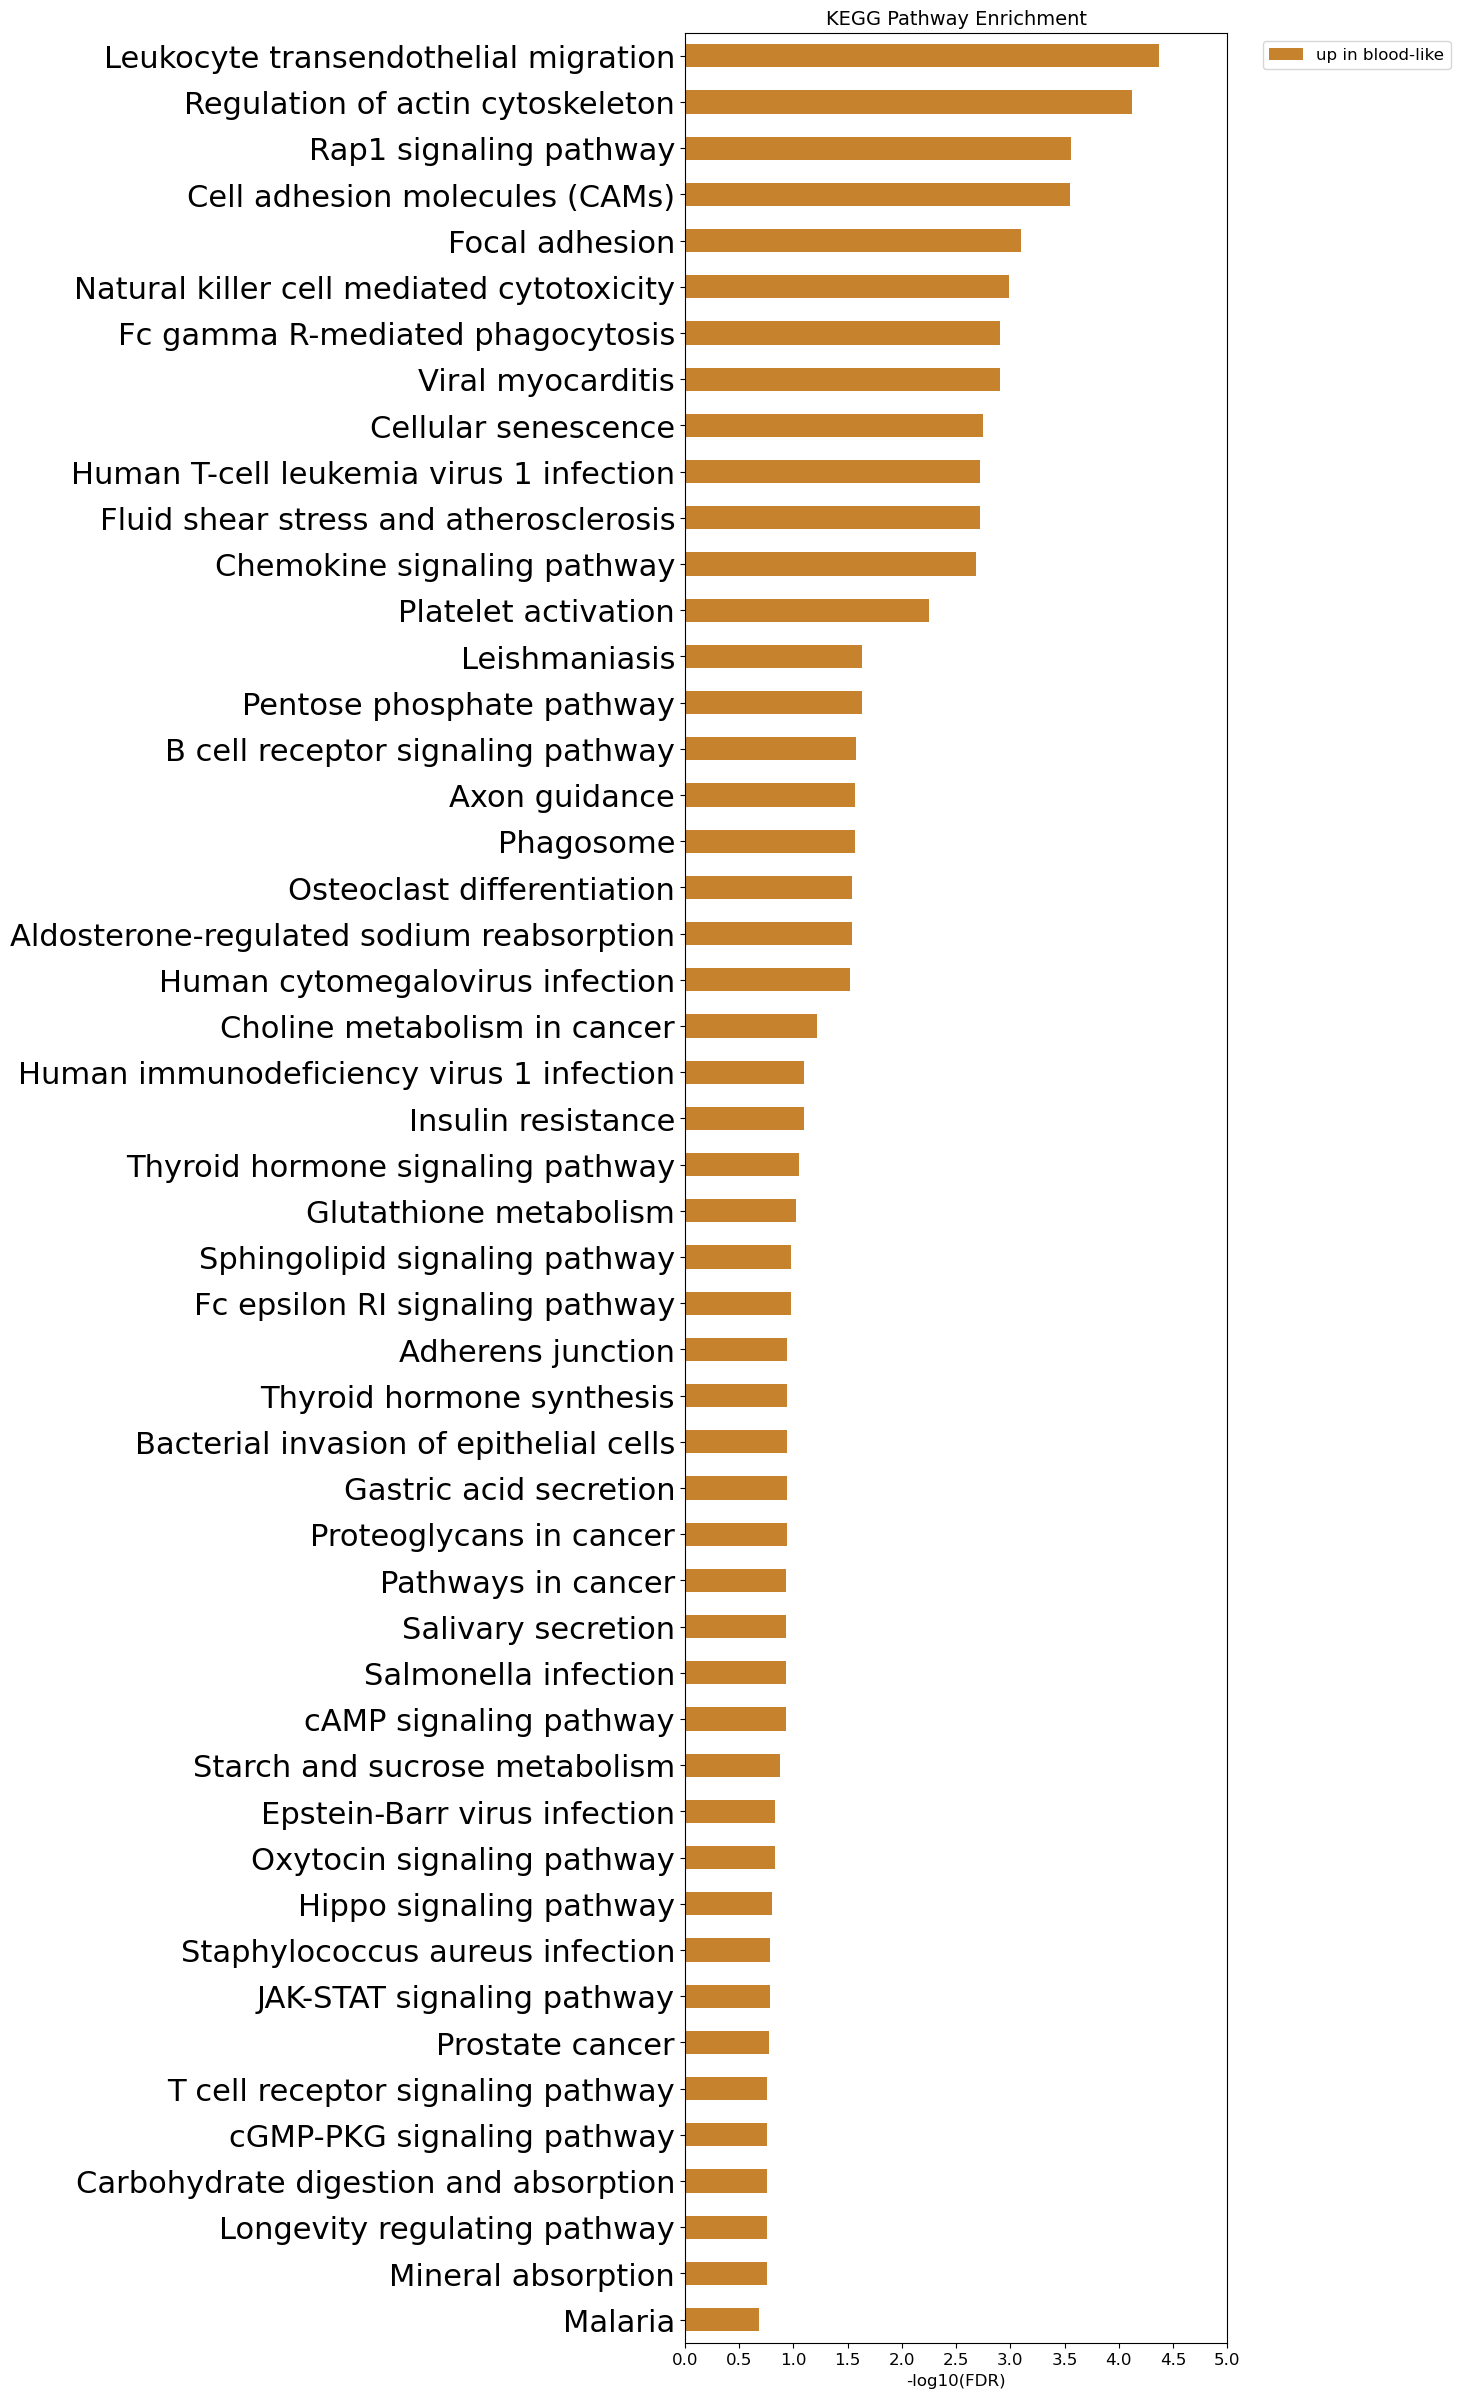

In [95]:
# Plot KEGG
plt.figure(figsize=(7, 30))
ax = sns.barplot(
    data=kegg_dwn,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    palette=palette
)

# --- make bars thinner but keep them centred on the tick labels ---
new_h = 0.5  # bar thickness you want
for bar in ax.patches:
    old_y = bar.get_y()
    old_h = bar.get_height()
    center = old_y + old_h / 2.0      # current centre of the bar
    bar.set_height(new_h)             # new height
    bar.set_y(center - new_h / 2.0)   # move so centre stays the same
# ------------------------------------------------------------------

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.title("KEGG Pathway Enrichment", fontsize=14)
plt.xlabel("-log10(FDR)", fontsize=12)
plt.ylabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=22)

xmax = ax.get_xlim()[1]
plt.xticks(ticks=np.arange(0, int(np.ceil(xmax)) + 0.1, 0.5), fontsize=12)

plt.show()

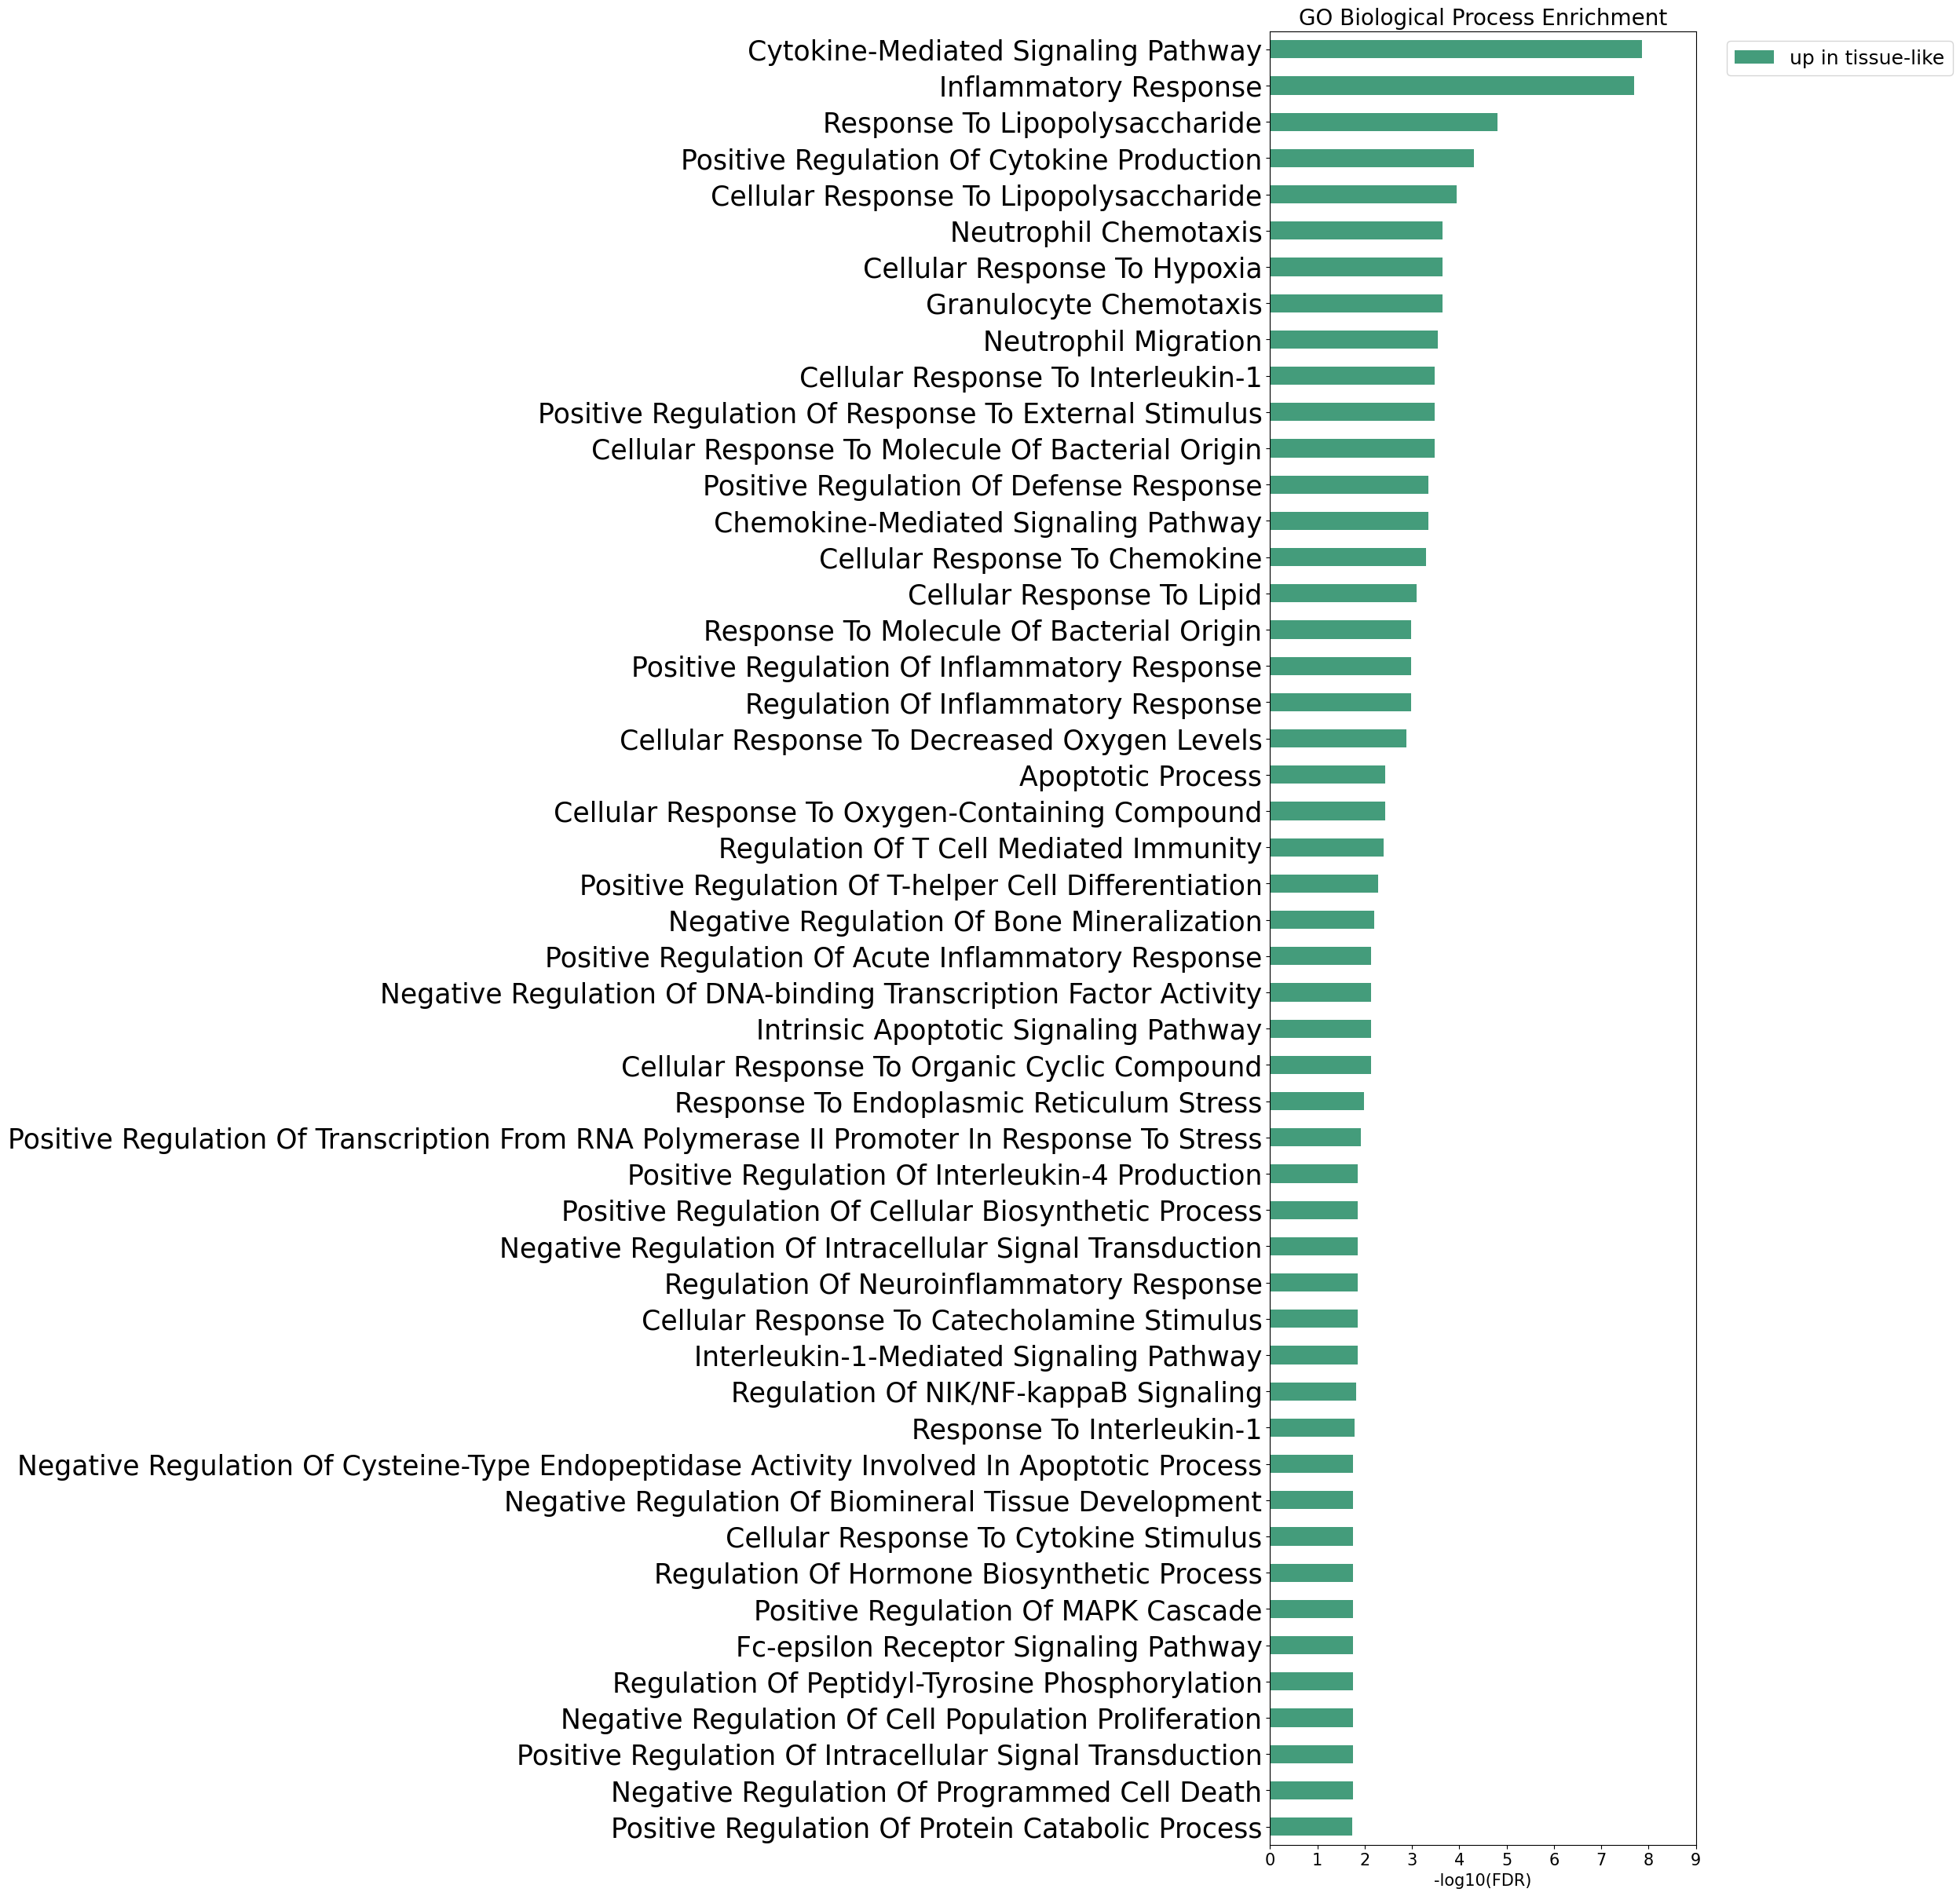

In [103]:
# Plot GO-BP
plt.figure(figsize=(7, 30))
ax = sns.barplot(
    data=go_up,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    palette=palette
)

# --- make bars thinner but keep them centred on the tick labels ---
new_h = 0.5  # bar thickness you want
for bar in ax.patches:
    old_y = bar.get_y()
    old_h = bar.get_height()
    center = old_y + old_h / 2.0      # current centre of the bar
    bar.set_height(new_h)             # new height
    bar.set_y(center - new_h / 2.0)   # move so centre stays the same
# ------------------------------------------------------------------

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18)
plt.title("GO Biological Process Enrichment", fontsize=20)
plt.xlabel("-log10(FDR)", fontsize=15)
plt.ylabel("")
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)

xmax = ax.get_xlim()[1]
plt.xticks(ticks=np.arange(0, int(np.ceil(xmax)) + 0.1, 1), fontsize=15)

plt.show()


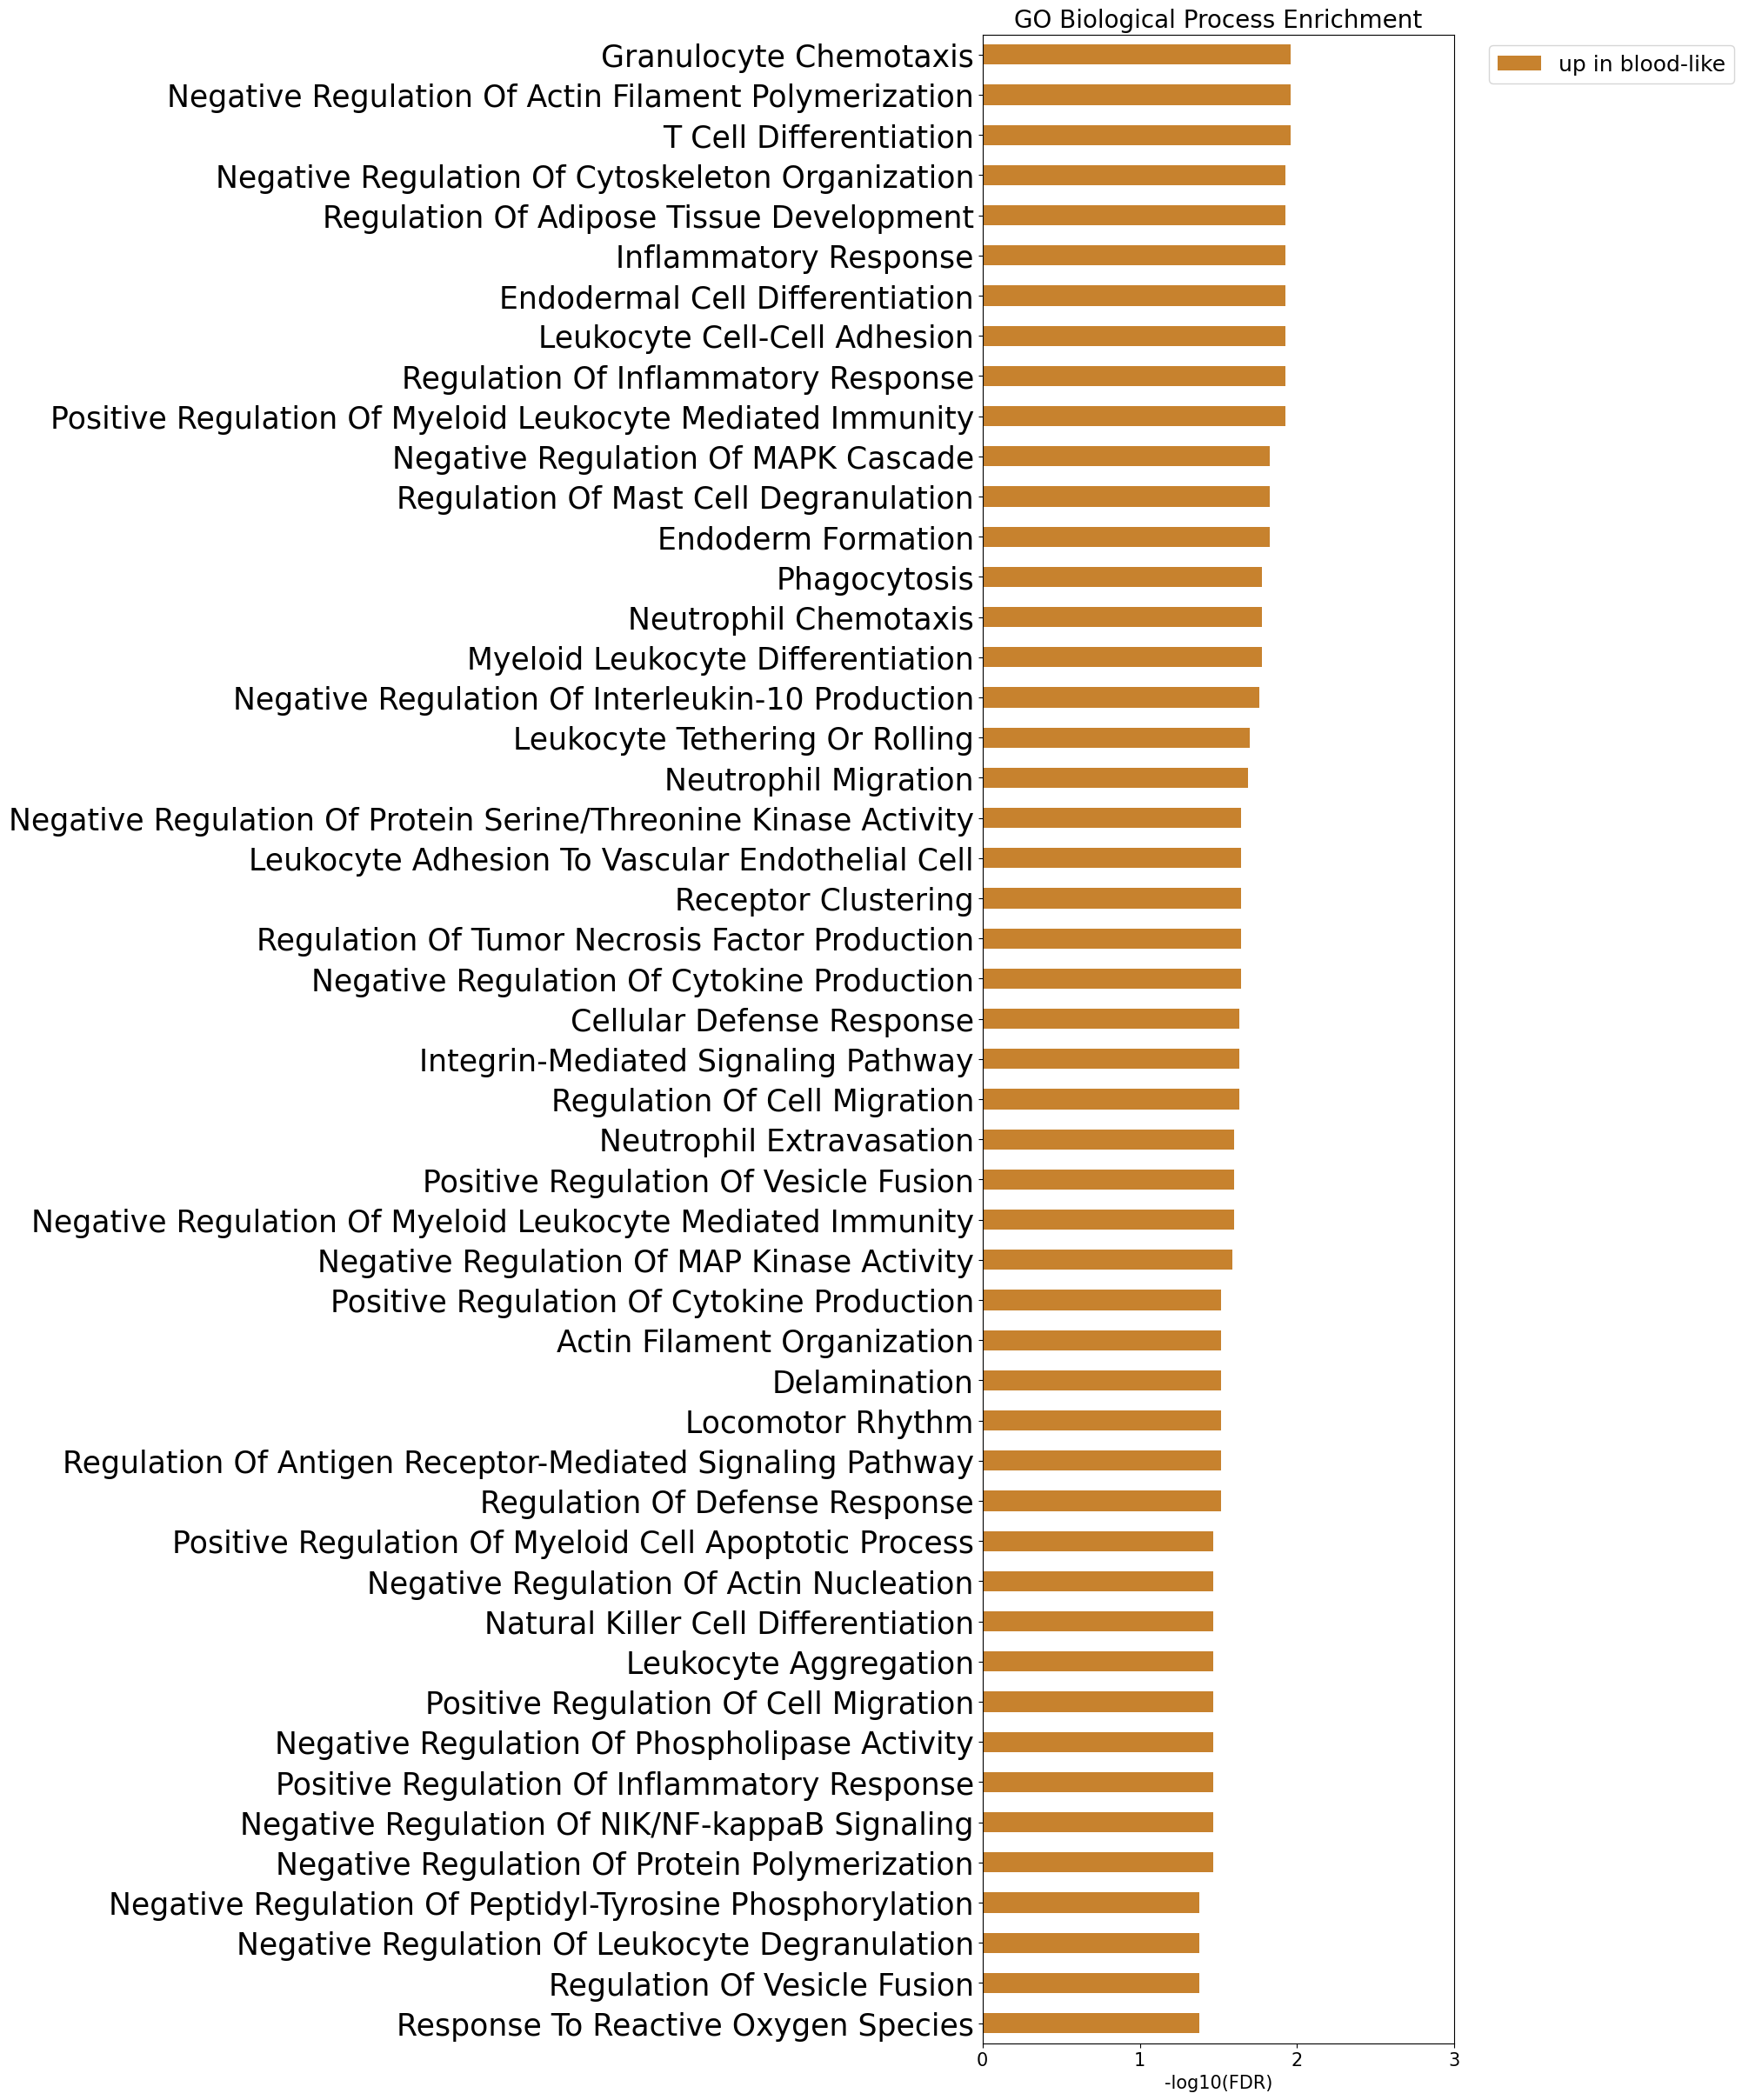

In [104]:
# Plot GO-BP
plt.figure(figsize=(7, 30))
ax = sns.barplot(
    data=go_dwn,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    palette=palette
)

# --- make bars thinner but keep them centred on the tick labels ---
new_h = 0.5  # bar thickness you want
for bar in ax.patches:
    old_y = bar.get_y()
    old_h = bar.get_height()
    center = old_y + old_h / 2.0      # current centre of the bar
    bar.set_height(new_h)             # new height
    bar.set_y(center - new_h / 2.0)   # move so centre stays the same
# ------------------------------------------------------------------

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18)
plt.title("GO Biological Process Enrichment", fontsize=20)
plt.xlabel("-log10(FDR)", fontsize=15)
plt.ylabel("")
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)

xmax = ax.get_xlim()[1]
plt.xticks(ticks=np.arange(0, int(np.ceil(xmax)) + 0.1, 1), fontsize=15)

plt.show()

In [57]:
import re

# List of enriched GO terms exactly as shown in your plot
terms_of_interest = go_dwn["Term"].tolist()

# Filter the full enrichment table to those terms
genes_for_terms = enr_dwn.results[
    enr_dwn.results["Term"].isin(terms_of_interest)
][["Term", "Genes"]].copy()

# Convert comma/semicolon-separated string to list
genes_for_terms["Gene_Hits"] = genes_for_terms["Genes"].apply(
    lambda x: re.split(r"[;,]\s*", x.strip()) if isinstance(x, str) else []
)

# OPTIONAL: intersect with your dataset genes (if you want to make sure they exist in your scRNA-seq)
my_genes = set(upreg.index)  # replace with your full gene list
genes_for_terms["Gene_Hits_in_dataset"] = genes_for_terms["Gene_Hits"].apply(
    lambda lst: [g for g in lst if g in my_genes]
)

# View
for _, row in genes_for_terms.iterrows():
    print(f"{row['Term']}:\n  {', '.join(row['Gene_Hits'])}\n")

# Save to CSV
genes_for_terms.to_csv("bloodlike_up_GO_terms_with_genes.csv", index=False)


In [59]:
# --- your full gene universe (all genes present in the DE result) ---
orig_genes = pd.Index(upreg.index.astype(str))
upper_map = {g.upper(): g for g in orig_genes}      # UPPER -> original
universe_upper = set(upper_map.keys())              # UPPERCASE universe

# --- take the terms you actually plotted (from go_dwn, with cleaned names) ---
terms_of_interest = go_dwn["Term"].tolist()

# --- use go_dwn directly instead of enr_dwn.results ---
tbl = go_dwn.loc[:, ["Term", "Adjusted P-value", "Overlap", "Genes"]].copy()

def split_genes(s):
    if not isinstance(s, str) or not s.strip():
        return []
    return re.split(r"[;,]\s*", s.strip())

# parse, normalize to UPPER, intersect with your universe, then map back to original casing
tbl["Gene_Hits"] = (
    tbl["Genes"]
    .apply(split_genes)
    .apply(lambda lst: [g for g in {g.upper() for g in lst} if g in universe_upper])
    .apply(lambda lst: [upper_map[g] for g in lst])  # back to your original casing
)

# order like your plot (optional but nice)
tbl = tbl.set_index("Term").loc[terms_of_interest].reset_index()

# print nicely
for _, r in tbl.iterrows():
    print(f"{r['Term']}:\n  {', '.join(r['Gene_Hits'])}\n")

# merge with plotting info and save
tbl_out = (
    go_dwn[["Term", "-log10(FDR)", "Condition"]]
    .merge(tbl[["Term", "Adjusted P-value", "Overlap", "Genes", "Gene_Hits"]],
           on="Term", how="left")
)
tbl_out.to_csv("bloodlike_up_GO_terms_with_gene_hits.csv", index=False)


Granulocyte Chemotaxis:
  Anxa1, S100a8, Pik3cd, Itgb2, Jaml, Cxcr2

Negative Regulation Of Actin Filament Polymerization:
  Tmsb4x, Ssh2, Pfn1, Myadm

T Cell Differentiation:
  Anxa1, Pik3cd, Ptprc, Spi1, Zfp36l2

Negative Regulation Of Cytoskeleton Organization:
  Ssh2, Coro1a, Pfn1, Myadm

Regulation Of Adipose Tissue Development:
  Sorl1, Spi1, Lcp1

Inflammatory Response:
  Anxa1, Nfam1, Hp, S100a8, Pik3cd, Itgb2, Adgre5, Itgal, Cxcr2

Endodermal Cell Differentiation:
  Itga4, Mmp9, Itgb2, Mmp8

Leukocyte Cell-Cell Adhesion:
  Itgal, Itga4, Sell, Itgb2

Regulation Of Inflammatory Response:
  Anxa1, Lcp1, Tmsb4x, S100a8, Mmp9, Mmp8, Pla2g7, Akna, Gpsm3

Positive Regulation Of Myeloid Leukocyte Mediated Immunity:
  Tyrobp, Spi1, Itgb2

Negative Regulation Of MAPK Cascade:
  Stk38, Pten, Ptprc, Sorl1, Cd300a, Rgs2

Regulation Of Mast Cell Degranulation:
  Fgr, Cd300a, Fes

Endoderm Formation:
  Itga4, Mmp9, Itgb2, Mmp8

Phagocytosis:
  Bin2, Anxa1, Tyrobp, Itgb2, Coro1a

Neutrophil C

# DEGs between 24hr-neutrophils vs 7day-neutrophils in wound (only in tissue-like)

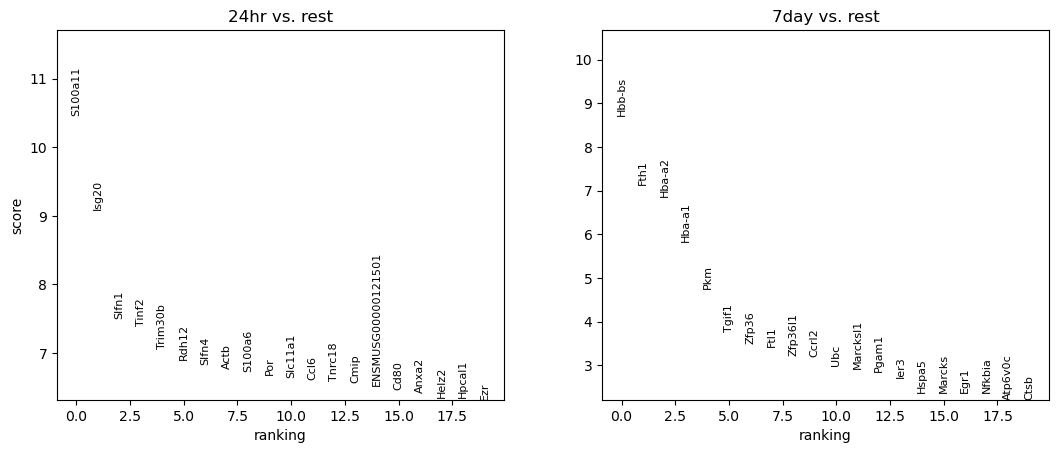

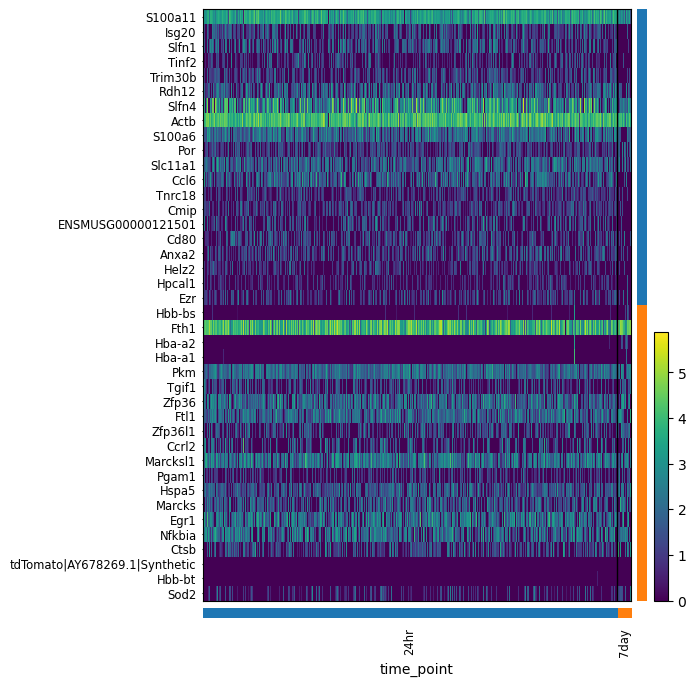

Hbb-bs is supposed to be "up": 24hr 0.014347362332046032, 7 days 0.03328649699687958
    (Up means up in 7 days)
  Print the top genes, to get an idea
    Upregulated at 7 days vs 1 day:
              gene     score          pval      pval_adj     logFC
Hbb-bs      Hbb-bs  8.721365  2.748684e-18  2.311002e-14  6.106547
Fth1          Fth1  7.129452  1.007695e-12  4.236180e-09  0.733635
Hba-a2      Hba-a2  6.867198  6.547503e-12  1.834974e-08  6.166894
Hba-a1      Hba-a1  5.828327  5.598567e-09  3.209379e-06  5.466151
Pkm            Pkm  4.741949  2.116719e-06  4.563249e-04  0.307378
Tgif1        Tgif1  3.764945  1.665859e-04  1.489999e-02  0.771875
Zfp36        Zfp36  3.493342  4.770143e-04  3.314527e-02  0.422171
Ftl1          Ftl1  3.416994  6.331657e-04  4.169801e-02  0.325489
Zfp36l1    Zfp36l1  3.221251  1.276321e-03  7.393876e-02  0.635534
Ccrl2        Ccrl2  3.185415  1.445468e-03  8.120052e-02  0.853885
Ubc            Ubc  2.987411  2.813514e-03  1.351719e-01  0.188637
Marcksl1 

In [61]:
wound_neutro_tl = wound_neutro[wound_neutro.obs["broad_neutro_type"] == "Tissue-like"]
# Double ensure there's no blood of any kind in here, just to keep things clean
wound_neutro_tl = wound_neutro_tl[wound_neutro_tl.obs["time_point"] != "Blood"]

# Perform differential gene expression analysis
sc.tl.rank_genes_groups(wound_neutro_tl, groupby="time_point", method="wilcoxon")

# View the top-ranked genes
sc.pl.rank_genes_groups(wound_neutro_tl, n_genes=20, sharey=False)
sc.pl.rank_genes_groups_heatmap(wound_neutro_tl, n_genes=20, groupby='time_point', swap_axes=True, min_logfoldchange=0.25, dendrogram=False, show_gene_labels=True, figsize=(6, 8))

# Extract results
tmp = wound_neutro_tl.uns['rank_genes_groups']

# Create a DataFrame with gene names, log2 fold change, p-values, and adjusted p-values
upreg = pd.DataFrame(
    index=tmp["names"]["7day"],  
    data={ 'gene': tmp['names']["7day"],
        "score": tmp["scores"]["7day"],
        "pval": tmp["pvals"]["7day"],
        "pval_adj": tmp["pvals_adj"]["7day"],
        "logFC": tmp["logfoldchanges"]["7day"],
    },
)

top_up = upreg.index[0]
x24h = wound_neutro[wound_neutro.obs["time_point"] == "24hr", top_up].X.mean()
x7d = wound_neutro[wound_neutro.obs["time_point"] != "24hr", top_up].X.mean()
print(f'{top_up} is supposed to be "up": 24hr {x24h}, 7 days {x7d}')
print("    (Up means up in 7 days)")

print("  Print the top genes, to get an idea")
print("    Upregulated at 7 days vs 1 day:")
print(upreg.iloc[:20])
print("    Downregulated at 7 days vs 1 day:")
print(upreg.iloc[-20:].iloc[::-1])

upreg.to_csv("24hr vs 7day only ts.csv", index=False)

In [62]:
# Step 1: Find the tdTomato gene name in .var
td_genes = wound_neutro_tl.var_names[
    wound_neutro_tl.var_names.str.contains("tdTomato", regex=False)
]

# Step 2: Exclude these genes from the AnnData object
wound_neutro_tl = wound_neutro_tl[:, ~wound_neutro_tl.var_names.isin(td_genes)]

# Step 3: Now run DE (tdTomato will be fully excluded)
sc.tl.rank_genes_groups(wound_neutro_tl, groupby="time_point", method="wilcoxon")

top_genes_tl = sc.get.rank_genes_groups_df(
    wound_neutro_tl,
    group=None,              # get all groups
    log2fc_min=0.25,         # optional filtering
    pval_cutoff=0.05         # optional filtering
)

In [63]:
wound_neutro.uns['time_point_colors']=["#3cb371","#005aff","#ff7f00"]

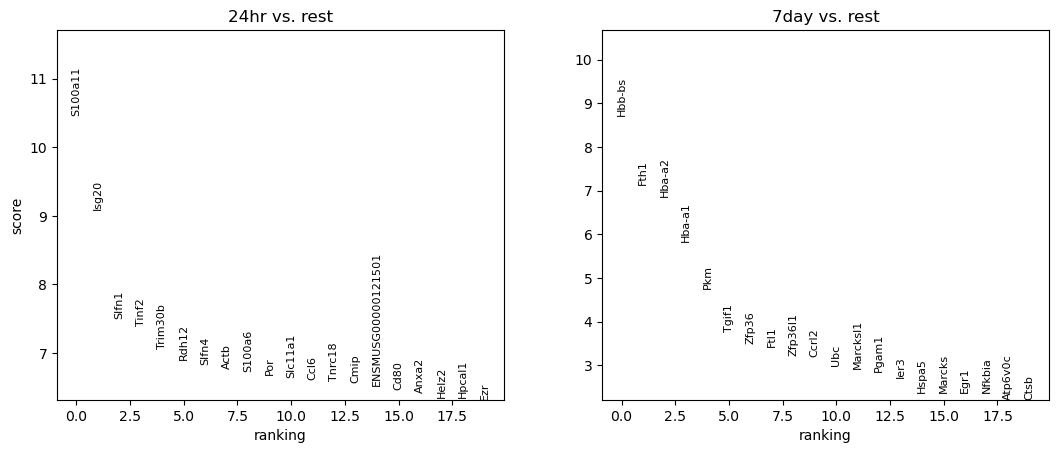

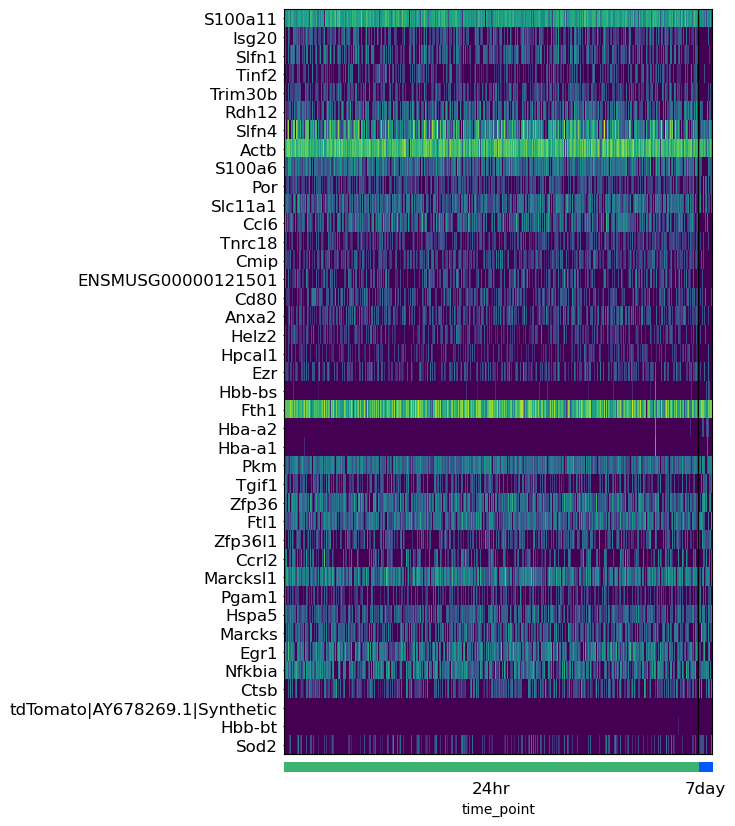

Hbb-bs is supposed to be "up": 24hr 0.014347362332046032, 7 days 0.03328649699687958
    (Up means up in 7 days)
  Print the top genes, to get an idea
    Upregulated at 7 days vs 1 day:
              gene     score          pval      pval_adj     logFC
Hbb-bs      Hbb-bs  8.721365  2.748684e-18  2.311002e-14  6.106547
Fth1          Fth1  7.129452  1.007695e-12  4.236180e-09  0.733635
Hba-a2      Hba-a2  6.867198  6.547503e-12  1.834974e-08  6.166894
Hba-a1      Hba-a1  5.828327  5.598567e-09  3.209379e-06  5.466151
Pkm            Pkm  4.741949  2.116719e-06  4.563249e-04  0.307378
Tgif1        Tgif1  3.764945  1.665859e-04  1.489999e-02  0.771875
Zfp36        Zfp36  3.493342  4.770143e-04  3.314527e-02  0.422171
Ftl1          Ftl1  3.416994  6.331657e-04  4.169801e-02  0.325489
Zfp36l1    Zfp36l1  3.221251  1.276321e-03  7.393876e-02  0.635534
Ccrl2        Ccrl2  3.185415  1.445468e-03  8.120052e-02  0.853885
Ubc            Ubc  2.987411  2.813514e-03  1.351719e-01  0.188637
Marcksl1 

In [64]:
wound_neutro_tl = wound_neutro[wound_neutro.obs["broad_neutro_type"] == "Tissue-like"]
# Double ensure there's no blood of any kind in here, just to keep things clean
wound_neutro_tl = wound_neutro_tl[wound_neutro_tl.obs["time_point"] != "Blood"]

# Perform differential gene expression analysis
sc.tl.rank_genes_groups(wound_neutro_tl, groupby="time_point", method="wilcoxon")

# View the top-ranked genes
sc.pl.rank_genes_groups(wound_neutro_tl, n_genes=20, sharey=False)
sc.pl.rank_genes_groups_heatmap(
    wound_neutro_tl,
    n_genes=20,
    groupby='time_point',
    swap_axes=True,
    min_logfoldchange=0.25,
    dendrogram=False,
    show_gene_labels=True,
    figsize=(6, 10),
    show=False
)
fig=plt.gcf()

#remove colorbar manually
for ax in fig.axes:
    bbox = ax.get_position()
    if bbox.width < 0.02 and bbox.height > 0.3:
        fig.delaxes(ax)

#rotate x-axis labels
for ax in fig.axes:
    if ax.get_xticklabels():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=12)
    if ax.get_ylabel() == '':
        ax.tick_params(axis='y', labelsize=12)
axes = fig.get_axes()
if len(axes) > 1:
    fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

# Extract results
tmp = wound_neutro_tl.uns['rank_genes_groups']

# Create a DataFrame with gene names, log2 fold change, p-values, and adjusted p-values
upreg = pd.DataFrame(
    index=tmp["names"]["7day"],  
    data={ 'gene': tmp['names']["7day"],
        "score": tmp["scores"]["7day"],
        "pval": tmp["pvals"]["7day"],
        "pval_adj": tmp["pvals_adj"]["7day"],
        "logFC": tmp["logfoldchanges"]["7day"],
    },
)

top_up = upreg.index[0]
x24h = wound_neutro[wound_neutro.obs["time_point"] == "24hr", top_up].X.mean()
x7d = wound_neutro[wound_neutro.obs["time_point"] != "24hr", top_up].X.mean()
print(f'{top_up} is supposed to be "up": 24hr {x24h}, 7 days {x7d}')
print("    (Up means up in 7 days)")

print("  Print the top genes, to get an idea")
print("    Upregulated at 7 days vs 1 day:")
print(upreg.iloc[:20])
print("    Downregulated at 7 days vs 1 day:")
print(upreg.iloc[-20:].iloc[::-1])

upreg.to_csv("24hr vs 7day only ts.csv", index=False)

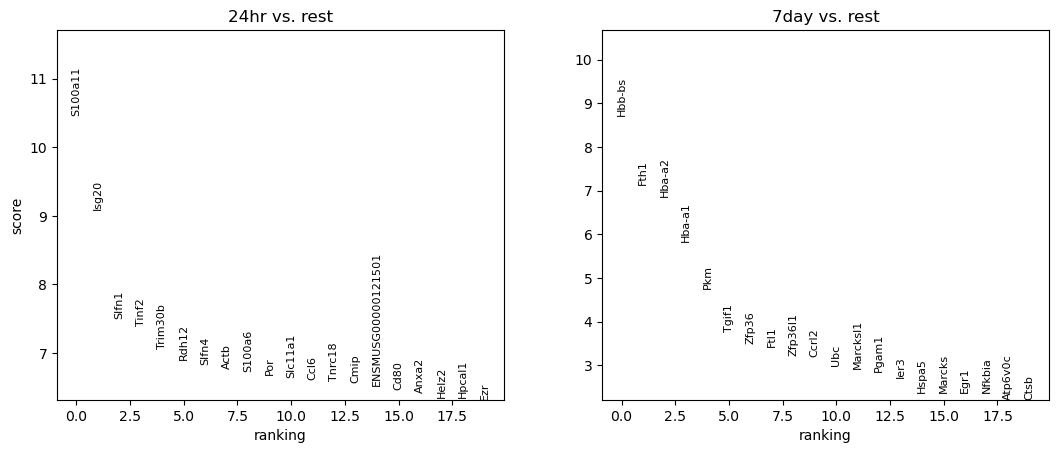

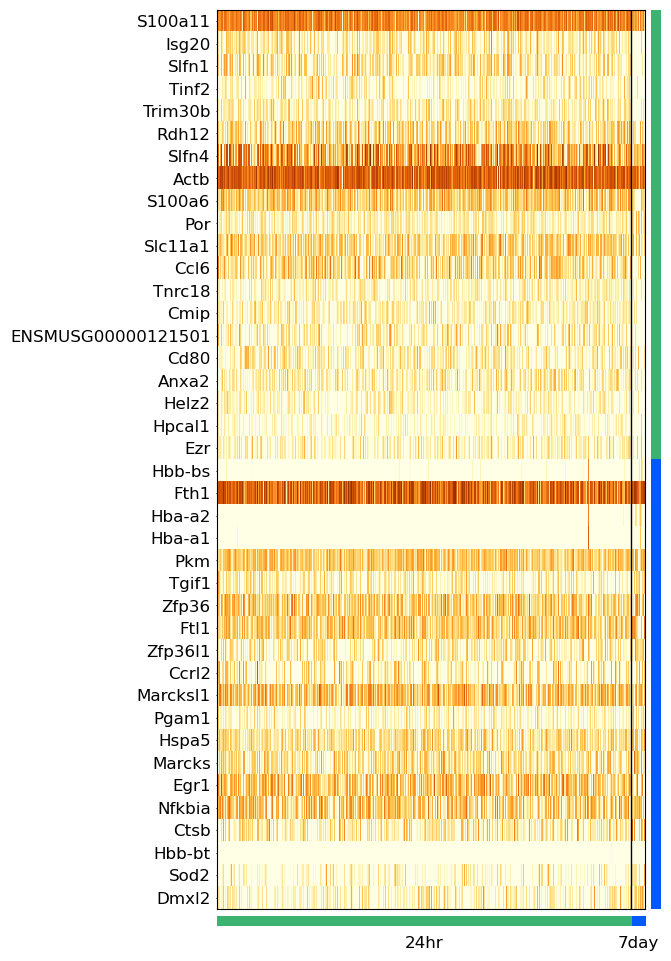

In [65]:
# Step 1: Find the tdTomato gene name in .var
td_genes = wound_neutro_tl.var_names[
    wound_neutro_tl.var_names.str.contains("tdTomato", regex=False)
]

# Step 2: Exclude these genes from the AnnData object
wound_neutro_tl = wound_neutro_tl[:, ~wound_neutro_tl.var_names.isin(td_genes)]

# Step 3: Now run DE (tdTomato will be fully excluded)
sc.tl.rank_genes_groups(wound_neutro_tl, groupby="time_point", method="wilcoxon")

# View the top-ranked genes
sc.pl.rank_genes_groups(wound_neutro_tl, n_genes=20, sharey=False)

# Step 4: Plot as usual

sc.pl.rank_genes_groups_heatmap(
    wound_neutro_tl,
    groupby='time_point',
    n_genes=20,
    swap_axes=True,
    min_logfoldchange=0.25,
    dendrogram=False,
    show_gene_labels=True,
    figsize=(6, 12),
    show=False,
    cmap="YlOrBr",
)
fig=plt.gcf()



#rotate x-axis labels
for ax in fig.axes:
    if ax.get_xticklabels():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=12)
    if ax.get_ylabel() == '':
        ax.tick_params(axis='y', labelsize=12)
    if ax.get_xlabel() == "time_point":
        ax.set_xlabel("")
axes = fig.get_axes()
if len(axes) > 1:
    fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

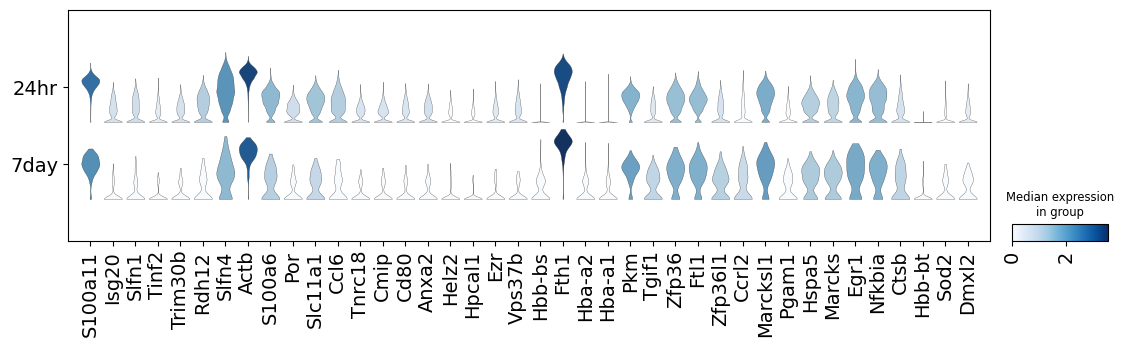

In [66]:
genes_bt_timepoint= ['S100a11','Isg20','Slfn1','Tinf2','Trim30b','Rdh12','Slfn4','Actb','S100a6','Por',
                     'Slc11a1','Ccl6','Tnrc18','Cmip','Cd80','Anxa2','Helz2','Hpcal1','Ezr','Vps37b',
                     'Hbb-bs','Fth1','Hba-a2','Hba-a1','Pkm','Tgif1','Zfp36','Ftl1','Zfp36l1','Ccrl2',
                     'Marcksl1','Pgam1','Hspa5','Marcks','Egr1','Nfkbia','Ctsb','Hbb-bt','Sod2','Dmxl2']


sc.pl.stacked_violin(
    wound_neutro_tl,
    var_names=genes_bt_timepoint,
    groupby="time_point",
    swap_axes=False,
    standard_scale=None,
    figsize=(16, 3),
    dendrogram=False,
    show=False
)
fig = plt.gcf()
for ax in fig.axes:
    if ax.get_xticklabels():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=14)
    if ax.get_ylabel() == '':
        ax.tick_params(axis='y', labelsize=14)  # adjust as needed
plt.subplots_adjust(left=0.3, right=0.95)  # extra: more margin for gene names
plt.show()

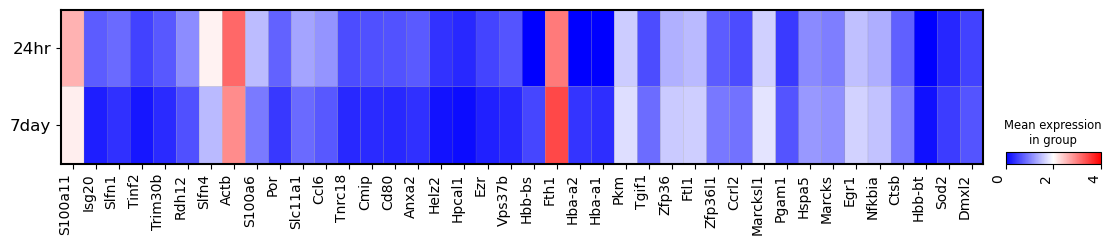

In [67]:
genes_bt_timepoint= ['S100a11','Isg20','Slfn1','Tinf2','Trim30b','Rdh12','Slfn4','Actb','S100a6','Por',
                     'Slc11a1','Ccl6','Tnrc18','Cmip','Cd80','Anxa2','Helz2','Hpcal1','Ezr','Vps37b',
                     'Hbb-bs','Fth1','Hba-a2','Hba-a1','Pkm','Tgif1','Zfp36','Ftl1','Zfp36l1','Ccrl2',
                     'Marcksl1','Pgam1','Hspa5','Marcks','Egr1','Nfkbia','Ctsb','Hbb-bt','Sod2','Dmxl2']
sc.pl.matrixplot(
    wound_neutro_tl,
    var_names=genes_bt_timepoint,
    groupby="time_point",
    swap_axes=False,
    cmap='bwr',
    standard_scale=None,
    vmin=0,
    vmax=5,
    figsize=(16,2),
    dendrogram=False,
    show=False
)
fig = plt.gcf()
for ax in fig.axes:
    if ax.get_xticklabels():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=10)
    if ax.get_ylabel() == '':
        ax.tick_params(axis='y', labelsize=12)
plt.subplots_adjust(left=0.3, right=0.95) 
plt.show()

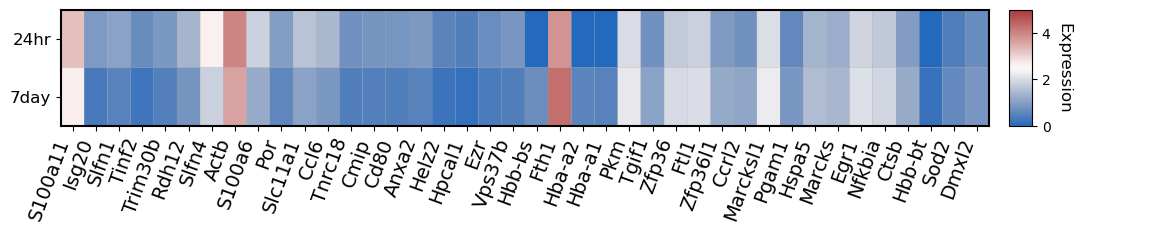

In [68]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scanpy as sc

# Generate matrixplot without showing
sc.pl.matrixplot(
    wound_neutro_tl,
    var_names=genes_bt_timepoint,
    groupby="time_point",
    swap_axes=False,
    cmap='vlag',
    standard_scale=None,
    vmin=0,
    vmax=5,
    figsize=(18, 2),
    dendrogram=False,
    show=False
)

# Get the figure object
fig = plt.gcf()

# ---- STEP 1: Remove the original colorbar ----
# Keep only the main axes (remove the default colorbar axis)
# We assume colorbar is the last axis in fig.axes
if len(fig.axes) > 1:
    fig.delaxes(fig.axes[-1])  # removes Scanpy's colorbar

# ---- STEP 2: Format the main axis ----
main_ax = fig.axes[0]
main_ax.set_xticklabels(main_ax.get_xticklabels(), rotation=70, ha='right', fontsize=14)
main_ax.tick_params(axis='y', labelsize=12)

# ---- STEP 3: Add a clean vertical colorbar ----
divider = make_axes_locatable(main_ax)
cbar_ax = divider.append_axes("right", size="2.5%", pad=0.2)

norm = mpl.colors.Normalize(vmin=0, vmax=5)
cbar = mpl.colorbar.ColorbarBase(
    cbar_ax,
    cmap='vlag',
    norm=norm,
    orientation='vertical'
)

cbar.ax.tick_params(labelsize=10)
cbar.set_label("Expression", fontsize=12, rotation=270, labelpad=15)

# ---- STEP 4: Adjust layout ----
plt.subplots_adjust(left=0.3, right=0.9, bottom=0.3)
plt.show()

In [79]:
# Extract DGE results from Scanpy
result = wound_neutro_tl.uns['rank_genes_groups']
group = '24hr'  # Replace with your comparison group if different

# Create DataFrame for the selected group
deg_df = pd.DataFrame({
    'gene': result['names'][group],
    'logfc': result['logfoldchanges'][group],
    'pval_adj': result['pvals_adj'][group]
})

# Set thresholds
logfc_thresh = 0.25
pval_thresh = 0.05

# Get upregulated and downregulated genes (based on raw p-value)
upregulated = deg_df[(deg_df['logfc'] > logfc_thresh) & (deg_df['pval_adj'] < pval_thresh)]
downregulated = deg_df[(deg_df['logfc'] < -logfc_thresh) & (deg_df['pval_adj'] < pval_thresh)]

# Output counts
print("Number of upregulated genes:", len(upregulated))
print("Number of downregulated genes:", len(downregulated))

# Display first few genes and their p-values
print("\nUpregulated genes (top 20):")
print(upregulated[['gene', 'logfc', 'pval_adj']].head(20))

print("\nDownregulated genes (top 20):")
print(downregulated[['gene', 'logfc', 'pval_adj']].head(20))


Number of upregulated genes: 387
Number of downregulated genes: 8

Upregulated genes (top 20):
                  gene     logfc      pval_adj
0              S100a11  0.908416  3.186516e-21
1                Isg20  2.109642  1.252515e-15
2                Slfn1  1.614210  4.237307e-10
3                Tinf2  1.907973  7.061136e-10
4              Trim30b  1.403249  6.036007e-09
5                Rdh12  1.302937  1.649290e-08
6                Slfn4  1.285667  2.227954e-08
7                 Actb  0.531687  2.908015e-08
8               S100a6  1.190325  3.661817e-08
9                  Por  1.141168  4.328950e-08
10             Slc11a1  1.132896  5.855546e-08
11                Ccl6  1.244922  6.342569e-08
12              Tnrc18  1.251555  6.432350e-08
13                Cmip  1.204641  7.346768e-08
14  ENSMUSG00000121501  1.666542  9.447817e-08
15                Cd80  1.308159  1.374475e-07
16               Anxa2  1.206729  1.674099e-07
17               Helz2  1.619648  2.510719e-07
18          

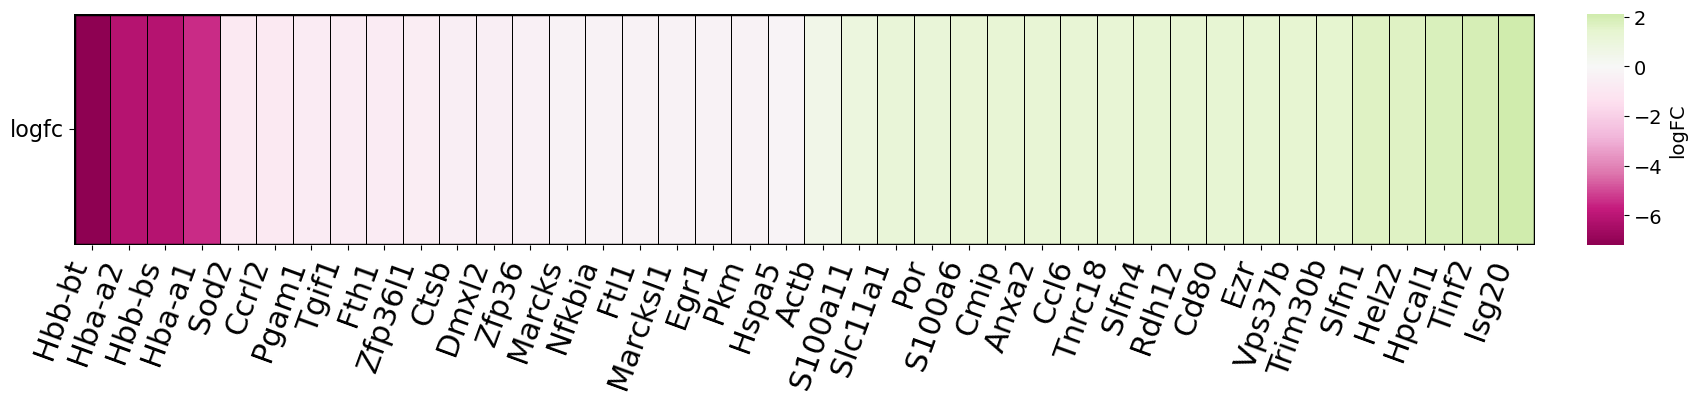

In [80]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
# Prepare heatmap data
heatmap_df = deg_df[deg_df['gene'].isin(genes_bt_timepoint)].sort_values(by='logfc')
heatmap_df = heatmap_df.set_index('gene')[['logfc']].T  # Transpose

# Create annotation array
annot_array = np.round(heatmap_df.values, 2).astype(str)

# --- Create the figure layout ---
#fig_height = max(6, len(heatmap_df) * 0.5)
fig = plt.figure(figsize=(20,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[40, 1], wspace=0.07)

# --- Main plot (heatmap) ---
ax = plt.subplot(gs[0])
cbar_ax = plt.subplot(gs[1])  # Custom axis for colorbar

# --- Plot heatmap with custom colorbar axis ---
sns.heatmap(
    heatmap_df,
    ax=ax,
    cbar_ax=cbar_ax,
    cmap='PiYG',
    center=0,
    annot=False,
    linewidth=0.7,
    linecolor='black',
    cbar_kws={
        'label': 'logFC',
        #'shrink': 0.5,
        #'aspect': 8
    }
)
# --- Add a frame (rectangle) around the heatmap ---
# Get axis limits
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()

# Draw rectangle (inset by 0.5 to align with heatmap grid lines)
rect = Rectangle(
    (x0, y0),             # bottom-left corner
    x1 - x0,              # width
    y1 - y0,              # height
    fill=False,
    color='black',
    linewidth=2.5
)
ax.add_patch(rect)
# --- Format colorbar ---
cbar_ax.tick_params(labelsize=14)
cbar_ax.yaxis.label.set_size(14)

# --- Style main heatmap ---
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=22, rotation=70, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16, rotation=0)

plt.tight_layout()
plt.show()


In [38]:
print("  Pathway analysis within tissue-like neutros")
dwn_genes = upreg.loc[upreg["score"] < 0].index[::-1][:150]
up_genes = upreg.loc[upreg["score"] > 0].index[:150]
print("  Downregulated at 7 days")
enr_dwn = gp.enrichr(
    gene_list=list(dwn_genes),
    gene_sets=["KEGG_2019_Mouse", "GO_Biological_Process_2023"],
    organism="mouse",
    outdir=None,
)
print("  Upregulated at 7 days")
enr_up = gp.enrichr(
    gene_list=list(up_genes),
    gene_sets=["KEGG_2019_Mouse", "GO_Biological_Process_2023"],
    organism="mouse",
    outdir=None,
)
dwn_pathways = enr_dwn.results.query(
    "Gene_set == 'GO_Biological_Process_2023'"
).nsmallest(10, "Adjusted P-value")
dwn_pathways = dwn_pathways.loc[dwn_pathways["Adjusted P-value"] < 0.05]

up_pathways = enr_up.results.query(
    "Gene_set == 'GO_Biological_Process_2023'"
).nsmallest(10, "Adjusted P-value")
up_pathways = up_pathways.loc[up_pathways["Adjusted P-value"] < 0.05]


  Pathway analysis within tissue-like neutros
  Downregulated at 7 days
  Upregulated at 7 days


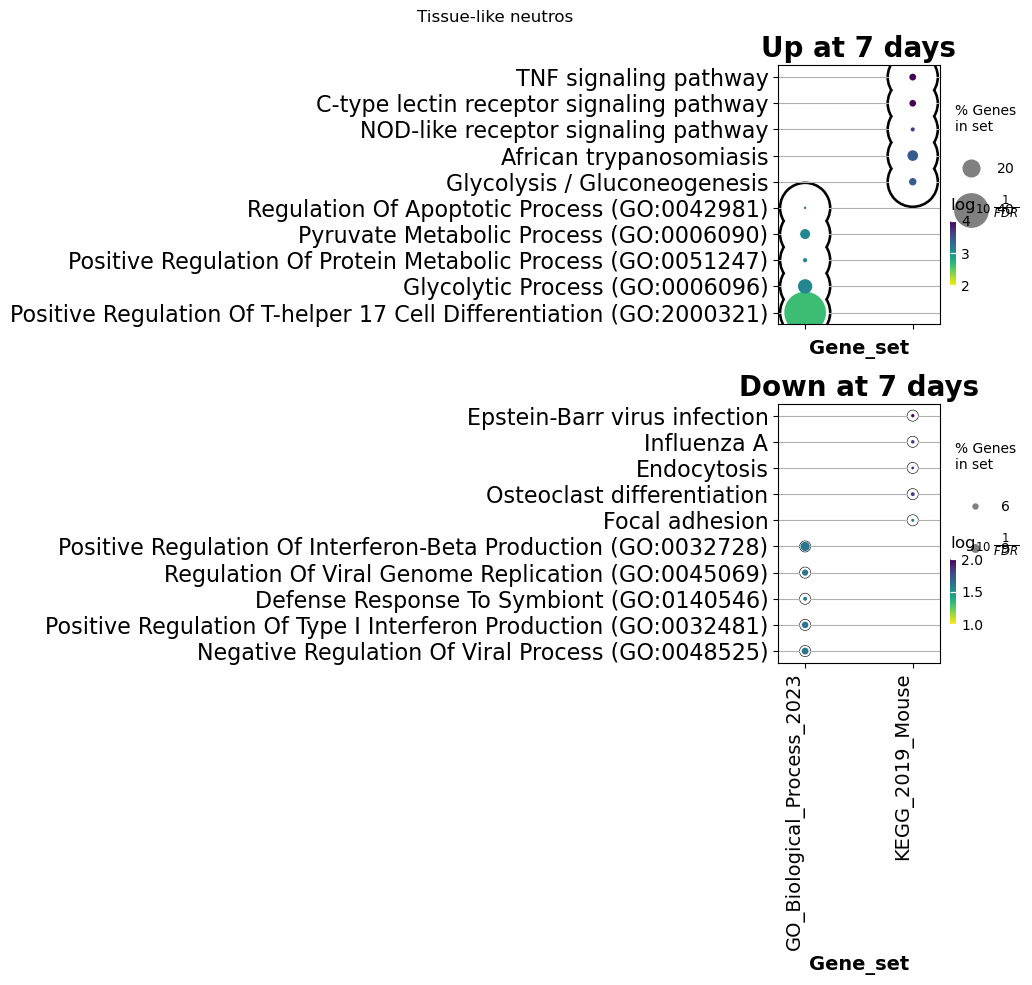

In [39]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
gp.dotplot(
    enr_up.results,
    column="Adjusted P-value",
    x="Gene_set",
    size=10,
    top_term=5,
    figsize=(3, 5),
    title="Up at 7 days",
    xticklabels_rot=90,  # rotate xtick labels
    show_ring=True,
    marker="o",
    ax=axs[0],
)
gp.dotplot(
    enr_dwn.results,
    column="Adjusted P-value",
    x="Gene_set",  # set x axis, so you could do a multi-sample/library comparsion
    size=10,
    top_term=5,
    figsize=(3, 5),
    title="Down at 7 days",
    xticklabels_rot=90,
    show_ring=True,
    marker="o",
    ax=axs[1],
)
axs[0].set(xticklabels=[])
fig.suptitle("Tissue-like neutros")
fig.tight_layout()

In [383]:
print("  Pathway analysis within tissue-like neutros")
dwn_genes = upreg.loc[upreg["score"] < 0].index[::-1][:200]
up_genes = upreg.loc[upreg["score"] > 0].index[:200]


print("Downregulated at 7 days")
enr_dwn = gp.enrichr(
    gene_list=list(dwn_genes),
    gene_sets=["KEGG_2019_Mouse", "GO_Biological_Process_2023"],
    organism="mouse",
    outdir=None,
)

print("Upregulated at 7 days")
enr_up = gp.enrichr(
    gene_list=list(up_genes),
    gene_sets=["KEGG_2019_Mouse", "GO_Biological_Process_2023"],
    organism="mouse",
    outdir=None,
)


print("Gene sets in enrichment results:")
print(enr_up.results["Gene_set"].unique())

def extract_pathways(enr_result, gene_set_name, label, top_n=5, min_log10_fdr=2):
    df = enr_result.results.copy()
    df = df[df["Gene_set"] == gene_set_name]
    df["-log10(FDR)"] = -np.log10(df["Adjusted P-value"])
    df = df[df["-log10(FDR)"] >= min_log10_fdr]
    df = df.nsmallest(top_n, "Adjusted P-value")
    df["Condition"] = label
    return df

# KEGG
kegg_up = extract_pathways(enr_up, "KEGG_2019_Mouse", "up at 7day")
kegg_dwn = extract_pathways(enr_dwn, "KEGG_2019_Mouse", "up at 24hr")

# GO-BP
go_up = extract_pathways(enr_up, "GO_Biological_Process_2023", "up at 7day")
go_dwn = extract_pathways(enr_dwn, "GO_Biological_Process_2023", "up at 24hr")

# Convert Overlap to numeric count
for df in [kegg_up, kegg_dwn, go_up, go_dwn]:
    df["Overlap"] = df["Overlap"].apply(lambda x: int(x.split("/")[0]))

  Pathway analysis within tissue-like neutros
Downregulated at 7 days
Upregulated at 7 days
Gene sets in enrichment results:
['KEGG_2019_Mouse' 'GO_Biological_Process_2023']


In [376]:
# Sort KEGG results by significance for consistent plotting
kegg_up = kegg_up.sort_values("-log10(FDR)", ascending=False)
kegg_dwn = kegg_dwn.sort_values("-log10(FDR)", ascending=False)

# Set y-axis order to match sorting
kegg_up["Term"] = pd.Categorical(kegg_up["Term"], categories=kegg_up["Term"].unique()[::-1], ordered=True)
kegg_dwn = kegg_dwn.dropna(subset=["Term"])
kegg_dwn["Term"] = pd.Categorical(
    kegg_dwn["Term"], 
    categories=kegg_dwn["Term"].unique()[::-1], 
    ordered=True
)
palette = {"up at 7day": "#005aff", "up at 24hr": "#3cb371"}


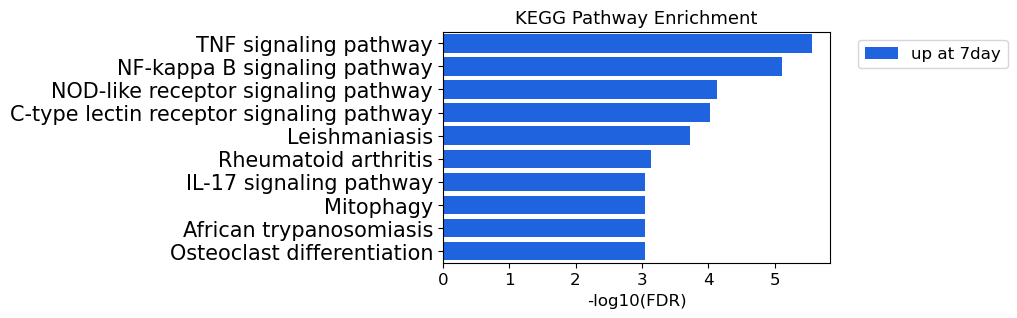

In [377]:
# Plot KEGG
plt.figure(figsize=(5,3))
sns.barplot(
    data=kegg_up,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    #size="Overlap",
    #sizes=(50, 200),
    #legend="full",
    palette=palette,
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.title("KEGG Pathway Enrichment", fontsize=13)
plt.xlabel("-log10(FDR)", fontsize=12)
plt.ylabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
# Adjust horizontal alignment manually
#for label in plt.gca().get_yticklabels():
    #label.set_horizontalalignment("right")  # or "left", "right"
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [378]:
# Plot KEGG
plt.figure(figsize=(5,3))
sns.barplot(
    data=kegg_dwn,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    #size="Overlap",
    #sizes=(50, 200),
    #legend="full",
    palette=palette,
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.title("KEGG Pathway Enrichment", fontsize=13)
plt.xlabel("-log10(FDR)", fontsize=12)
plt.ylabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
# Adjust horizontal alignment manually
#for label in plt.gca().get_yticklabels():
    #label.set_horizontalalignment("right")  # or "left", "right"
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

ValueError: min() arg is an empty sequence

<Figure size 500x300 with 0 Axes>

In [379]:
# Sort GO-BP results by significance for consistent plotting
go_up = go_up.sort_values("-log10(FDR)", ascending=False)
go_dwn = go_dwn.sort_values("-log10(FDR)", ascending=False)

# Set y-axis order to match sorting
go_up["Term"] = pd.Categorical(go_up["Term"], categories=go_up["Term"].unique()[::-1], ordered=True)
go_dwn["Term"] = pd.Categorical(go_dwn["Term"], categories=go_dwn["Term"].unique()[::-1], ordered=True)


In [380]:
# Plot GO-BP
plt.figure(figsize=(5, 5))
sns.barplot(
    data=go_up,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    #size="Overlap",
    #sizes=(50, 200),
    #legend="full",
    palette=palette,
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18, title_fontsize=18)
plt.title("GO Biological Process Enrichment", fontsize=22)
plt.xlabel("-log10(FDR)", fontsize=18)
plt.ylabel("")
plt.xticks(fontsize=22)
plt.yticks(fontsize=26)
plt.gca().invert_yaxis()
#plt.tight_layout()
# Force integer x-ticks
import numpy as np
xmax = plt.gca().get_xlim()[1]
plt.xticks(ticks=np.arange(0, int(np.ceil(xmax)) + 1, 1), fontsize=22)
plt.show()

ValueError: min() arg is an empty sequence

<Figure size 500x500 with 0 Axes>

In [381]:
# Plot GO-BP
plt.figure(figsize=(5, 5))
sns.barplot(
    data=go_dwn,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    #size="Overlap",
    #sizes=(50, 200),
    #legend="full",
    palette=palette,
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18, title_fontsize=18)
plt.title("GO Biological Process Enrichment", fontsize=22)
plt.xlabel("-log10(FDR)", fontsize=18)
plt.ylabel("")
plt.xticks(fontsize=22)
plt.yticks(fontsize=26)
plt.gca().invert_yaxis()
#plt.tight_layout()
# Force integer x-ticks
import numpy as np
xmax = plt.gca().get_xlim()[1]
plt.xticks(ticks=np.arange(0, int(np.ceil(xmax)) + 1, 1), fontsize=22)
plt.show()

ValueError: min() arg is an empty sequence

<Figure size 500x500 with 0 Axes>

In [140]:
print(enr_dwn.results[enr_dwn.results["Gene_set"] == "KEGG_2019_Mouse"].sort_values("Adjusted P-value").head(15))

           Gene_set                                             Term Overlap  \
0   KEGG_2019_Mouse                     Epstein-Barr virus infection   9/229   
1   KEGG_2019_Mouse                                      Endocytosis   9/269   
2   KEGG_2019_Mouse                                      Influenza A   7/168   
3   KEGG_2019_Mouse                       Osteoclast differentiation   6/128   
4   KEGG_2019_Mouse                                   Focal adhesion   7/199   
5   KEGG_2019_Mouse         Human immunodeficiency virus 1 infection   7/238   
6   KEGG_2019_Mouse                                        Phagosome   6/180   
7   KEGG_2019_Mouse                             Salmonella infection    4/78   
8   KEGG_2019_Mouse           Fluid shear stress and atherosclerosis   5/143   
10  KEGG_2019_Mouse                 Regulation of actin cytoskeleton   6/217   
9   KEGG_2019_Mouse  Kaposi sarcoma-associated herpesvirus infection   6/216   
11  KEGG_2019_Mouse             Toll-lik

In [141]:
print("Average score of up_genes:", upreg.loc[up_genes, "score"].mean())  # should be > 0
print("Average score of dwn_genes:", upreg.loc[dwn_genes, "score"].mean())  # should be < 0

Average score of up_genes: 1.3789697
Average score of dwn_genes: -5.419165


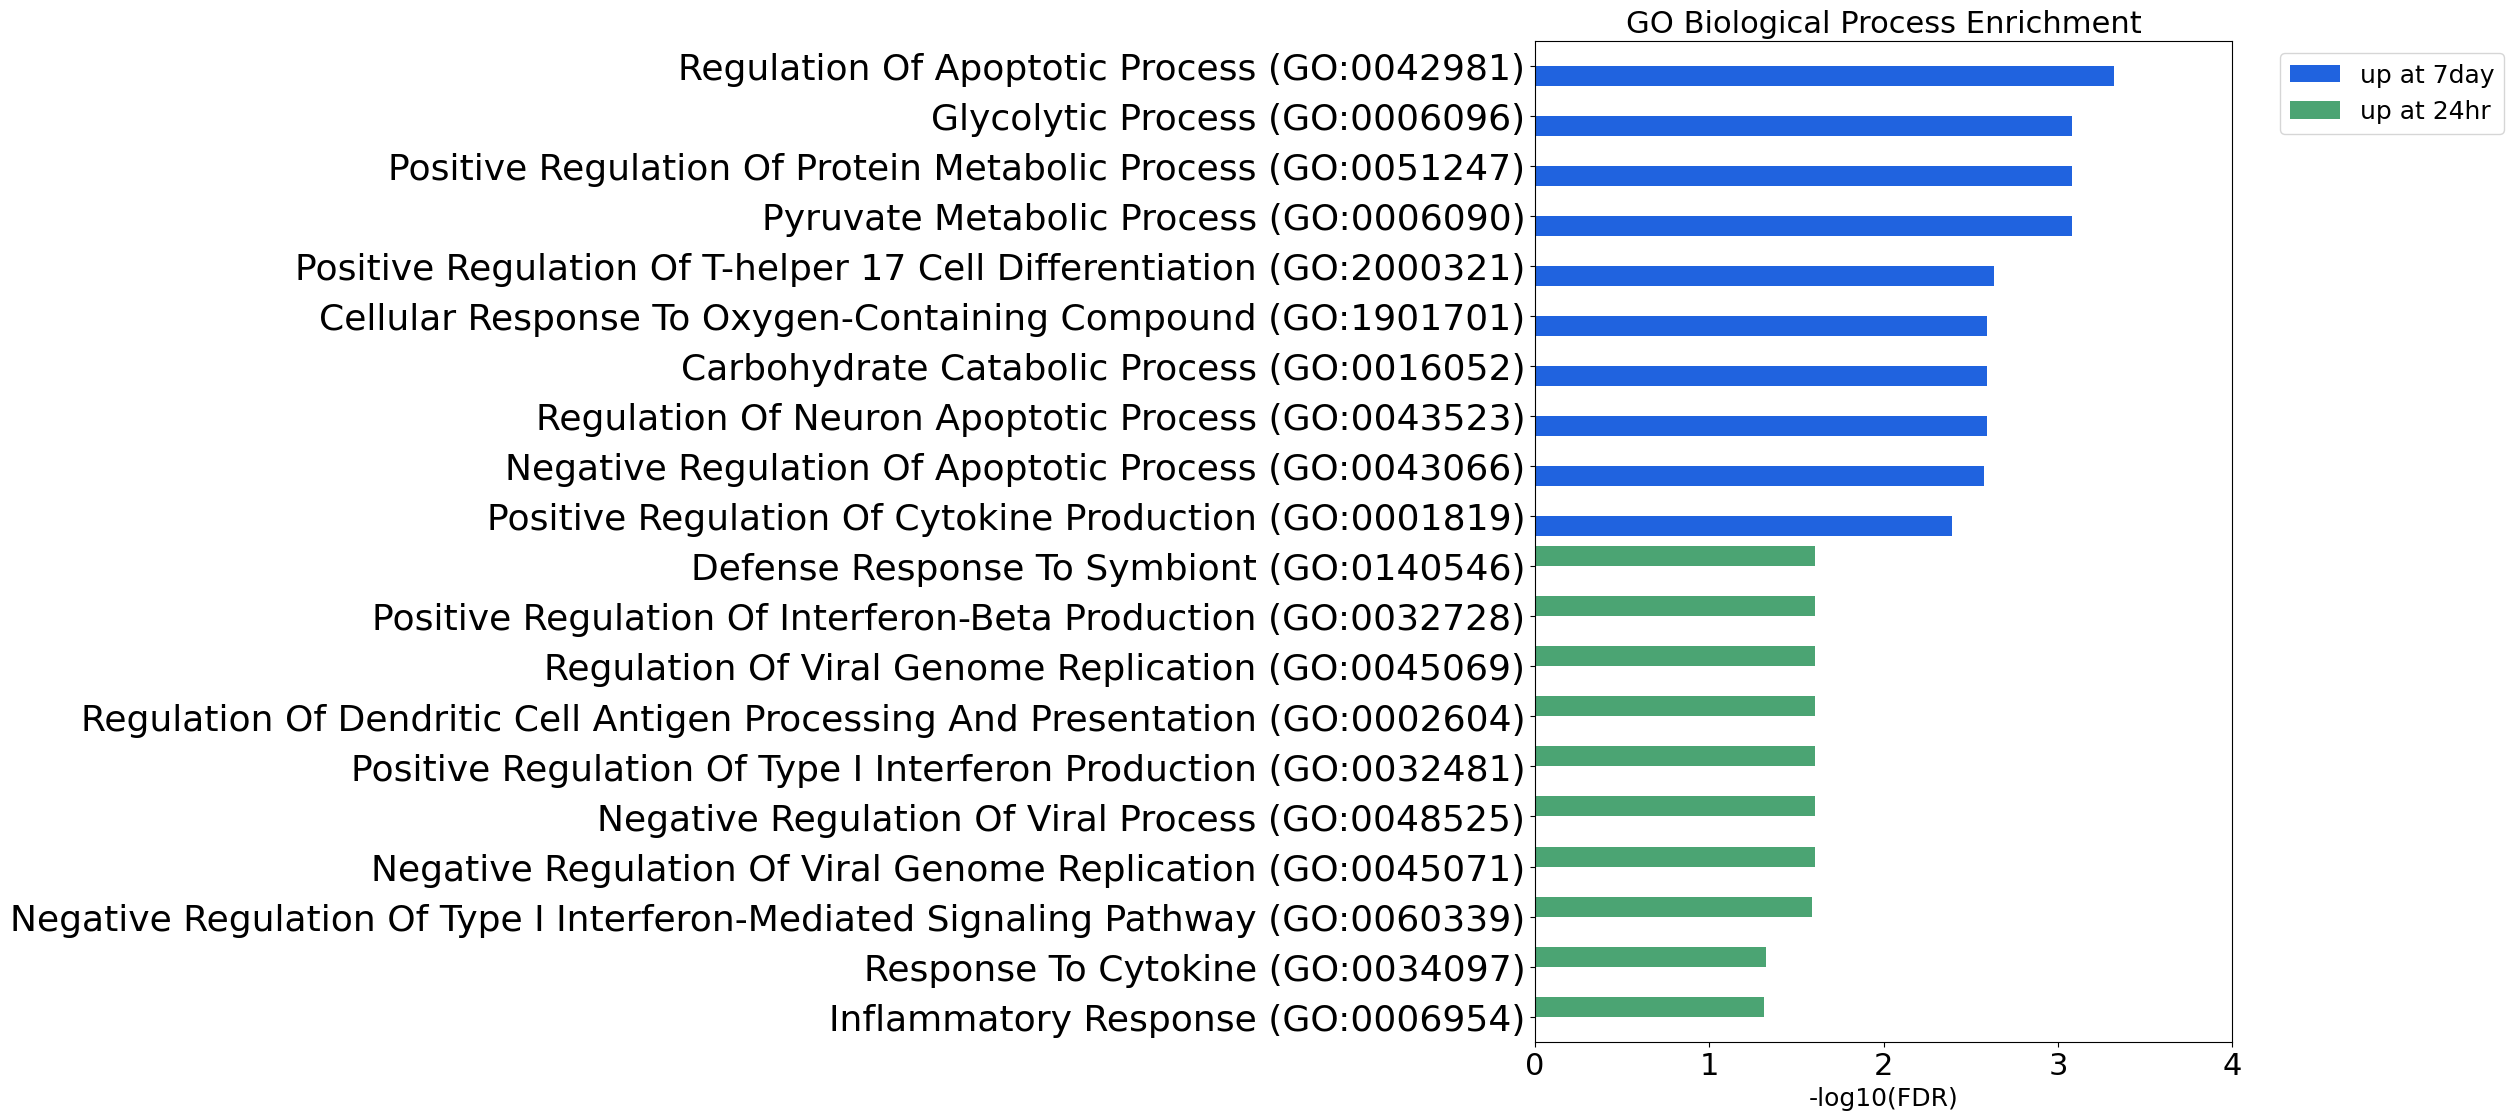

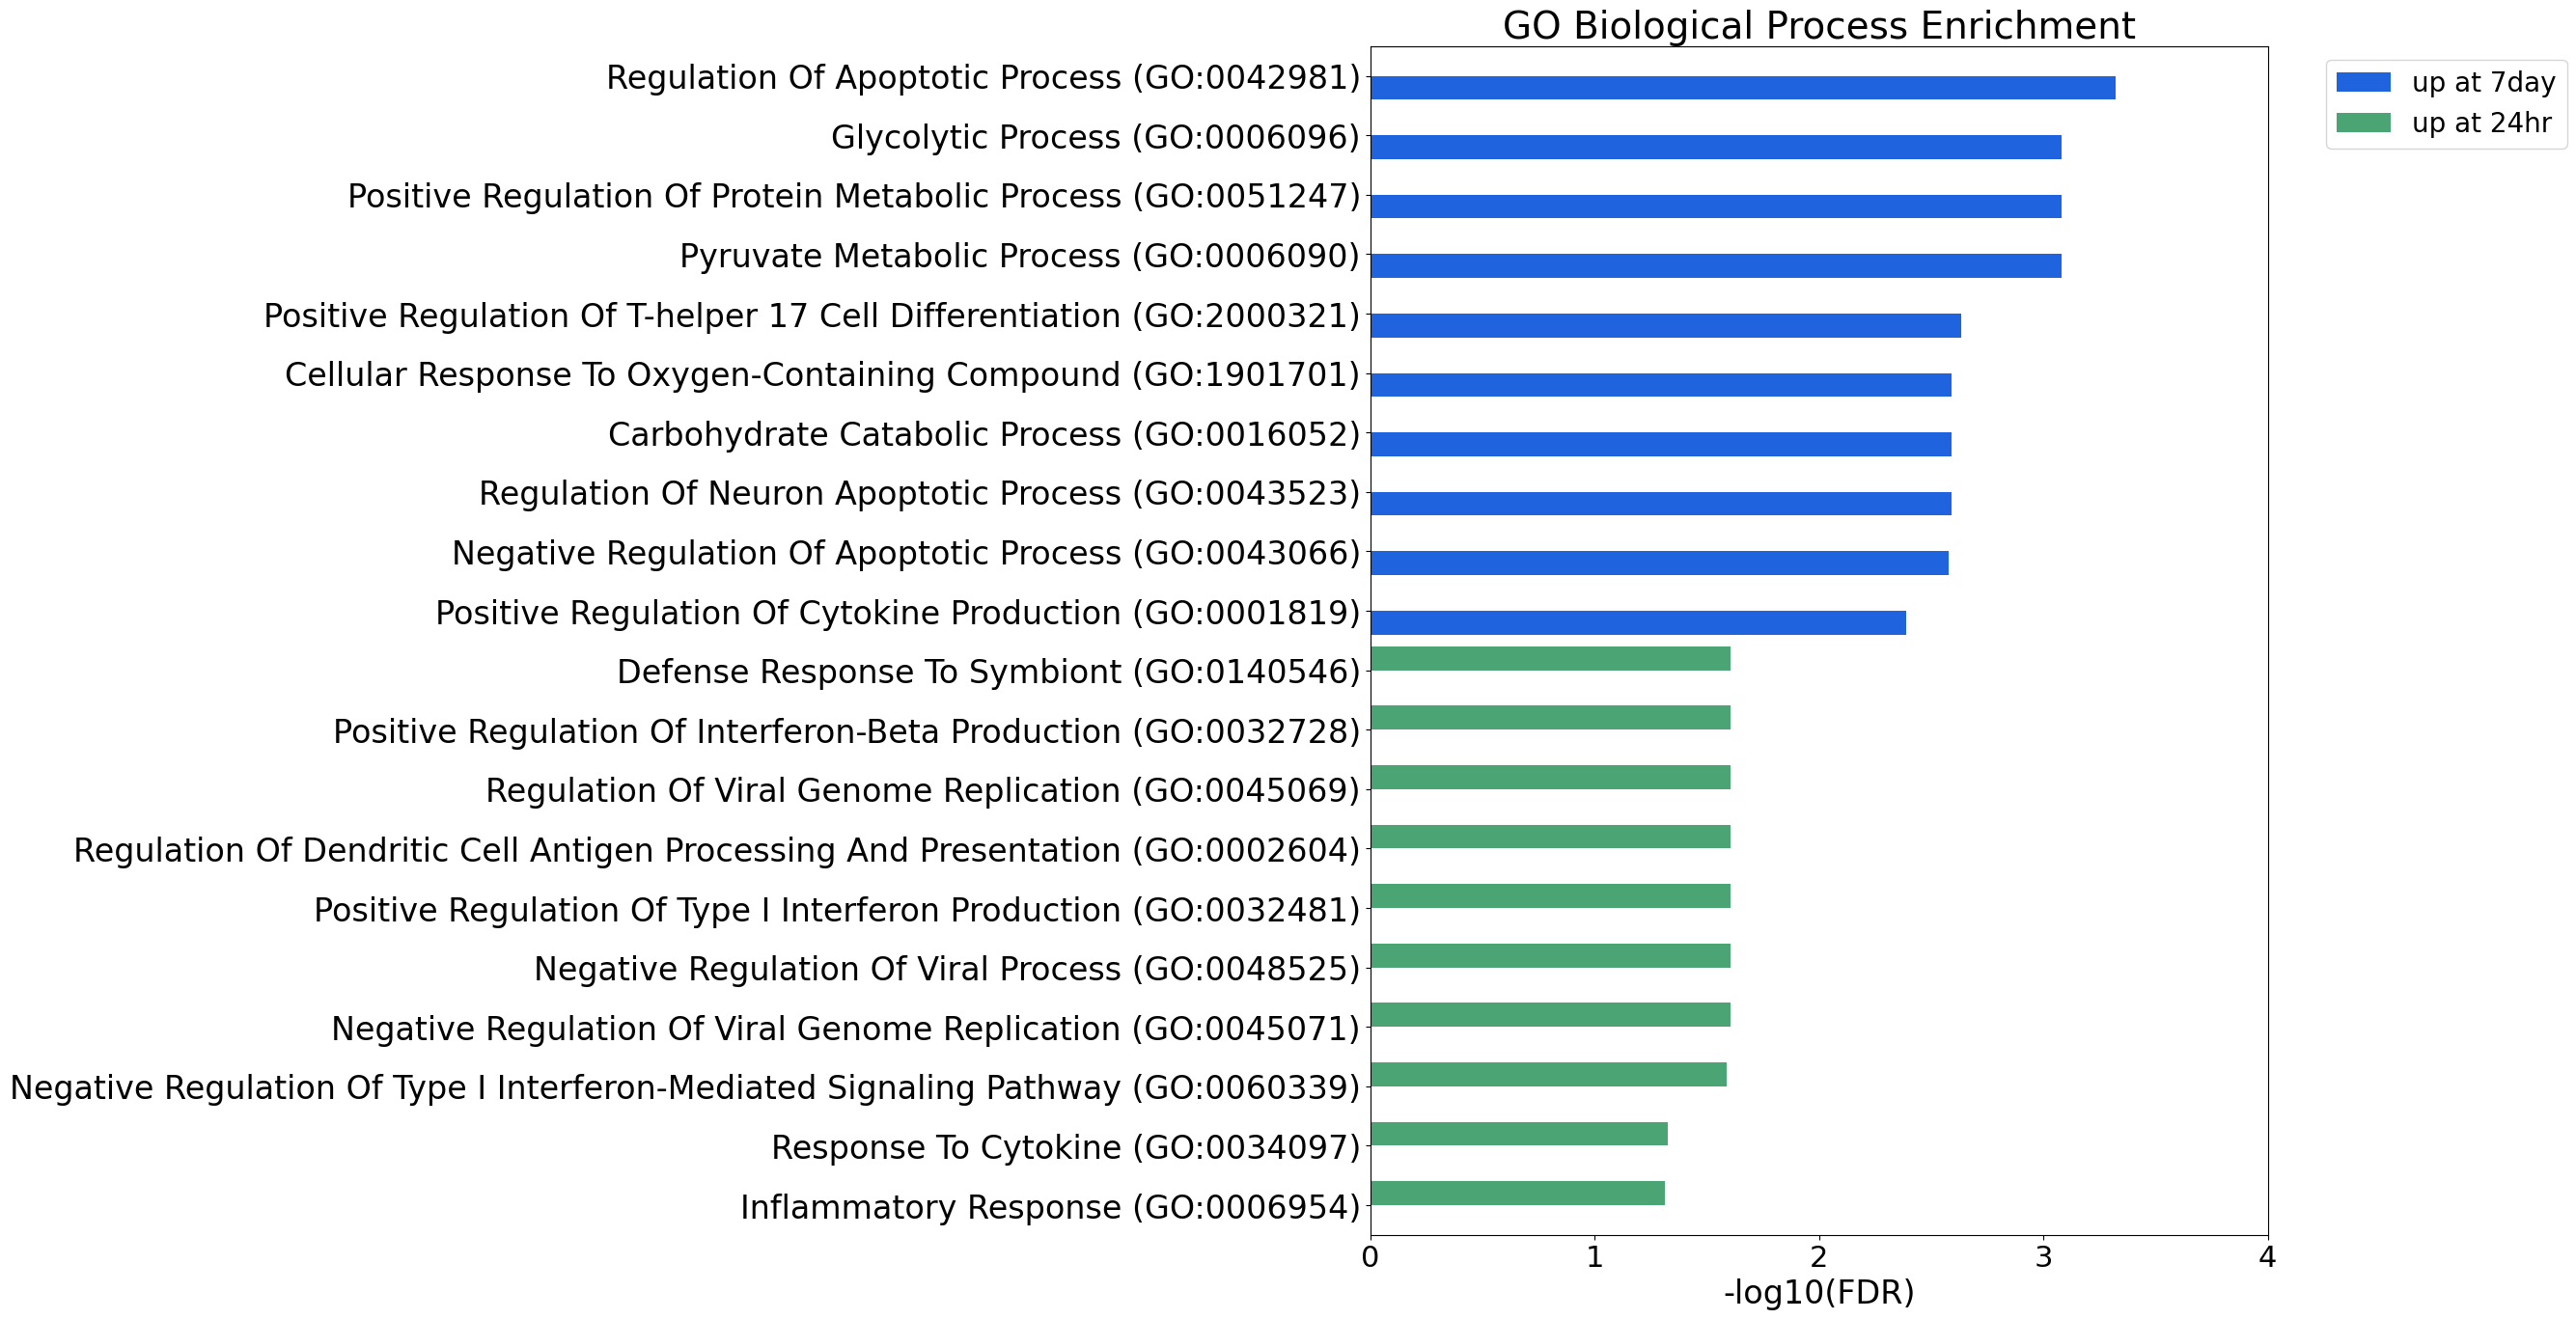

In [142]:
# Sort GO-BP results by significance for consistent plotting
go_df = go_df.sort_values("-log10(FDR)", ascending=False)

# Set y-axis order to match sorting
go_df["Term"] = pd.Categorical(go_df["Term"], categories=go_df["Term"].unique()[::-1], ordered=True)

# Plot GO-BP
plt.figure(figsize=(12, 16))  # Slightly larger figure for better readability
sns.barplot(
    data=go_df,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    palette=palette,
)

# Increase all relevant font sizes
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20, title_fontsize=22)
plt.title("GO Biological Process Enrichment", fontsize=28)
plt.xlabel("-log10(FDR)", fontsize=24)
plt.ylabel("")
plt.xticks(fontsize=22)

# 💡 THIS is what makes the y-axis (GO terms) labels large:
plt.yticks(fontsize=24)

plt.gca().invert_yaxis()

# Force integer x-ticks
import numpy as np
xmax = plt.gca().get_xlim()[1]
plt.xticks(ticks=np.arange(0, int(np.ceil(xmax)) + 1, 1), fontsize=22)

plt.tight_layout()
plt.show()


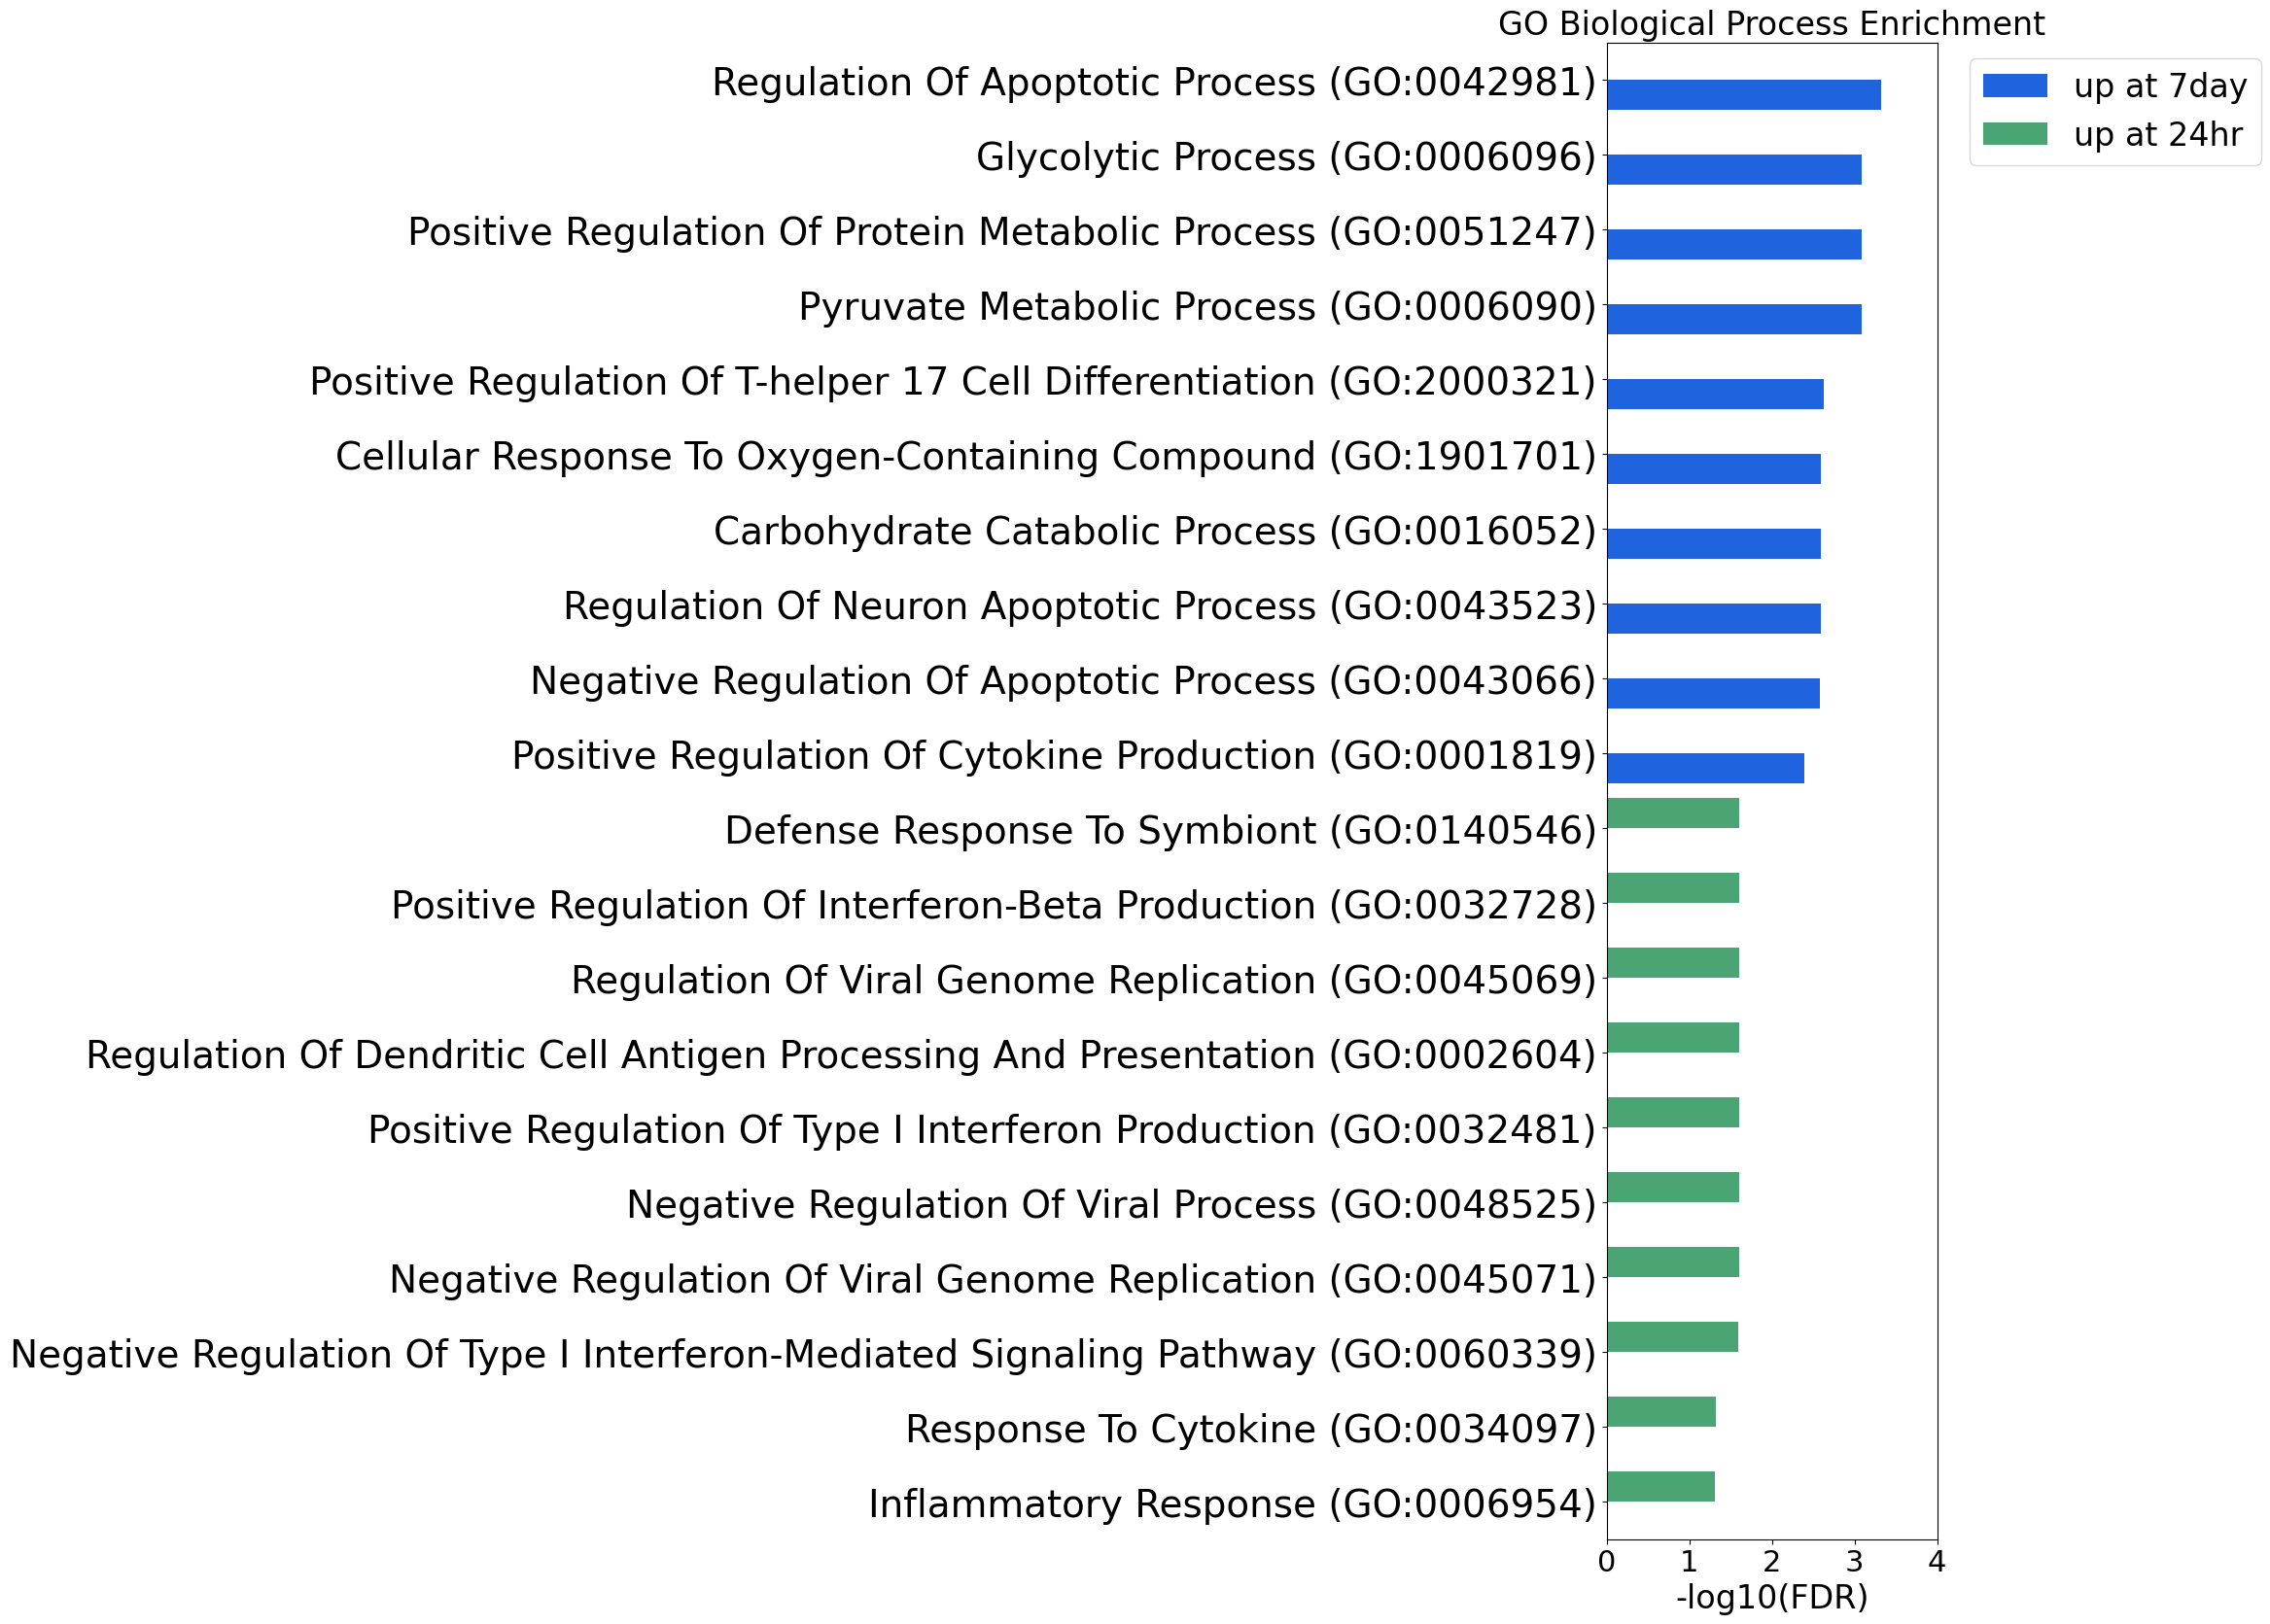

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sort GO-BP results by significance for consistent plotting
go_df = go_df.sort_values("-log10(FDR)", ascending=False)

# Set y-axis order to match sorting
go_df["Term"] = pd.Categorical(go_df["Term"], categories=go_df["Term"].unique()[::-1], ordered=True)

# Plot GO-BP with extra space
plt.figure(figsize=(17, 20))  # Wider + taller for long terms
sns.barplot(
    data=go_df,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    palette=palette,
)

# Font settings
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=24)
plt.title("GO Biological Process Enrichment", fontsize=24)
plt.xlabel("-log10(FDR)", fontsize=24)
plt.ylabel("")
plt.xticks(ticks=np.arange(0, int(np.ceil(go_df["-log10(FDR)"].max())) + 1, 1), fontsize=22)
plt.yticks(fontsize=28)

# Invert y-axis for correct order
plt.gca().invert_yaxis()

# 🔧 Increase left margin to prevent y-tick label clipping
plt.subplots_adjust(left=0.7)

plt.tight_layout()
plt.show()


In [42]:
print("  Pathway analysis within tissue-like neutros")
# Define the genes to exclude
excluded_genes = {"Hbb-bs", "Hba-a1", "Hba-a3"}

# Get the top 150 downregulated genes, excluding the unwanted ones
dwn_genes_ = [gene for gene in upreg.loc[upreg["score"] < 0].index[::-1][:150] if gene not in excluded_genes]

# Get the top 150 upregulated genes, excluding the unwanted ones
up_genes_ = [gene for gene in upreg.loc[upreg["score"] > 0].index[:150] if gene not in excluded_genes]

print("  Downregulated at 7 days")
enr_dwn = gp.enrichr(
    gene_list=list(dwn_genes_),
    gene_sets=["KEGG_2019_Mouse", "GO_Biological_Process_2023"],
    organism="mouse",
    outdir=None,
)
print("  Upregulated at 7 days")
enr_up = gp.enrichr(
    gene_list=list(up_genes_),
    gene_sets=["KEGG_2019_Mouse", "GO_Biological_Process_2023"],
    organism="mouse",
    outdir=None,
)
dwn_pathways = enr_dwn.results.query(
    "Gene_set == 'GO_Biological_Process_2023'"
).nsmallest(10, "Adjusted P-value")
dwn_pathways = dwn_pathways.loc[dwn_pathways["Adjusted P-value"] < 0.05]

up_pathways = enr_up.results.query(
    "Gene_set == 'GO_Biological_Process_2023'"
).nsmallest(10, "Adjusted P-value")
up_pathways = up_pathways.loc[up_pathways["Adjusted P-value"] < 0.05]


  Pathway analysis within tissue-like neutros
  Downregulated at 7 days
  Upregulated at 7 days


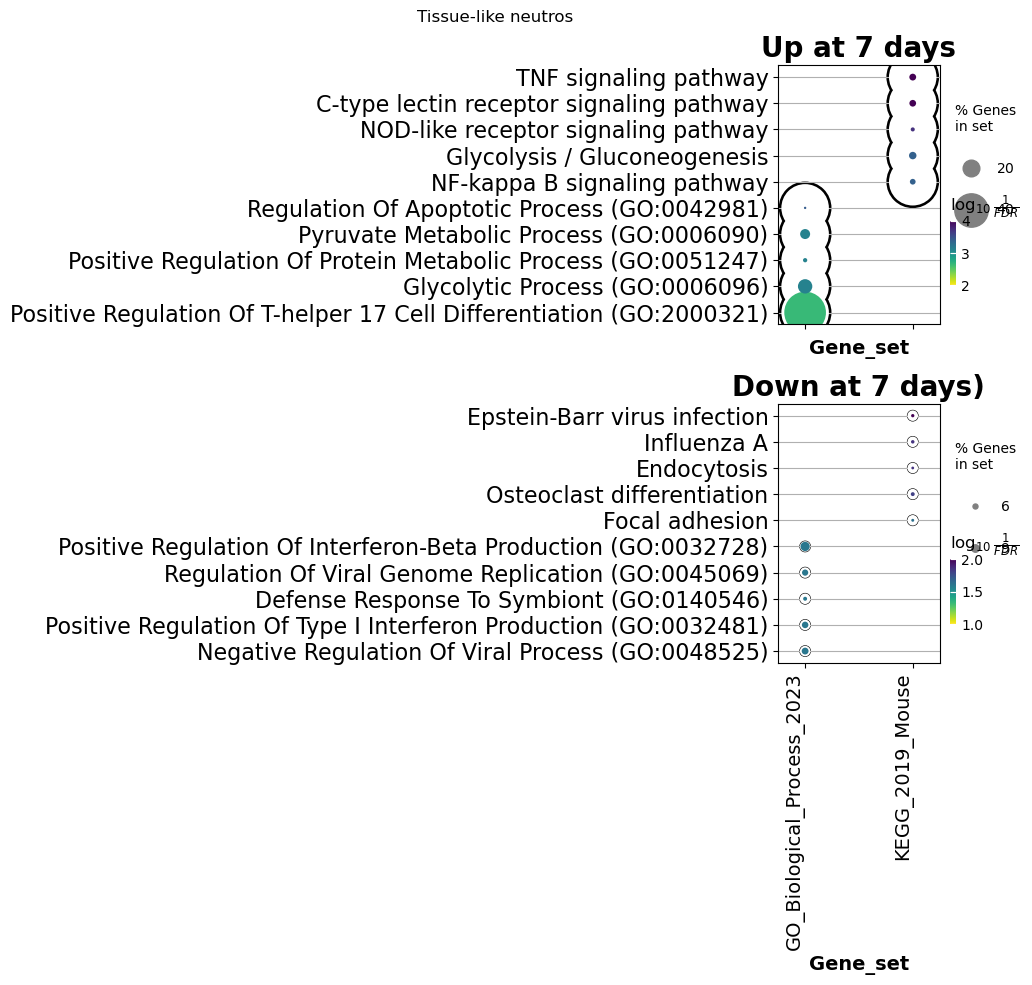

In [43]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
gp.dotplot(
    enr_up.results,
    column="Adjusted P-value",
    x="Gene_set",
    size=10,
    top_term=5,
    figsize=(3, 5),
    title="Up at 7 days",
    xticklabels_rot=90,  # rotate xtick labels
    show_ring=True,
    marker="o",
    ax=axs[0],
)
gp.dotplot(
    enr_dwn.results,
    column="Adjusted P-value",
    x="Gene_set",  # set x axis, so you could do a multi-sample/library comparsion
    size=10,
    top_term=5,
    figsize=(3, 5),
    title="Down at 7 days)",
    xticklabels_rot=90,
    show_ring=True,
    marker="o",
    ax=axs[1],
)
axs[0].set(xticklabels=[])
fig.suptitle("Tissue-like neutros")
fig.tight_layout()

<Figure size 800x600 with 0 Axes>

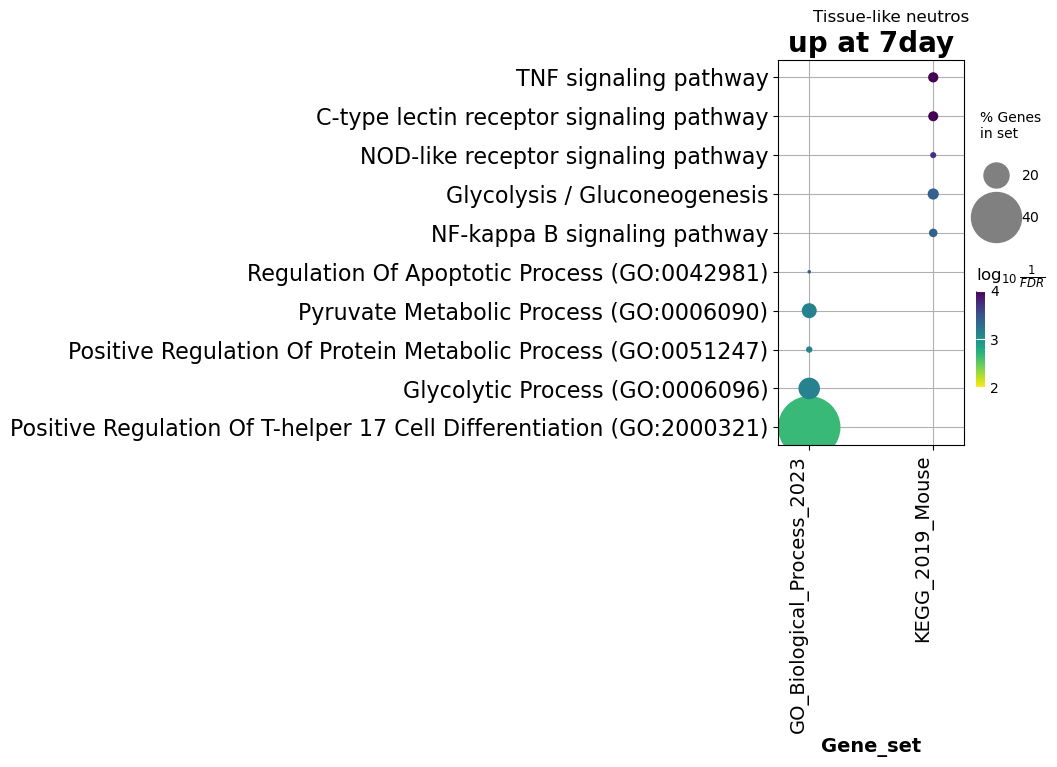

In [44]:
import matplotlib.pyplot as plt
import gseapy as gp

# Plot for tissue-like neutrophils
plt.figure(figsize=(8, 6))
ax = gp.dotplot(
    enr_up.results,
    column="Adjusted P-value",
    x="Gene_set",
    size=15,
    top_term=5,
    figsize=(3,5),
    title="up at 7day",
    xticklabels_rot=90,
    show_ring=False,
    marker="o",
    legend_kws={"bbox_to_anchor": (1.05, 1), "loc": "upper left", "title": "Adj. P-value"},
)
#ax.yaxis.grid(False)
ax.xaxis.grid(True)
plt.tight_layout()
plt.suptitle("Tissue-like neutros")
plt.show()

<Figure size 800x600 with 0 Axes>

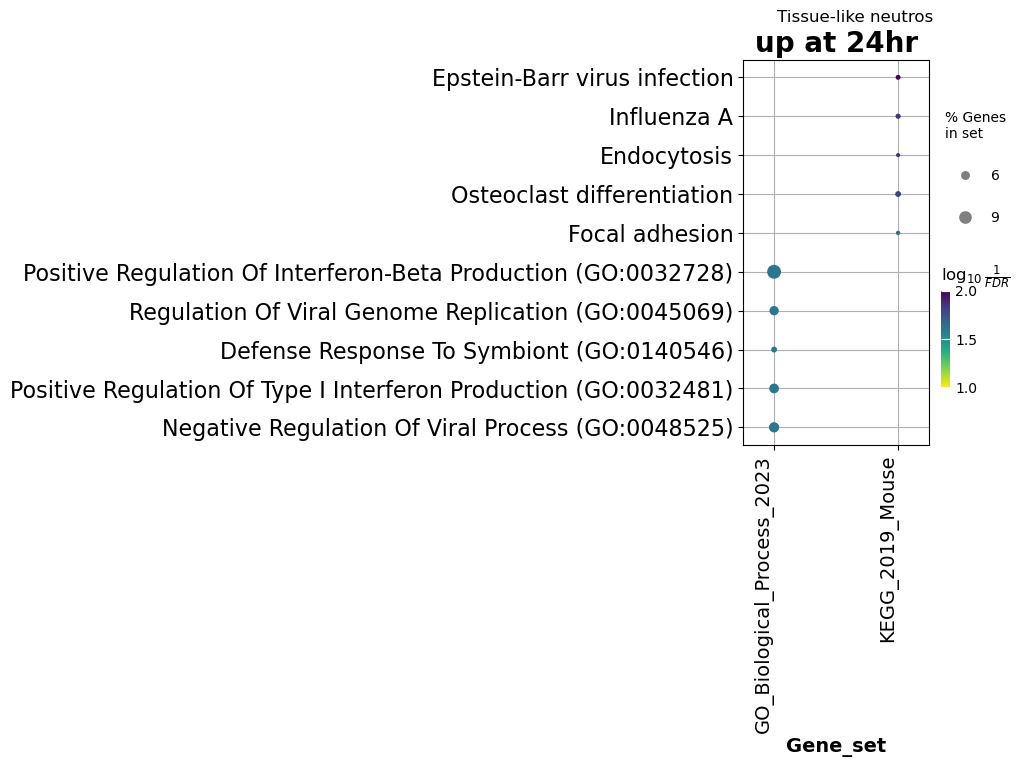

In [45]:
import matplotlib.pyplot as plt
import gseapy as gp

# Plot for tissue-like neutrophils
plt.figure(figsize=(8, 6))
ax = gp.dotplot(
    enr_dwn.results,
    column="Adjusted P-value",
    x="Gene_set",
    size=15,
    top_term=5,
    figsize=(3,5),
    title="up at 24hr",
    xticklabels_rot=90,
    show_ring=False,
    marker="o",
    legend_kws={"bbox_to_anchor": (1.05, 1), "loc": "upper left", "title": "Adj. P-value"},
)
#ax.yaxis.grid(False)
ax.xaxis.grid(True)
plt.tight_layout()
plt.suptitle("Tissue-like neutros")
plt.show()

In [46]:
print("  Pathway analysis within tissue-like neutros")
# Define the genes to exclude
excluded_genes = {"Hbb-bs", "Hba-a1", "Hba-a3"}

# Get the top 150 downregulated genes, excluding the unwanted ones
dwn_genes_ = [gene for gene in upreg.loc[upreg["score"] < 0].index[::-1][:150] if gene not in excluded_genes]

# Get the top 150 upregulated genes, excluding the unwanted ones
up_genes_ = [gene for gene in upreg.loc[upreg["score"] > 0].index[:150] if gene not in excluded_genes]

print("  Downregulated at 7 days")
enr_dwn = gp.enrichr(
    gene_list=list(dwn_genes_),
    gene_sets=["KEGG_2019_Mouse"],
    organism="mouse",
    outdir=None,
)
print("  Upregulated at 7 days")
enr_up = gp.enrichr(
    gene_list=list(up_genes_),
    gene_sets=["KEGG_2019_Mouse"],
    organism="mouse",
    outdir=None,
)
dwn_pathways = enr_dwn.results.query(
    "Gene_set == 'KEGG_2019_Mouse'"
).nsmallest(10, "Adjusted P-value")
dwn_pathways = dwn_pathways.loc[dwn_pathways["Adjusted P-value"] < 0.05]

up_pathways = enr_up.results.query(
    "Gene_set == 'KEGG_2019_Mouse'"
).nsmallest(10, "Adjusted P-value")
up_pathways = up_pathways.loc[up_pathways["Adjusted P-value"] < 0.05]

  Pathway analysis within tissue-like neutros
  Downregulated at 7 days
  Upregulated at 7 days


<Figure size 800x600 with 0 Axes>

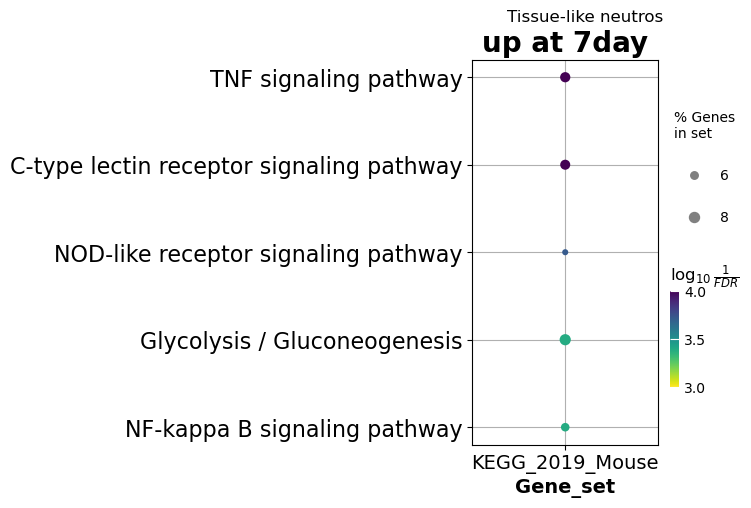

In [47]:
import matplotlib.pyplot as plt
import gseapy as gp

# Plot for tissue-like neutrophils
plt.figure(figsize=(8, 6))
ax = gp.dotplot(
    enr_up.results,
    column="Adjusted P-value",
    x="Gene_set",
    size=15,
    top_term=5,
    figsize=(3,5),
    title="up at 7day",
    xticklabels_rot=0,
    show_ring=False,
    marker="o",
    legend_kws={"bbox_to_anchor": (1.05, 1), "loc": "upper left", "title": "Adj. P-value"},
)
#ax.yaxis.grid(False)
ax.xaxis.grid(True)
plt.tight_layout()
plt.suptitle("Tissue-like neutros")
plt.show()

<Figure size 800x600 with 0 Axes>

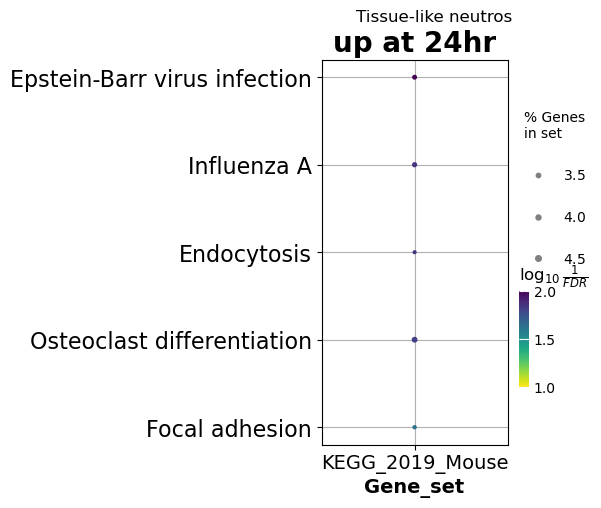

In [48]:
import matplotlib.pyplot as plt
import gseapy as gp

# Plot for tissue-like neutrophils
plt.figure(figsize=(8, 6))
ax = gp.dotplot(
    enr_dwn.results,
    column="Adjusted P-value",
    x="Gene_set",
    size=15,
    top_term=5,
    figsize=(3,5),
    title="up at 24hr",
    xticklabels_rot=0,
    show_ring=False,
    marker="o",
    legend_kws={"bbox_to_anchor": (1.05, 1), "loc": "upper left", "title": "Adj. P-value"},
)
#ax.yaxis.grid(False)
ax.xaxis.grid(True)
plt.tight_layout()
plt.suptitle("Tissue-like neutros")
plt.show()

In [49]:
print("  Pathway analysis within tissue-like neutros")
# Define the genes to exclude
excluded_genes = {"Hbb-bs", "Hba-a1", "Hba-a3"}

# Get the top 150 downregulated genes, excluding the unwanted ones
dwn_genes_ = [gene for gene in upreg.loc[upreg["score"] < 0].index[::-1][:150] if gene not in excluded_genes]

# Get the top 150 upregulated genes, excluding the unwanted ones
up_genes_ = [gene for gene in upreg.loc[upreg["score"] > 0].index[:150] if gene not in excluded_genes]

print("  Downregulated at 7 days")
enr_dwn = gp.enrichr(
    gene_list=list(dwn_genes_),
    gene_sets=["GO_Biological_Process_2023"],
    organism="mouse",
    outdir=None,
)
print("  Upregulated at 7 days")
enr_up = gp.enrichr(
    gene_list=list(up_genes_),
    gene_sets=["GO_Biological_Process_2023"],
    organism="mouse",
    outdir=None,
)
dwn_pathways = enr_dwn.results.query(
    "Gene_set == 'GO_Biological_Process_2023'"
).nsmallest(10, "Adjusted P-value")
dwn_pathways = dwn_pathways.loc[dwn_pathways["Adjusted P-value"] < 0.05]

up_pathways = enr_up.results.query(
    "Gene_set == 'GO_Biological_Process_2023'"
).nsmallest(10, "Adjusted P-value")
up_pathways = up_pathways.loc[up_pathways["Adjusted P-value"] < 0.05]


  Pathway analysis within tissue-like neutros
  Downregulated at 7 days
  Upregulated at 7 days


<Figure size 800x600 with 0 Axes>

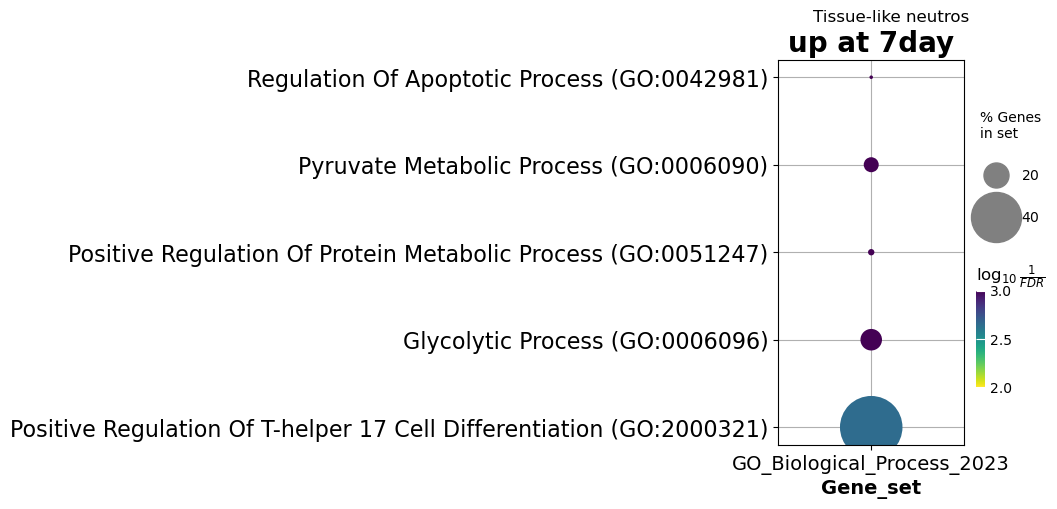

In [50]:
import matplotlib.pyplot as plt
import gseapy as gp

# Plot for Tissue-like neutrophils
plt.figure(figsize=(8, 6))
ax = gp.dotplot(
    enr_up.results,
    column="Adjusted P-value",
    x="Gene_set",
    size=15,
    top_term=5,
    figsize=(3,5),
    title="up at 7day",
    xticklabels_rot=0,
    show_ring=False,
    marker="o",
    legend_kws={"bbox_to_anchor": (1.05, 1), "loc": "upper left", "title": "Adj. P-value"},
)
#ax.yaxis.grid(False)
ax.xaxis.grid(True)
plt.tight_layout()
plt.suptitle("Tissue-like neutros")
plt.show()

<Figure size 800x600 with 0 Axes>

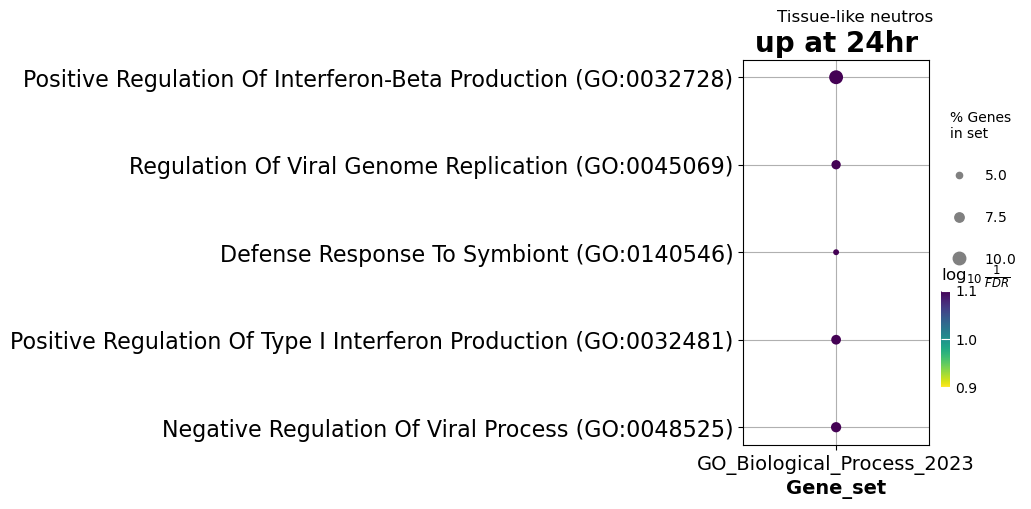

In [51]:
import matplotlib.pyplot as plt
import gseapy as gp

# Plot for tissue-like neutrophils
plt.figure(figsize=(8, 6))
ax = gp.dotplot(
    enr_dwn.results,
    column="Adjusted P-value",
    x="Gene_set",
    size=15,
    top_term=5,
    figsize=(3,5),
    title="up at 24hr",
    xticklabels_rot=0,
    show_ring=False,
    marker="o",
    legend_kws={"bbox_to_anchor": (1.05, 1), "loc": "upper left", "title": "Adj. P-value"},
)
#ax.yaxis.grid(False)
ax.xaxis.grid(True)
plt.tight_layout()
plt.suptitle("Tissue-like neutros")
plt.show()

# DEGs between 24hr-neutrophils vs 7day-neutrophils in wound ( in blood-like)

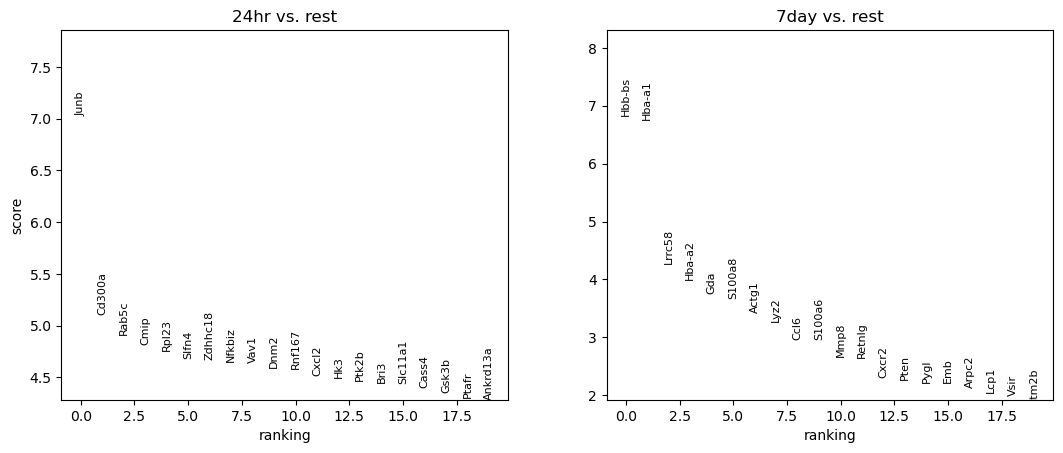

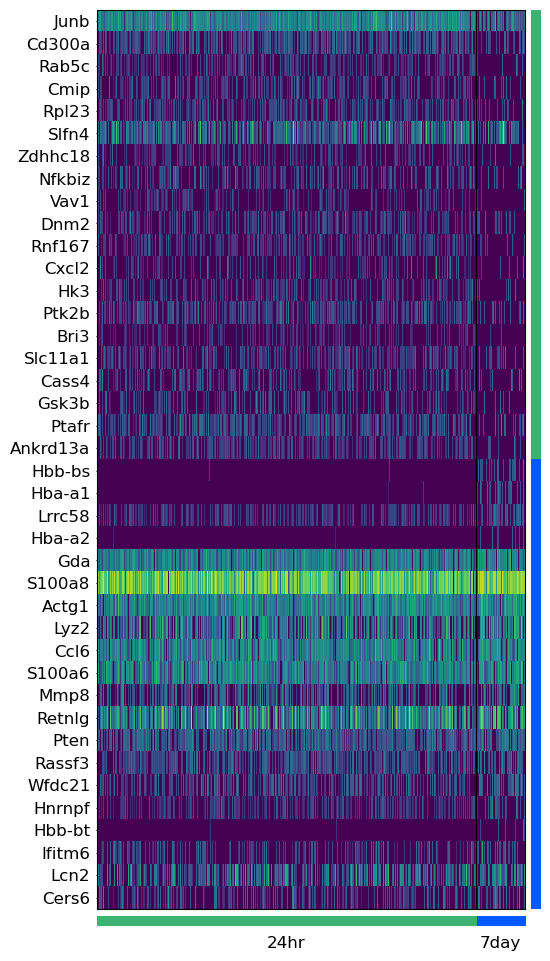

Hbb-bs is supposed to be "up": 24hr 0.013837315142154694, 7 days 0.6566023826599121
    (Up means up in 7 days)
  Print the top genes, to get an idea
    Upregulated at 7 days vs 1 day:
          gene     score          pval      pval_adj     logFC
Hbb-bs  Hbb-bs  6.833573  8.282550e-12  1.044554e-07  6.057853
Hba-a1  Hba-a1  6.764277  1.339762e-11  1.126427e-07  7.129434
Lrrc58  Lrrc58  4.272370  1.934065e-05  1.876266e-02  0.994969
Hba-a2  Hba-a2  3.992269  6.544417e-05  3.781275e-02  5.544444
Gda        Gda  3.750903  1.761990e-04  6.285214e-02  0.375535
S100a8  S100a8  3.657471  2.547162e-04  7.470588e-02  0.422307
Actg1    Actg1  3.416494  6.343298e-04  1.233388e-01  0.252901
Lyz2      Lyz2  3.271480  1.069861e-03  1.655527e-01  0.622809
Ccl6      Ccl6  2.958873  3.087668e-03  2.863244e-01  0.301366
S100a6  S100a6  2.949335  3.184589e-03  2.910322e-01  0.315043
Mmp8      Mmp8  2.667287  7.646633e-03  4.647495e-01  0.628692
Retnlg  Retnlg  2.650742  8.031521e-03  4.777345e-01  0.43

In [52]:
wound_neutro_bl = wound_neutro[wound_neutro.obs["broad_neutro_type"] == "Blood-like"]
# Double ensure there's no blood of any kind in here, just to keep things clean
wound_neutro_bl = wound_neutro_bl[wound_neutro_bl.obs["time_point"] != "Blood"]

# Perform differential gene expression analysis
sc.tl.rank_genes_groups(wound_neutro_bl, groupby="time_point", method="wilcoxon")

# View the top-ranked genes
sc.pl.rank_genes_groups(wound_neutro_bl, n_genes=20, sharey=False)
sc.pl.rank_genes_groups_heatmap(
    wound_neutro_bl,
    n_genes=20,
    groupby='time_point',
    swap_axes=True,
    min_logfoldchange=0.25,
    dendrogram=False,
    show_gene_labels=True,
    figsize=(6, 12),
    show=False
)
fig=plt.gcf()


#rotate x-axis labels
for ax in fig.axes:
    if ax.get_xticklabels():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=12)
    if ax.get_ylabel() == '':
        ax.tick_params(axis='y', labelsize=12)
    if ax.get_xlabel() == "time_point":
        ax.set_xlabel("")
axes = fig.get_axes()
if len(axes) > 1:
    fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

# Extract results
tmpl = wound_neutro_bl.uns['rank_genes_groups']
# Create a DataFrame with gene names, log2 fold change, p-values, and adjusted p-values
upregl = pd.DataFrame(
    index=tmpl["names"]["7day"],  
    data={ 'gene': tmpl['names']["7day"],
        "score": tmpl["scores"]["7day"],
        "pval": tmpl["pvals"]["7day"],
        "pval_adj": tmpl["pvals_adj"]["7day"],
        "logFC": tmpl["logfoldchanges"]["7day"],
    },
)

top_upl = upregl.index[0]
x24h = wound_neutro_bl[wound_neutro_bl.obs["time_point"] == "24hr", top_upl].X.mean()
x7d = wound_neutro_bl[wound_neutro_bl.obs["time_point"] != "24hr", top_upl].X.mean()
print(f'{top_upl} is supposed to be "up": 24hr {x24h}, 7 days {x7d}')
print("    (Up means up in 7 days)")

print("  Print the top genes, to get an idea")
print("    Upregulated at 7 days vs 1 day:")
print(upregl.iloc[:20])
print("    Downregulated at 7 days vs 1 day:")
print(upregl.iloc[-20:].iloc[::-1])

upregl.to_csv("24hr vs 7day only bl.csv", index=False)

In [53]:
print("  Pathway analysis within blood-like neutros")
dwn_genes = upregl.loc[upregl["score"] < 0].index[::-1][:150]
up_genes = upregl.loc[upregl["score"] > 0].index[:150]
print("  Downregulated at 7 days")
enr_dwn = gp.enrichr(
    gene_list=list(dwn_genes),
    gene_sets=["KEGG_2019_Mouse", "GO_Biological_Process_2023"],
    organism="mouse",
    outdir=None,
)
print("  Upregulated at 7 days")
enr_up = gp.enrichr(
    gene_list=list(up_genes),
    gene_sets=["KEGG_2019_Mouse", "GO_Biological_Process_2023"],
    organism="mouse",
    outdir=None,
)
dwn_pathways = enr_dwn.results.query(
    "Gene_set == 'GO_Biological_Process_2023'"
).nsmallest(10, "Adjusted P-value")
dwn_pathways = dwn_pathways.loc[dwn_pathways["Adjusted P-value"] < 0.05]

up_pathways = enr_up.results.query(
    "Gene_set == 'GO_Biological_Process_2023'"
).nsmallest(10, "Adjusted P-value")
up_pathways = up_pathways.loc[up_pathways["Adjusted P-value"] < 0.05]


  Pathway analysis within blood-like neutros
  Downregulated at 7 days
  Upregulated at 7 days


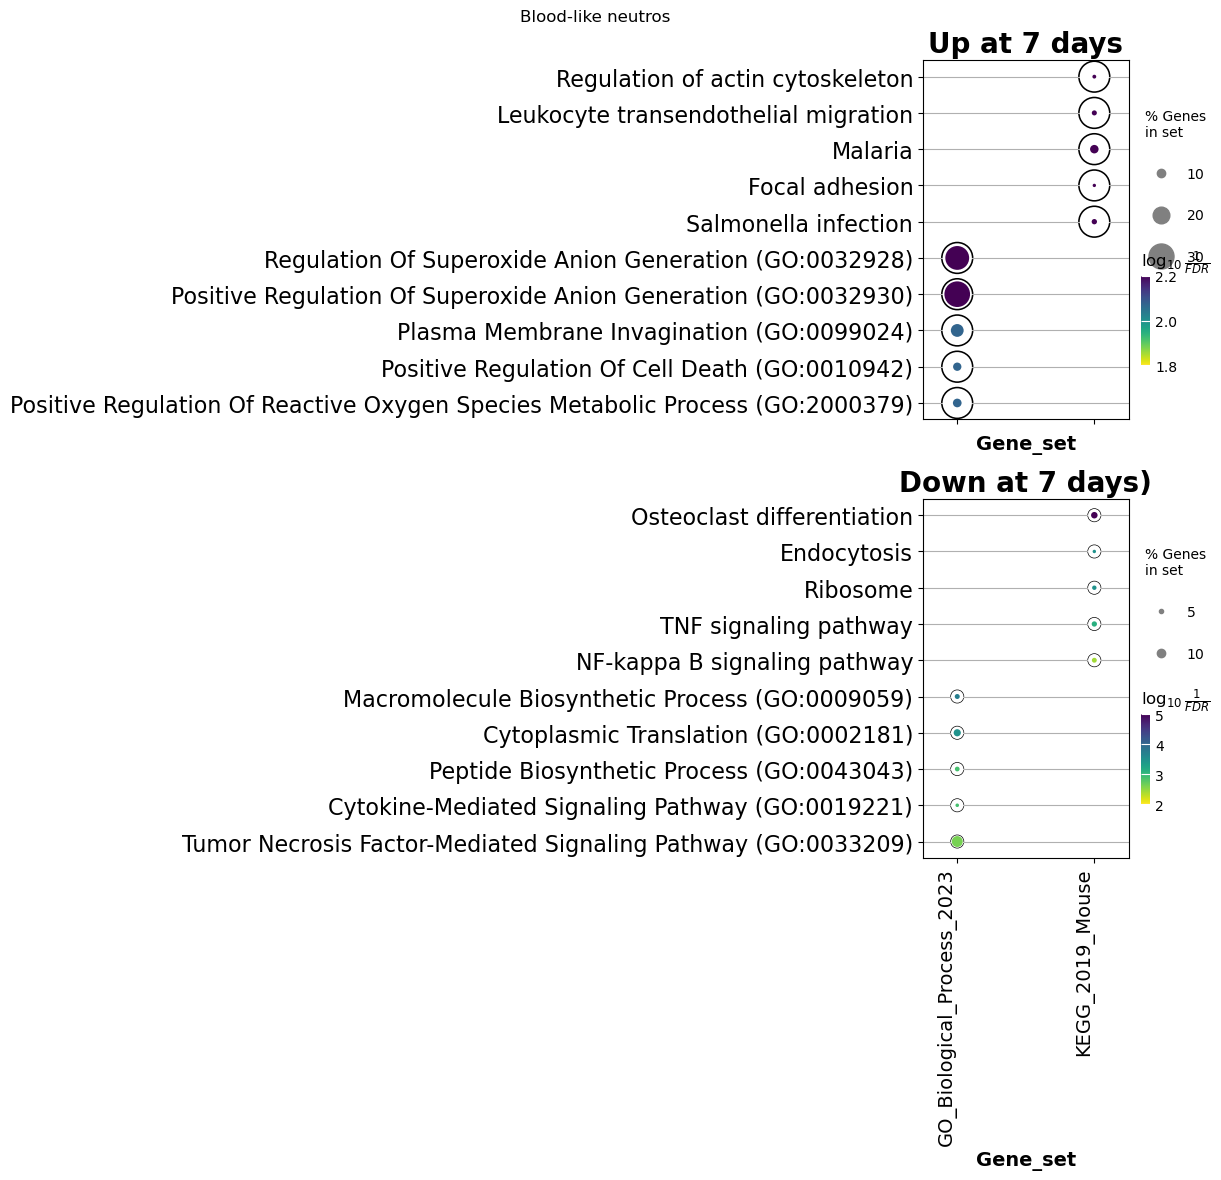

In [54]:
fig, axs = plt.subplots(2, 1, figsize=(12, 12))
gp.dotplot(
    enr_up.results,
    column="Adjusted P-value",
    x="Gene_set",
    size=10,
    top_term=5,
    figsize=(3, 5),
    title="Up at 7 days",
    xticklabels_rot=90,  # rotate xtick labels
    show_ring=True,
    marker="o",
    ax=axs[0],
)
gp.dotplot(
    enr_dwn.results,
    column="Adjusted P-value",
    x="Gene_set",  # set x axis, so you could do a multi-sample/library comparsion
    size=10,
    top_term=5,
    figsize=(3, 5),
    title="Down at 7 days)",
    xticklabels_rot=90,
    show_ring=True,
    marker="o",
    ax=axs[1],
)
axs[0].set(xticklabels=[])
fig.suptitle("Blood-like neutros")
fig.tight_layout()

<Figure size 800x600 with 0 Axes>

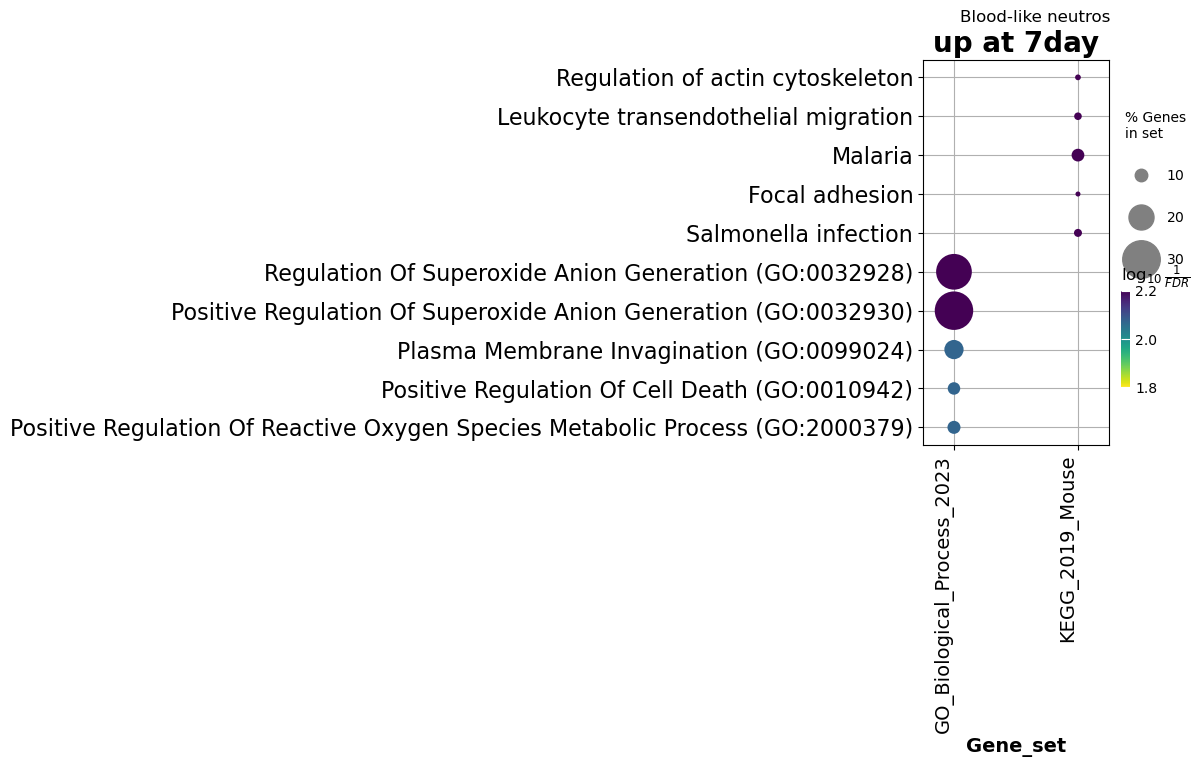

In [55]:
import matplotlib.pyplot as plt
import gseapy as gp

# Plot for Blood-like neutrophils
plt.figure(figsize=(8, 6))
ax = gp.dotplot(
    enr_up.results,
    column="Adjusted P-value",
    x="Gene_set",
    size=15,
    top_term=5,
    figsize=(3,5),
    title="up at 7day",
    xticklabels_rot=90,
    show_ring=False,
    marker="o",
    legend_kws={"bbox_to_anchor": (1.05, 1), "loc": "upper left", "title": "Adj. P-value"},
)
#ax.yaxis.grid(False)
ax.xaxis.grid(True)
plt.tight_layout()
plt.suptitle("Blood-like neutros")
plt.show()

<Figure size 800x600 with 0 Axes>

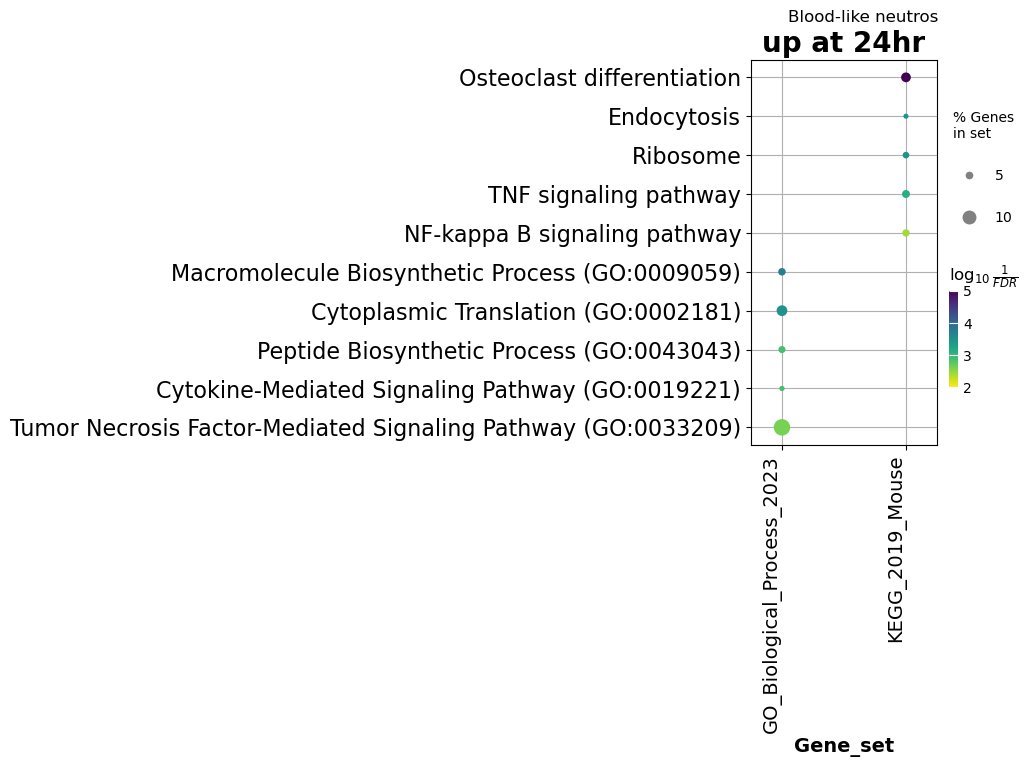

In [56]:
# Plot for Blood-like neutrophils
plt.figure(figsize=(8, 6))
ax = gp.dotplot(
    enr_dwn.results,
    column="Adjusted P-value",
    x="Gene_set",
    size=15,
    top_term=5,
    figsize=(3,5),
    title="up at 24hr",
    xticklabels_rot=90,
    show_ring=False,
    marker="o",
    legend_kws={"bbox_to_anchor": (1.05, 1), "loc": "upper left", "title": "Adj. P-value"},
)
#ax.yaxis.grid(False)
ax.xaxis.grid(True)
plt.tight_layout()
plt.suptitle("Blood-like neutros")
plt.show()

In [57]:
print("  Pathway analysis within Blood-like neutros")
dwn_genes = upregl.loc[upregl["score"] < 0].index[::-1][:150]
up_genes = upregl.loc[upregl["score"] > 0].index[:150]
print("  Downregulated at 7 days")
enr_dwn = gp.enrichr(
    gene_list=list(dwn_genes),
    gene_sets=["KEGG_2019_Mouse"],
    organism="mouse",
    outdir=None,
)
print("  Upregulated at 7 days")
enr_up = gp.enrichr(
    gene_list=list(up_genes),
    gene_sets=["KEGG_2019_Mouse"],
    organism="mouse",
    outdir=None,
)
dwn_pathways = enr_dwn.results.query(
    "Gene_set == 'KEGG_2019_Mouse'"
).nsmallest(10, "Adjusted P-value")
dwn_pathways = dwn_pathways.loc[dwn_pathways["Adjusted P-value"] < 0.05]

up_pathways = enr_up.results.query(
    "Gene_set == 'KEGG_2019_Mouse'"
).nsmallest(10, "Adjusted P-value")
up_pathways = up_pathways.loc[up_pathways["Adjusted P-value"] < 0.05]


  Pathway analysis within Blood-like neutros
  Downregulated at 7 days
  Upregulated at 7 days


Text(0.5, 0.98, 'Blood-like neutros')

<Figure size 800x600 with 0 Axes>

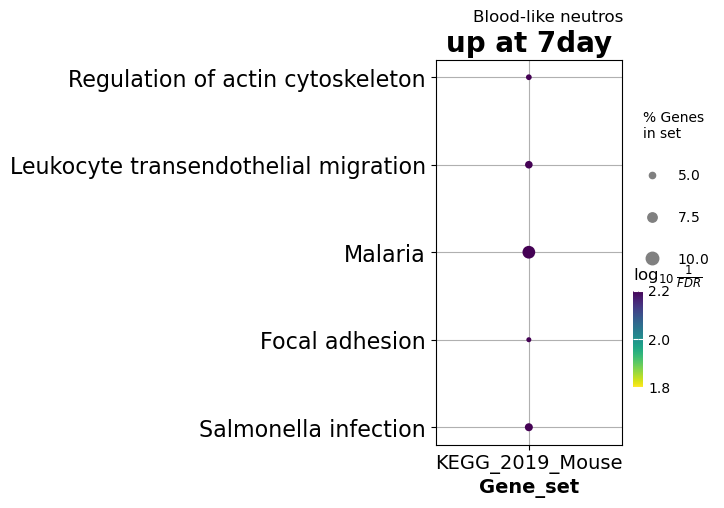

In [58]:
import matplotlib.pyplot as plt
import gseapy as gp

# Plot for Blood-like neutrophils
plt.figure(figsize=(8, 6))
ax = gp.dotplot(
    enr_up.results,
    column="Adjusted P-value",
    x="Gene_set",
    size=15,
    top_term=5,
    figsize=(3,5),
    title="up at 7day",
    xticklabels_rot=0,
    show_ring=False,
    marker="o",
    legend_kws={"bbox_to_anchor": (1.05, 1), "loc": "upper left", "title": "Adj. P-value"},
)
#ax.yaxis.grid(False)
ax.xaxis.grid(True)
plt.tight_layout()
plt.suptitle("Blood-like neutros")

<Figure size 800x600 with 0 Axes>

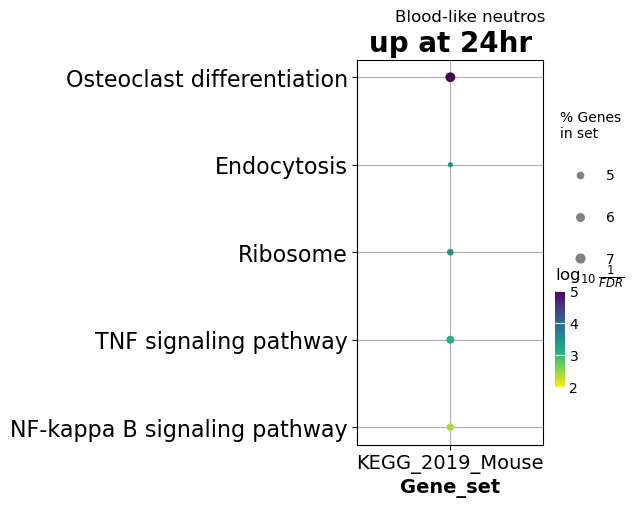

In [59]:
# Plot for blood-like neutrophils
plt.figure(figsize=(8, 6))
ax = gp.dotplot(
    enr_dwn.results,
    column="Adjusted P-value",
    x="Gene_set",
    size=15,
    top_term=5,
    figsize=(3,5),
    title="up at 24hr",
    xticklabels_rot=0,
    show_ring=False,
    marker="o",
    legend_kws={"bbox_to_anchor": (1.05, 1), "loc": "upper left", "title": "Adj. P-value"},
)
#ax.yaxis.grid(False)
ax.xaxis.grid(True)
plt.tight_layout()
plt.suptitle("Blood-like neutros")
plt.show()

In [60]:
print("  Pathway analysis within Blood-like neutros")
dwn_genes = upregl.loc[upregl["score"] < 0].index[::-1][:150]
up_genes = upregl.loc[upregl["score"] > 0].index[:150]
print("  Downregulated at 7 days")
enr_dwn = gp.enrichr(
    gene_list=list(dwn_genes),
    gene_sets=["GO_Biological_Process_2023"],
    organism="mouse",
    outdir=None,
)
print("  Upregulated at 7 days")
enr_up = gp.enrichr(
    gene_list=list(up_genes),
    gene_sets=["GO_Biological_Process_2023"],
    organism="mouse",
    outdir=None,
)
dwn_pathways = enr_dwn.results.query(
    "Gene_set == 'GO_Biological_Process_2023'"
).nsmallest(10, "Adjusted P-value")
dwn_pathways = dwn_pathways.loc[dwn_pathways["Adjusted P-value"] < 0.05]

up_pathways = enr_up.results.query(
    "Gene_set == 'GO_Biological_Process_2023'"
).nsmallest(10, "Adjusted P-value")
up_pathways = up_pathways.loc[up_pathways["Adjusted P-value"] < 0.05]


  Pathway analysis within Blood-like neutros
  Downregulated at 7 days
  Upregulated at 7 days


Text(0.5, 0.98, 'Blood-like neutros')

<Figure size 800x600 with 0 Axes>

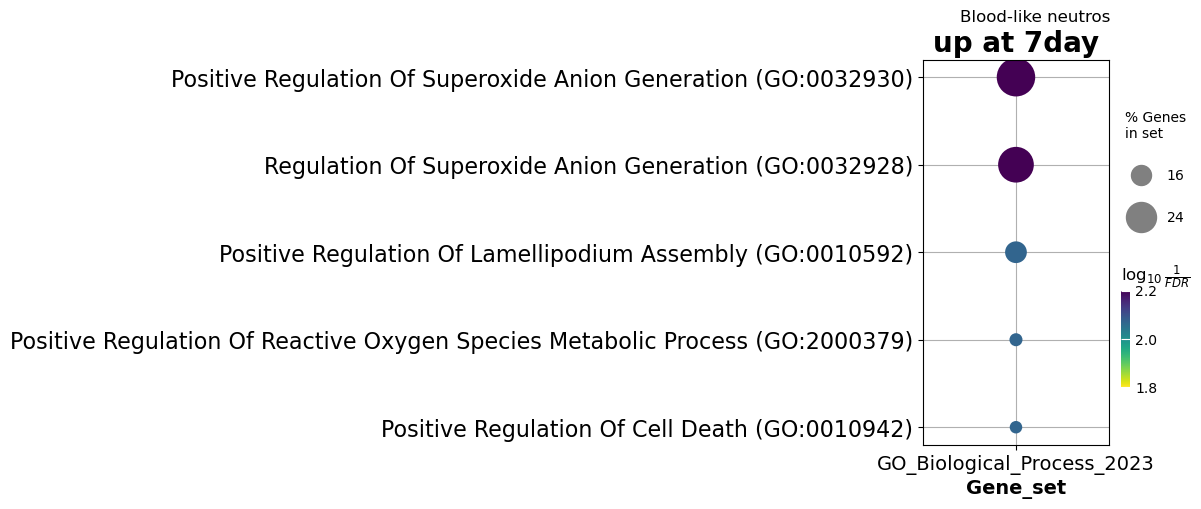

In [61]:
import matplotlib.pyplot as plt
import gseapy as gp

# Plot for Blood-like neutrophils
plt.figure(figsize=(8, 6))
ax = gp.dotplot(
    enr_up.results,
    column="Adjusted P-value",
    x="Gene_set",
    size=15,
    top_term=5,
    figsize=(3,5),
    title="up at 7day",
    xticklabels_rot=0,
    show_ring=False,
    marker="o",
    legend_kws={"bbox_to_anchor": (1.05, 1), "loc": "upper left", "title": "Adj. P-value"},
)
#ax.yaxis.grid(False)
ax.xaxis.grid(True)
plt.tight_layout()
plt.suptitle("Blood-like neutros")

<Figure size 800x600 with 0 Axes>

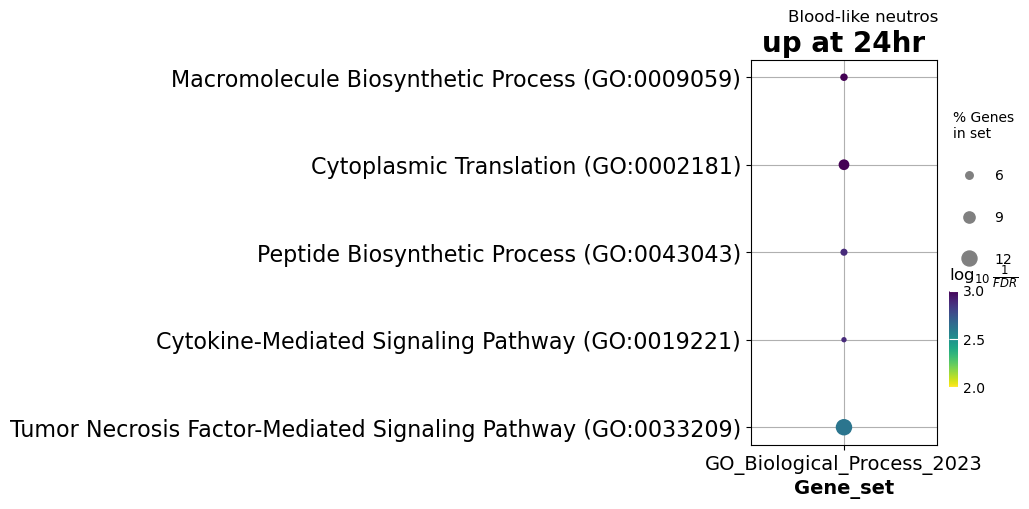

In [62]:
# Plot for Blood-like neutrophils
plt.figure(figsize=(8, 6))
ax = gp.dotplot(
    enr_dwn.results,
    column="Adjusted P-value",
    x="Gene_set",
    size=15,
    top_term=5,
    figsize=(3,5),
    title="up at 24hr",
    xticklabels_rot=0,
    show_ring=False,
    marker="o",
    legend_kws={"bbox_to_anchor": (1.05, 1), "loc": "upper left", "title": "Adj. P-value"},
)
#ax.yaxis.grid(False)
ax.xaxis.grid(True)
plt.tight_layout()
plt.suptitle("Blood-like neutros")
plt.show()

In [63]:
 from mygene import MyGeneInfo
mg = MyGeneInfo()

result = mg.query('ENSMUSG00000121501', species='mouse')
print(result['hits'][0]['symbol'])  # Output: gene symbol

Gvin-ps7


In [64]:
# Extract DGE results from Scanpy
result = wound_neutro_tl.uns['rank_genes_groups']
group = '24hr'  # Replace with your comparison group if different

# Create DataFrame for the selected group
deg_df = pd.DataFrame({
    'gene': result['names'][group],
    'logfc': result['logfoldchanges'][group],
    'pval_adj': result['pvals_adj'][group]
})

genes_bt_timepoint= ['S100a11','Isg20','Slfn1','Tinf2','Trim30b','Rdh12','Slfn4','Actb','S100a6','Por',
                     'Slc11a1','Ccl6','Tnrc18','Cmip','Cd80','Anxa2','Helz2','Hpcal1','Ezr','Vps37b',
                     'Hbb-bs','Fth1','Hba-a2','Hba-a1','Pkm','Tgif1','Zfp36','Ftl1','Zfp36l1','Ccrl2',
                     'Marcksl1','Pgam1','Hspa5','Marcks','Egr1','Nfkbia','Ctsb','Hbb-bt','Sod2','Dmxl2']


heatmap_df = deg_df[deg_df['gene'].isin(genes_bt_timepoint)].sort_values(by='logfc', ascending=False)
heatmap_df = heatmap_df.set_index('gene')[['logfc']]
gene_list = heatmap_df.index.tolist()
print(gene_list)

['Isg20', 'Tinf2', 'Hpcal1', 'Helz2', 'Slfn1', 'Trim30b', 'Vps37b', 'Ezr', 'Cd80', 'Rdh12', 'Slfn4', 'Tnrc18', 'Ccl6', 'Anxa2', 'Cmip', 'S100a6', 'Por', 'Slc11a1', 'S100a11', 'Actb', 'Hspa5', 'Pkm', 'Egr1', 'Marcksl1', 'Ftl1', 'Nfkbia', 'Marcks', 'Zfp36', 'Dmxl2', 'Ctsb', 'Zfp36l1', 'Fth1', 'Tgif1', 'Pgam1', 'Ccrl2', 'Sod2', 'Hba-a1', 'Hbb-bs', 'Hba-a2', 'Hbb-bt']


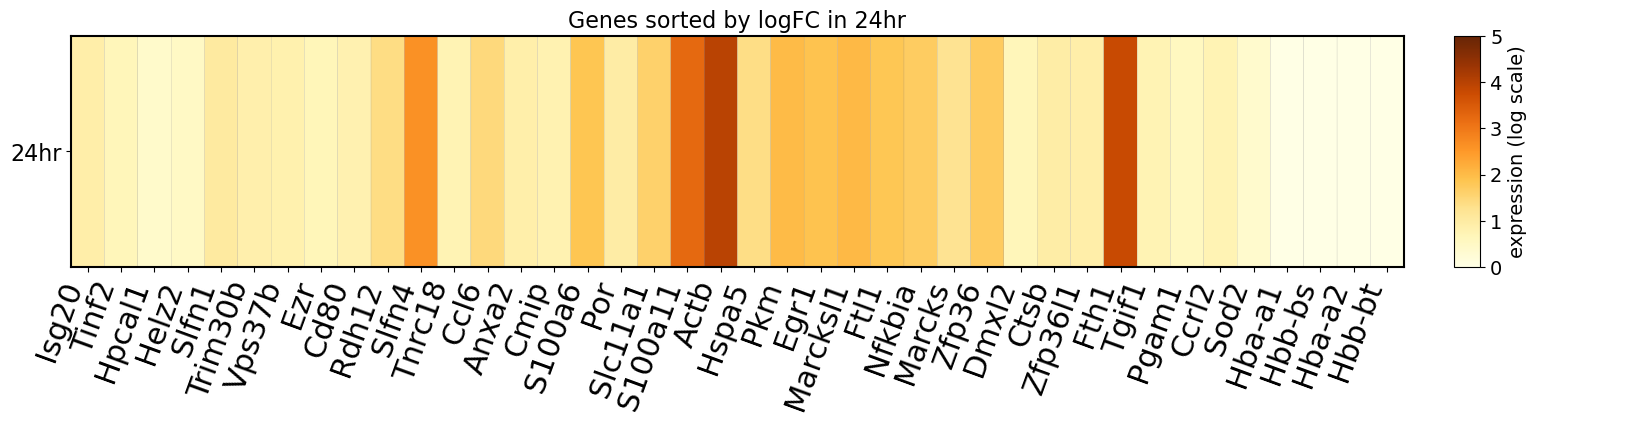

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib as mpl

# Extract DEGs for 24hr
group_24 = pd.DataFrame({
    'gene': result['names']['24hr'],
    'logfc': result['logfoldchanges']['24hr']
})
genes_24hr = (
    group_24[group_24['gene'].isin(genes_bt_timepoint)]
    .dropna()
    .sort_values(by='logfc', ascending=False)['gene']
    .tolist()
)

# Create matrixplot without showing
sc.pl.matrixplot(
    wound_neutro_tl[wound_neutro_tl.obs["time_point"] == "24hr"],
    var_names=genes_24hr,
    groupby="time_point",
    swap_axes=False,
    cmap='YlOrBr',
    standard_scale=None,
    vmin=0,
    vmax=5,
    figsize=(20, 3),
    dendrogram=False,
    show=False
)

# Get the figure and main axis
fig = plt.gcf()
main_ax = fig.axes[0]  # Matrix axis
if len(fig.axes) > 1:
    fig.delaxes(fig.axes[-1])  # remove default colorbar if exists

# Add custom colorbar
divider = make_axes_locatable(main_ax)
cbar_ax = divider.append_axes("right", size="2%", pad=0.5)

norm = mpl.colors.Normalize(vmin=0, vmax=5)
cbar = mpl.colorbar.ColorbarBase(
    cbar_ax,
    cmap='YlOrBr',
    norm=norm,
    orientation='vertical'
)
cbar.ax.tick_params(labelsize=14)
cbar.set_label("expression (log scale)", fontsize=14)

# Style main axis
main_ax.set_xticklabels(main_ax.get_xticklabels(), fontsize=22, rotation=70, ha='right')
main_ax.set_yticklabels(main_ax.get_yticklabels(), fontsize=16)
main_ax.set_xlabel('')
main_ax.set_ylabel('')
main_ax.set_title('Genes sorted by logFC in 24hr', fontsize=16)

plt.tight_layout()
plt.show()


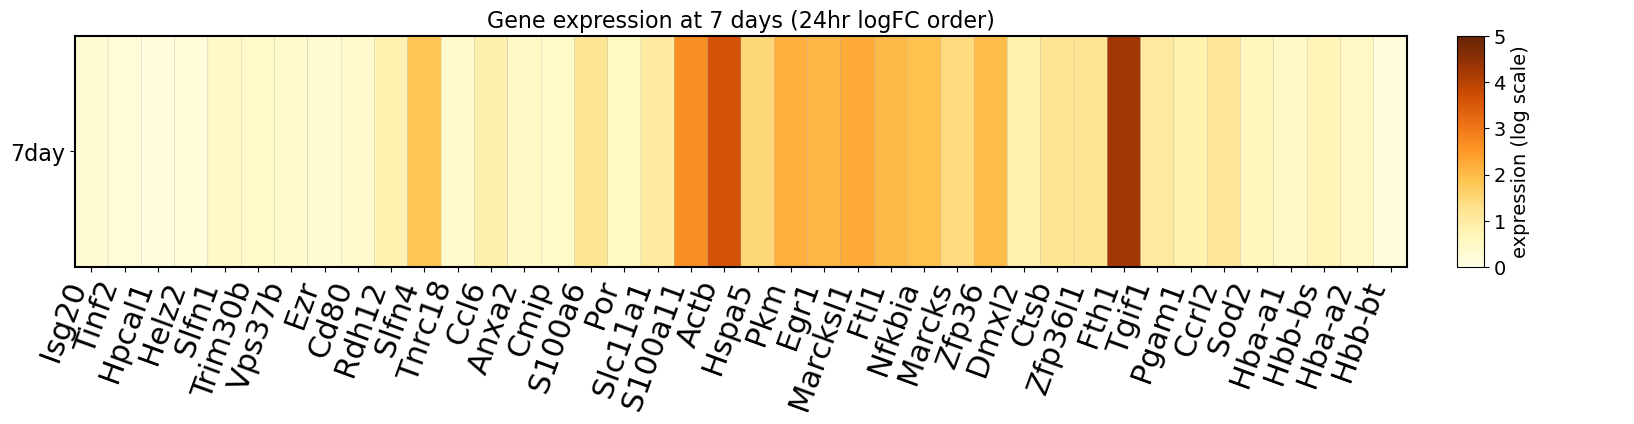

In [66]:
# Extract DEGs for 7day
group_7 = pd.DataFrame({
    'gene': result['names']['7day'],
    'logfc': result['logfoldchanges']['7day']
})
genes_7day = (
    group_7[group_7['gene'].isin(genes_bt_timepoint)]
    .dropna()
    .sort_values(by='logfc', ascending=True)['gene']
    .tolist()
)

# Create matrixplot without showing
sc.pl.matrixplot(
    wound_neutro_tl[wound_neutro_tl.obs["time_point"] == "7day"],
    var_names=genes_7day,
    groupby="time_point",
    swap_axes=False,
    cmap='YlOrBr',
    standard_scale=None,
    vmin=0,
    vmax=5,
    figsize=(20, 3),
    dendrogram=False,
    show=False
)

# Get the figure and main axis
fig = plt.gcf()
main_ax = fig.axes[0]  # Matrix axis
if len(fig.axes) > 1:
    fig.delaxes(fig.axes[-1])  # remove default colorbar if exists

# Add custom colorbar
divider = make_axes_locatable(main_ax)
cbar_ax = divider.append_axes("right", size="2%", pad=0.5)

norm = mpl.colors.Normalize(vmin=0, vmax=5)
cbar = mpl.colorbar.ColorbarBase(
    cbar_ax,
    cmap='YlOrBr',
    norm=norm,
    orientation='vertical'
)
cbar.ax.tick_params(labelsize=14)
cbar.set_label("expression (log scale)", fontsize=14)

# Style main axis
main_ax.set_xticklabels(main_ax.get_xticklabels(), fontsize=22, rotation=70, ha='right')
main_ax.set_yticklabels(main_ax.get_yticklabels(), fontsize=16)
main_ax.set_xlabel('')
main_ax.set_ylabel('')
main_ax.set_title('Gene expression at 7 days (24hr logFC order)', fontsize=16)

plt.tight_layout()
plt.show()


In [67]:
group_7 = pd.DataFrame({
    'gene': result['names']['7day'],
    'logfc': result['logfoldchanges']['7day']
})
genes_7day = (
    group_7[group_7['gene'].isin(genes_bt_timepoint)]
    .dropna()
    .sort_values(by='logfc', ascending=True)['gene']
    .tolist()
)
df = group_7[group_7['gene'].isin(genes_7day)].dropna()
df = df.set_index('gene')


In [68]:
# Subset 7day cells from AnnData
adata_7day = wound_neutro_tl[wound_neutro_tl.obs["time_point"] == "7day"]

# Compute mean expression (log-normalized) for each gene in genes_7day
mean_exp = pd.Series(
    adata_7day[:, genes_7day].X.mean(axis=0).A1,
    index=genes_7day
)


In [69]:
df['mean_expression_7day'] = mean_exp
df = df.reset_index()  # Bring 'gene' back as a column


In [70]:
print(df.sort_values(by='logfc', ascending=True))

        gene     logfc  mean_expression_7day
38     Isg20 -2.109642              0.296526
36     Tinf2 -1.907973              0.222801
22    Hpcal1 -1.796972              0.129791
23     Helz2 -1.619648              0.194915
37     Slfn1 -1.614210              0.470876
35   Trim30b -1.403249              0.418098
20    Vps37b -1.372145              0.406264
21       Ezr -1.319782              0.322680
25      Cd80 -1.308159              0.407591
34     Rdh12 -1.302937              0.787759
33     Slfn4 -1.285667              1.835780
27    Tnrc18 -1.251555              0.390679
28      Ccl6 -1.244922              0.863441
24     Anxa2 -1.206729              0.483770
26      Cmip -1.204641              0.425886
31    S100a6 -1.190325              1.202672
30       Por -1.141168              0.555813
29   Slc11a1 -1.132896              1.036985
39   S100a11 -0.908416              2.658768
32      Actb -0.531687              3.623006
12     Hspa5  0.255247              1.498814
4        P

In [71]:
print(df.sort_values(by='mean_expression_7day', ascending=False))

        gene     logfc  mean_expression_7day
1       Fth1  0.733635              4.295979
32      Actb -0.531687              3.623006
39   S100a11 -0.908416              2.658768
10  Marcksl1  0.309979              2.237252
4        Pkm  0.307378              2.178813
14      Egr1  0.309484              2.070230
7       Ftl1  0.325489              2.023525
6      Zfp36  0.422171              1.985162
15    Nfkbia  0.329554              1.906667
33     Slfn4 -1.285667              1.835780
12     Hspa5  0.255247              1.498814
13    Marcks  0.339070              1.407166
16      Ctsb  0.567041              1.208860
31    S100a6 -1.190325              1.202672
8    Zfp36l1  0.635534              1.189765
9      Ccrl2  0.853885              1.116814
5      Tgif1  0.771875              1.069487
29   Slc11a1 -1.132896              1.036985
28      Ccl6 -1.244922              0.863441
11     Pgam1  0.773449              0.838361
19     Dmxl2  0.514377              0.834224
34     Rdh

In [72]:
group_24 = pd.DataFrame({
    'gene': result['names']['24hr'],
    'logfc': result['logfoldchanges']['24hr']
})
genes_24hr = (
    group_24[group_24['gene'].isin(genes_bt_timepoint)]
    .dropna()
    .sort_values(by='logfc', ascending=False)['gene']
    .tolist()
)
df_24 = group_24[group_24['gene'].isin(genes_24hr)].dropna()
df_24 = df_24.set_index('gene')

In [73]:
# Subset 24hr cells from AnnData
adata_24hr = wound_neutro_tl[wound_neutro_tl.obs["time_point"] == "24hr"]

# Compute mean expression (log-normalized) for each gene in genes_24hr
mean_exp_24 = pd.Series(
    adata_24hr[:, genes_24hr].X.mean(axis=0).A1,
    index=genes_24hr
)
df_24['mean_expression_24hr'] = mean_exp_24
df_24 = df_24.reset_index()  # Bring 'gene' back as a column


In [74]:
print(df_24.sort_values(by='logfc', ascending=True))

        gene     logfc  mean_expression_24hr
22    Hbb-bt -7.184406              0.001186
37    Hba-a2 -6.166894              0.009363
39    Hbb-bs -6.106547              0.014440
36    Hba-a1 -5.466151              0.012811
21      Sod2 -0.877863              0.372357
30     Ccrl2 -0.853885              0.759437
28     Pgam1 -0.773449              0.569781
34     Tgif1 -0.771875              0.751830
38      Fth1 -0.733635              3.796449
31   Zfp36l1 -0.635534              0.904909
23      Ctsb -0.567041              0.950121
20     Dmxl2 -0.514377              0.648276
33     Zfp36 -0.422171              1.738171
26    Marcks -0.339070              1.234991
24    Nfkbia -0.329554              1.715659
32      Ftl1 -0.325489              1.830819
29  Marcksl1 -0.309979              2.047657
25      Egr1 -0.309484              1.885449
35       Pkm -0.307378              1.992272
27     Hspa5 -0.255247              1.364218
7       Actb  0.531687              3.983279
0    S100a

In [75]:
print(df_24.sort_values(by='mean_expression_24hr', ascending=False))

        gene     logfc  mean_expression_24hr
7       Actb  0.531687              3.983279
38      Fth1 -0.733635              3.796449
0    S100a11  0.908416              3.255162
6      Slfn4  1.285667              2.628142
29  Marcksl1 -0.309979              2.047657
35       Pkm -0.307378              1.992272
25      Egr1 -0.309484              1.885449
8     S100a6  1.190325              1.842909
32      Ftl1 -0.325489              1.830819
33     Zfp36 -0.422171              1.738171
24    Nfkbia -0.329554              1.715659
10   Slc11a1  1.132896              1.607989
11      Ccl6  1.244922              1.446936
5      Rdh12  1.302937              1.375483
27     Hspa5 -0.255247              1.364218
26    Marcks -0.339070              1.234991
2      Slfn1  1.614210              1.044206
9        Por  1.141168              0.970606
23      Ctsb -0.567041              0.950121
1      Isg20  2.109642              0.912175
31   Zfp36l1 -0.635534              0.904909
15     Anx

In [5]:
import numpy as np
import re

def detect_naming(wound_neutro):
    """Return a dict describing the gene naming scheme in .var_names and possible mapping cols."""
    v = wound_neutro.var_names.astype(str).values

    # Heuristics
    ensembl_like = np.array([g.startswith(("ENSMUSG", "ENSG")) for g in v]).sum()
    has_dot_suffix = np.array(["." in g for g in v]).sum()
    looks_symbol = np.array([bool(re.match(r"^[A-Za-z0-9\-|]+$", g)) and not g.startswith(("ENSMUSG","ENSG")) for g in v]).sum()

    # Common mapping columns that might already exist
    varcols = [c.lower() for c in wound_neutro.var.columns]
    possible_symbol_cols = [c for c in wound_neutro.var.columns if c.lower() in {"symbol","gene_symbol","gene","gene_name","feature_name"}]
    possible_id_cols     = [c for c in wound_neutro.var.columns if c.lower() in {"ensembl","ensembl_id","gene_id","gene_ids"}]

    # Verdict
    if ensembl_like > 0 and ensembl_like >= 0.5 * len(v):
        scheme = "ensembl"
    else:
        # if most names are not ensembl-like, assume symbols
        scheme = "symbol"

    return {
        "n_genes": len(v),
        "ensembl_like": int(ensembl_like),
        "has_dot_suffix": int(has_dot_suffix),
        "looks_symbol": int(looks_symbol),
        "scheme_guess": scheme,
        "symbol_mapping_cols": possible_symbol_cols,
        "ensembl_mapping_cols": possible_id_cols,
        "preview_first10": v[:10].tolist(),
        "preview_last10": v[-10:].tolist()
    }

wound_info = detect_naming(wound_neutro)
print("Wound naming info:", wound_info)
print("=> Detected wound scheme:", wound_info["scheme_guess"].upper())


Wound naming info: {'n_genes': 25223, 'ensembl_like': 1053, 'has_dot_suffix': 2, 'looks_symbol': 24167, 'scheme_guess': 'symbol', 'symbol_mapping_cols': [], 'ensembl_mapping_cols': [], 'preview_first10': ['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610009E02Rik', '0610009L18Rik', '0610012D04Rik', '0610012G03Rik', '0610030E20Rik', '0610038B21Rik', '0610039K10Rik'], 'preview_last10': ['mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6', 'tdTomato|AY678269.1|Synthetic']}
=> Detected wound scheme: SYMBOL
